### Predicting Obesity Status from Gut Microbiome and Metadata

This section builds a machine learning pipeline to predict whether an individual is *Obese* or *Non-Obese* using gut microbiome (OTU abundances) and selected metadata (e.g., location, zone, gender, age, lifestyle).

- **Target variable:** Obesity status (`Obesity_encoded`)
- **Features:** OTU abundances ± selected metadata
- **Filters applied:** Abundance and/or prevalence thresholds on OTUs
- **Models used:** Random Forest, HistGradientBoosting, XGBoost, SVM, Logistic Regression
- **Evaluation:** 80–20 train–test split with 5-fold cross-validation on training data
- **Output:** Model accuracies, F1 scores, AUC values, and summaries saved to Excel


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import xgboost as xgb
from tqdm import tqdm
import time
import warnings
warnings.filterwarnings('ignore')
# Load data
print("Loading data...")
otu = pd.read_excel(r"C:\Users\91735\OneDrive\IITM\PhD\Coursework Sem 3\AI project\abundance_only.xlsx", index_col=0)
meta = pd.read_excel(r"C:\Users\91735\OneDrive\IITM\PhD\Coursework Sem 3\AI project\metadata_only.xlsx")

print(f"OTU table shape: {otu.shape}")
print(f"Metadata shape: {meta.shape}")

# Prepare metadata
# Assuming the first column is sample ID - adjust if needed
sample_id_col = meta.columns[0]
meta = meta.set_index(sample_id_col)

# Encode categorical variables
le_location = LabelEncoder()
le_zone = LabelEncoder()
le_gender = LabelEncoder()
le_lifestyle = LabelEncoder()
le_obesity = LabelEncoder()

meta_encoded = meta.copy()
meta_encoded['Geographical_Location_encoded'] = le_location.fit_transform(meta['Geographical Location'])
meta_encoded['Geographical_Zone_encoded'] = le_zone.fit_transform(meta['Geographical zone in India'])
meta_encoded['Gender_encoded'] = le_gender.fit_transform(meta['Gender'])
meta_encoded['Lifestyle_encoded'] = le_lifestyle.fit_transform(meta['Life style pattern'])
meta_encoded['Obesity_encoded'] = le_obesity.fit_transform(meta['Obese/Non Obese'])

print("Encoding mappings:")
print("Location:", dict(zip(le_location.classes_, le_location.transform(le_location.classes_))))
print("Zone:", dict(zip(le_zone.classes_, le_zone.transform(le_zone.classes_))))
print("Gender:", dict(zip(le_gender.classes_, le_gender.transform(le_gender.classes_))))
print("Lifestyle:", dict(zip(le_lifestyle.classes_, le_lifestyle.transform(le_lifestyle.classes_))))
print("Obesity:", dict(zip(le_obesity.classes_, le_obesity.transform(le_obesity.classes_))))

def filter_otu_table(otu_df, abundance_threshold=None, prevalence_threshold=None):
    """
    Filter OTU table based on abundance and/or prevalence thresholds
    """
    filtered_otu = otu_df.copy()
    
    if abundance_threshold is not None:
        # Convert percentage to decimal
        abundance_threshold = abundance_threshold / 100
        # Filter based on mean abundance
        mean_abundance = filtered_otu.mean(axis=0)
        abundance_filter = mean_abundance >= abundance_threshold
        filtered_otu = filtered_otu.loc[:, abundance_filter]
        print(f"After abundance filtering (>={abundance_threshold*100}%): {filtered_otu.shape[1]} features")
    
    if prevalence_threshold is not None:
        # Convert percentage to decimal
        prevalence_threshold = prevalence_threshold / 100
        # Filter based on prevalence (fraction of samples with non-zero abundance)
        prevalence = (filtered_otu > 0).sum(axis=0) / filtered_otu.shape[0]
        prevalence_filter = prevalence >= prevalence_threshold
        filtered_otu = filtered_otu.loc[:, prevalence_filter]
        print(f"After prevalence filtering (>={prevalence_threshold*100}%): {filtered_otu.shape[1]} features")
    
    return filtered_otu

def prepare_features(otu_filtered, meta_encoded, feature_combination):
    """
    Prepare feature matrix based on selected metadata features
    """
    # Align samples
    common_samples = list(set(otu_filtered.index) & set(meta_encoded.index))
    otu_aligned = otu_filtered.loc[common_samples]
    meta_aligned = meta_encoded.loc[common_samples]
    
    # Select metadata features
    metadata_features = []
    if 'location' in feature_combination:
        metadata_features.append('Geographical_Location_encoded')
    if 'zone' in feature_combination:
        metadata_features.append('Geographical_Zone_encoded')
    if 'gender' in feature_combination:
        metadata_features.append('Gender_encoded')
    if 'age' in feature_combination:
        # Handle potential spacing issues in column name
        age_col = [col for col in meta_encoded.columns if 'AGE' in col.upper()][0]
        metadata_features.append(age_col)
    if 'lifestyle' in feature_combination:
        metadata_features.append('Lifestyle_encoded')
    
    # Combine OTU data with selected metadata
    if metadata_features:
        X = pd.concat([otu_aligned, meta_aligned[metadata_features]], axis=1)
    else:
        X = otu_aligned
    
    y = meta_aligned['Obesity_encoded']
    
    return X, y

def train_and_evaluate_models(X, y, random_state=42):
    """
    Train multiple ML models and evaluate their performance
    """
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                        random_state=random_state, 
                                                        stratify=y)
    
    # Scale features for models that need it
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Define models
    models = {
        'RandomForest': RandomForestClassifier(n_estimators=100, random_state=random_state),
        'HistGradientBoost': HistGradientBoostingClassifier(random_state=random_state),
        'XGBoost': xgb.XGBClassifier(random_state=random_state, eval_metric='logloss'),
        'SVM': SVC(probability=True, random_state=random_state),
        'LogisticRegression': LogisticRegression(random_state=random_state, max_iter=1000)
    }
    
    results = {}
    
    for model_name, model in models.items():
        print(f"Training {model_name}...")
        
        # Use scaled data for SVM and LogisticRegression
        if model_name in ['SVM', 'LogisticRegression']:
            X_train_model = X_train_scaled
            X_test_model = X_test_scaled
        else:
            X_train_model = X_train
            X_test_model = X_test
        
        # Train model
        model.fit(X_train_model, y_train)
        
        # Predictions
        y_pred = model.predict(X_test_model)
        y_pred_proba = model.predict_proba(X_test_model)[:, 1]
        
        # Cross-validation
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        cv_scores = cross_val_score(model, X_train_model, y_train, cv=cv, scoring='accuracy')
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        try:
            auc = roc_auc_score(y_test, y_pred_proba)
        except:
            auc = np.nan
        
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        
        results[model_name] = {
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1_Score': f1,
            'AUC': auc,
            'Sensitivity': sensitivity,
            'Specificity': specificity,
            'CV_Mean': cv_scores.mean(),
            'CV_Std': cv_scores.std(),
            'True_Negatives': tn,
            'False_Positives': fp,
            'False_Negatives': fn,
            'True_Positives': tp,
            'N_Features': X.shape[1],
            'N_Samples': X.shape[0]
        }
    
    return results

# Define filtering strategies
filtering_strategies = {
    'No_Filter': {'abundance': None, 'prevalence': None},
    'Abundance_0.1': {'abundance': 0.1, 'prevalence': None},
    'Prevalence_5': {'abundance': None, 'prevalence': 5},
    'Combined_0.1_5': {'abundance': 0.1, 'prevalence': 5}
}

# Generate all possible combinations of metadata features
from itertools import combinations

available_features = ['location', 'zone', 'gender', 'age', 'lifestyle']
feature_combinations = {'OTU_Only': []}  # Start with OTU only

# Generate all combinations of different sizes
for r in range(1, len(available_features) + 1):
    for combo in combinations(available_features, r):
        combo_name = 'OTU_' + '_'.join([f.capitalize() for f in combo])
        feature_combinations[combo_name] = list(combo)

print(f"Total feature combinations to test: {len(feature_combinations)}")
print("Feature combinations:")
for name, features in feature_combinations.items():
    print(f"  {name}: {features}")

# Store all results
all_results = []

print("Starting ML pipeline...")
print("=" * 50)

# Calculate total experiments for progress bar
total_experiments = len(filtering_strategies) * len(feature_combinations)
print(f"Total experiments to run: {total_experiments}")

# Create progress bar
pbar = tqdm(total=total_experiments, desc="Running ML Pipeline")

# Run experiments
for filter_name, filter_params in filtering_strategies.items():
    print(f"\nApplying filter: {filter_name}")
    print("-" * 30)
    
    # Apply filtering
    otu_filtered = filter_otu_table(otu, 
                                   abundance_threshold=filter_params['abundance'],
                                   prevalence_threshold=filter_params['prevalence'])
    
    for feature_combo_name, feature_combo in feature_combinations.items():
        pbar.set_description(f"Filter: {filter_name} | Features: {feature_combo_name}")
        
        try:
            # Prepare features
            X, y = prepare_features(otu_filtered, meta_encoded, feature_combo)
            
            print(f"\nFeature combination: {feature_combo_name}")
            print(f"Feature matrix shape: {X.shape}")
            print(f"Class distribution: {dict(zip(*np.unique(y, return_counts=True)))}")
            
            # Train and evaluate models
            results = train_and_evaluate_models(X, y)
            
            # Add experiment info to results
            for model_name, metrics in results.items():
                result_row = {
                    'Filter_Strategy': filter_name,
                    'Feature_Combination': feature_combo_name,
                    'Model': model_name,
                    **metrics
                }
                all_results.append(result_row)
            
            # Cool down between feature combinations
            time.sleep(1.0)
                
        except Exception as e:
            print(f"Error with {feature_combo_name}: {str(e)}")
            
        # Update progress bar
        pbar.update(1)

# Close progress bar
pbar.close()

# Convert results to DataFrame
results_df = pd.DataFrame(all_results)

# Sort by accuracy for better visualization
results_df = results_df.sort_values(['Filter_Strategy', 'Feature_Combination', 'Accuracy'], 
                                   ascending=[True, True, False])

# Save results to Excel
output_file = r"C:\Users\91735\OneDrive\IITM\PhD\Coursework Sem 3\AI project\ml_results_summary.xlsx"
with pd.ExcelWriter(output_file) as writer:
    # Main results
    results_df.to_excel(writer, sheet_name='All_Results', index=False)
    
    # Summary by filter strategy
    summary_by_filter = results_df.groupby(['Filter_Strategy', 'Model'])['Accuracy'].agg(['mean', 'std', 'max']).reset_index()
    summary_by_filter.to_excel(writer, sheet_name='Summary_by_Filter', index=False)
    
    # Best results for each model
    best_results = results_df.loc[results_df.groupby('Model')['Accuracy'].idxmax()]
    best_results.to_excel(writer, sheet_name='Best_Results', index=False)
    
    # Feature combination analysis
    feature_summary = results_df.groupby(['Feature_Combination', 'Model'])['Accuracy'].agg(['mean', 'std', 'max']).reset_index()
    feature_summary.to_excel(writer, sheet_name='Feature_Analysis', index=False)

print(f"\nResults saved to: {output_file}")

# Display top 10 results
print("\nTop 10 Results by Accuracy:")
print("=" * 50)
top_results = results_df.nlargest(10, 'Accuracy')[['Filter_Strategy', 'Feature_Combination', 'Model', 'Accuracy', 'F1_Score', 'AUC']]
print(top_results.to_string(index=False))

# Display best result for each model
print("\nBest Result for Each Model:")
print("=" * 50)
best_by_model = results_df.loc[results_df.groupby('Model')['Accuracy'].idxmax()][['Model', 'Filter_Strategy', 'Feature_Combination', 'Accuracy', 'F1_Score', 'AUC']]
print(best_by_model.to_string(index=False))

print("\nAnalysis complete!")

### Hyperparameter Tuning for Obesity Prediction

This section performs hyperparameter tuning on multiple classifiers to predict whether an individual is *Obese* or *Non-Obese* based on gut microbiome OTU abundances and selected metadata (geographical zone, gender, lifestyle, etc.).

- **Target variable:** `Obesity_encoded` (Obese vs. Non-Obese)
- **Features:** OTU abundances ± metadata (zone, gender, lifestyle)
- **Filters applied:** Abundance and prevalence thresholds to remove low-quality OTUs
- **Models tuned:** Random Forest, HistGradientBoost, XGBoost, SVM, Logistic Regression
- **Evaluation:** 80–20 train–test split, 5-fold stratified CV, RandomizedSearchCV for hyperparameter tuning
- **Metrics reported:** Accuracy, F1-score, AUC, Sensitivity, Specificity
- **Outputs:** Results tables and best parameter settings saved to Excel


In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import xgboost as xgb
from tqdm import tqdm
import time
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

# Load data (same as your working code)
print("Loading data...")
otu = pd.read_excel(r"C:\Users\91735\OneDrive\IITM\PhD\Coursework Sem 3\AI project\abundance_only.xlsx", index_col=0)
meta = pd.read_excel(r"C:\Users\91735\OneDrive\IITM\PhD\Coursework Sem 3\AI project\metadata_only.xlsx")

print(f"OTU table shape: {otu.shape}")
print(f"Metadata shape: {meta.shape}")

# Prepare metadata (exactly same as your working code)
sample_id_col = meta.columns[0]
meta = meta.set_index(sample_id_col)

# Encode categorical variables
le_location = LabelEncoder()
le_zone = LabelEncoder()
le_gender = LabelEncoder()
le_lifestyle = LabelEncoder()
le_obesity = LabelEncoder()

meta_encoded = meta.copy()
meta_encoded['Geographical_Location_encoded'] = le_location.fit_transform(meta['Geographical Location'])
meta_encoded['Geographical_Zone_encoded'] = le_zone.fit_transform(meta['Geographical zone in India'])
meta_encoded['Gender_encoded'] = le_gender.fit_transform(meta['Gender'])
meta_encoded['Lifestyle_encoded'] = le_lifestyle.fit_transform(meta['Life style pattern'])
meta_encoded['Obesity_encoded'] = le_obesity.fit_transform(meta['Obese/Non Obese'])

print("Encoding mappings:")
print("Location:", dict(zip(le_location.classes_, le_location.transform(le_location.classes_))))
print("Zone:", dict(zip(le_zone.classes_, le_zone.transform(le_zone.classes_))))
print("Gender:", dict(zip(le_gender.classes_, le_gender.transform(le_gender.classes_))))
print("Lifestyle:", dict(zip(le_lifestyle.classes_, le_lifestyle.transform(le_lifestyle.classes_))))
print("Obesity:", dict(zip(le_obesity.classes_, le_obesity.transform(le_obesity.classes_))))

# Use exact same functions from your working code
def filter_otu_table(otu_df, abundance_threshold=None, prevalence_threshold=None):
    """
    Filter OTU table based on abundance and/or prevalence thresholds
    """
    filtered_otu = otu_df.copy()
    
    if abundance_threshold is not None:
        # Convert percentage to decimal
        abundance_threshold = abundance_threshold / 100
        # Filter based on mean abundance
        mean_abundance = filtered_otu.mean(axis=0)
        abundance_filter = mean_abundance >= abundance_threshold
        filtered_otu = filtered_otu.loc[:, abundance_filter]
        print(f"After abundance filtering (>={abundance_threshold*100}%): {filtered_otu.shape[1]} features")
    
    if prevalence_threshold is not None:
        # Convert percentage to decimal
        prevalence_threshold = prevalence_threshold / 100
        # Filter based on prevalence (fraction of samples with non-zero abundance)
        prevalence = (filtered_otu > 0).sum(axis=0) / filtered_otu.shape[0]
        prevalence_filter = prevalence >= prevalence_threshold
        filtered_otu = filtered_otu.loc[:, prevalence_filter]
        print(f"After prevalence filtering (>={prevalence_threshold*100}%): {filtered_otu.shape[1]} features")
    
    return filtered_otu

def prepare_features(otu_filtered, meta_encoded, feature_combination):
    """
    Prepare feature matrix based on selected metadata features
    """
    # Align samples
    common_samples = list(set(otu_filtered.index) & set(meta_encoded.index))
    otu_aligned = otu_filtered.loc[common_samples]
    meta_aligned = meta_encoded.loc[common_samples]
    
    # Select metadata features
    metadata_features = []
    if 'location' in feature_combination:
        metadata_features.append('Geographical_Location_encoded')
    if 'zone' in feature_combination:
        metadata_features.append('Geographical_Zone_encoded')
    if 'gender' in feature_combination:
        metadata_features.append('Gender_encoded')
    if 'age' in feature_combination:
        # Handle potential spacing issues in column name
        age_col = [col for col in meta_encoded.columns if 'AGE' in col.upper()][0]
        metadata_features.append(age_col)
    if 'lifestyle' in feature_combination:
        metadata_features.append('Lifestyle_encoded')
    
    # Combine OTU data with selected metadata
    if metadata_features:
        X = pd.concat([otu_aligned, meta_aligned[metadata_features]], axis=1)
    else:
        X = otu_aligned
    
    y = meta_aligned['Obesity_encoded']
    
    return X, y

# Define hyperparameter grids for each model
param_grids = {
    'HistGradientBoost': {
        'learning_rate': [0.05, 0.1, 0.2],
        'max_iter': [100, 200, 300],
        'max_leaf_nodes': [15, 31, 50],
        'min_samples_leaf': [10, 20, 30],
        'l2_regularization': [0.0, 0.1, 0.5]
    },
    
    'LogisticRegression': {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga'],
        'max_iter': [1000, 2000, 3000]
    },
    
    'RandomForest': {
        'n_estimators': [100, 200, 300, 500],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None],
        'bootstrap': [True, False]
    },
    
    'SVM': {
        'C': [0.1, 1, 10, 100],
        'kernel': ['rbf', 'poly', 'sigmoid'],
        'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
        'degree': [2, 3, 4],  # Only for poly kernel
    },
    
    'XGBoost': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 6, 9],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0],
        'reg_alpha': [0, 0.1, 0.5],
        'reg_lambda': [1, 1.5, 2]
    }
}

# Define the best model configurations from your results
best_configs = [
    {
        'filter_name': 'Abundance_0.1',
        'filter_params': {'abundance': 0.1, 'prevalence': None},
        'feature_combo': ['zone', 'gender', 'lifestyle'],
        'feature_combo_name': 'OTU_Zone_Gender_Lifestyle',
        'model_name': 'HistGradientBoost',
        'baseline_accuracy': 0.656716
    },
    {
        'filter_name': 'Combined_0.1_5',
        'filter_params': {'abundance': 0.1, 'prevalence': 5},
        'feature_combo': ['zone', 'gender', 'lifestyle'],
        'feature_combo_name': 'OTU_Zone_Gender_Lifestyle',
        'model_name': 'LogisticRegression',
        'baseline_accuracy': 0.577114
    },
    {
        'filter_name': 'Combined_0.1_5',
        'filter_params': {'abundance': 0.1, 'prevalence': 5},
        'feature_combo': ['zone', 'gender', 'lifestyle'],
        'feature_combo_name': 'OTU_Zone_Gender_Lifestyle',
        'model_name': 'RandomForest',
        'baseline_accuracy': 0.636816
    },
    {
        'filter_name': 'Combined_0.1_5',
        'filter_params': {'abundance': 0.1, 'prevalence': 5},
        'feature_combo': ['zone', 'gender', 'lifestyle'],
        'feature_combo_name': 'OTU_Zone_Gender_Lifestyle',
        'model_name': 'SVM',
        'baseline_accuracy': 0.60199
    },
    {
        'filter_name': 'Abundance_0.1',
        'filter_params': {'abundance': 0.1, 'prevalence': None},
        'feature_combo': ['zone', 'gender'],
        'feature_combo_name': 'OTU_Zone_Gender',
        'model_name': 'XGBoost',
        'baseline_accuracy': 0.621891
    }
]

def get_model_instance(model_name):
    """Get model instance with default parameters"""
    models = {
        'HistGradientBoost': HistGradientBoostingClassifier(random_state=42),
        'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000),
        'RandomForest': RandomForestClassifier(random_state=42),
        'SVM': SVC(probability=True, random_state=42),
        'XGBoost': xgb.XGBClassifier(random_state=42, eval_metric='logloss')
    }
    return models[model_name]

def evaluate_tuned_model(model, X_test, y_test):
    """Comprehensive model evaluation"""
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Calculate metrics (same as your working code)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    try:
        auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else np.nan
    except:
        auc = np.nan
    
    # Confusion matrix metrics
    try:
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    except:
        sensitivity = np.nan
        specificity = np.nan
        tn = fp = fn = tp = 0
    
    metrics = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1_Score': f1,
        'AUC': auc,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'True_Negatives': tn,
        'False_Positives': fp,
        'False_Negatives': fn,
        'True_Positives': tp
    }
    
    return metrics

def hyperparameter_tuning_single_config(config, use_randomized=True, n_iter=50):
    """Perform hyperparameter tuning for a specific configuration"""
    print(f"\n{'='*80}")
    print(f"Tuning: {config['model_name']} | Filter: {config['filter_name']} | Features: {config['feature_combo_name']}")
    print(f"Baseline Accuracy: {config['baseline_accuracy']:.6f}")
    print('='*80)
    
    try:
        # Apply the same filtering and feature preparation as your working code
        otu_filtered = filter_otu_table(otu, 
                                       abundance_threshold=config['filter_params']['abundance'],
                                       prevalence_threshold=config['filter_params']['prevalence'])
        X, y = prepare_features(otu_filtered, meta_encoded, config['feature_combo'])
        
        print(f"Data shape: {X.shape}")
        print(f"Class distribution: {dict(zip(*np.unique(y, return_counts=True)))}")
        
        # Split data (same as your working code)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                            random_state=42, stratify=y)
        
        # Scale features if needed (same logic as your working code)
        need_scaling = config['model_name'] in ['SVM', 'LogisticRegression']
        if need_scaling:
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            X_train_model = X_train_scaled
            X_test_model = X_test_scaled
        else:
            X_train_model = X_train
            X_test_model = X_test
        
        # Get model and parameter grid
        base_model = get_model_instance(config['model_name'])
        param_grid = param_grids[config['model_name']]
        
        # Set up cross-validation
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        
        # Choose search strategy
        if use_randomized and len(param_grid) > 3:  # Use RandomizedSearch for large grids
            print(f"Using RandomizedSearchCV with {n_iter} iterations...")
            search = RandomizedSearchCV(
                base_model, param_grid, n_iter=n_iter, cv=cv, 
                scoring='accuracy', n_jobs=-1, random_state=42, verbose=1
            )
        else:
            print("Using GridSearchCV...")
            search = GridSearchCV(
                base_model, param_grid, cv=cv, 
                scoring='accuracy', n_jobs=-1, verbose=1
            )
        
        # Fit the search
        print("Starting hyperparameter search...")
        start_time = time.time()
        search.fit(X_train_model, y_train)
        search_time = time.time() - start_time
        
        # Get best model
        best_model = search.best_estimator_
        
        # Cross-validation on best model (same as your working code)
        cv_scores = cross_val_score(best_model, X_train_model, y_train, cv=cv, scoring='accuracy')
        
        # Evaluate on test set
        test_metrics = evaluate_tuned_model(best_model, X_test_model, y_test)
        
        # Results summary (same structure as your working code)
        results = {
            'Filter_Strategy': config['filter_name'],
            'Feature_Combination': config['feature_combo_name'],
            'Model': config['model_name'],
            'Baseline_Accuracy': config['baseline_accuracy'],
            'Best_CV_Score': search.best_score_,
            'CV_Mean': cv_scores.mean(),
            'CV_Std': cv_scores.std(),
            'Best_Parameters': str(search.best_params_),
            'Search_Time_Minutes': search_time / 60,
            'N_Features': X.shape[1],
            'N_Samples': X.shape[0],
            **test_metrics  # Add all test metrics
        }
        
        # Improvement calculation
        improvement = results['Accuracy'] - config['baseline_accuracy']
        results['Accuracy_Improvement'] = improvement
        results['Improvement_Percentage'] = (improvement / config['baseline_accuracy']) * 100
        
        print(f"\nResults Summary:")
        print(f"Baseline Accuracy: {config['baseline_accuracy']:.6f}")
        print(f"Best CV Score: {search.best_score_:.6f}")
        print(f"Test Accuracy: {results['Accuracy']:.6f}")
        print(f"Improvement: {improvement:+.6f} ({results['Improvement_Percentage']:+.2f}%)")
        print(f"Search Time: {search_time/60:.2f} minutes")
        print(f"Best Parameters: {search.best_params_}")
        
        # Cool down to prevent overheating
        time.sleep(2.0)
        
        return results, best_model
        
    except Exception as e:
        print(f"❌ Error in hyperparameter tuning: {str(e)}")
        return None, None

# Main hyperparameter tuning pipeline
print("\n" + "="*80)
print("STARTING HYPERPARAMETER TUNING PIPELINE")
print("="*80)
print(f"Total configurations to tune: {len(best_configs)}")

all_tuning_results = []
best_tuned_models = {}

# Create progress bar
pbar = tqdm(best_configs, desc="Hyperparameter Tuning Progress")

for config in pbar:
    pbar.set_description(f"Tuning {config['model_name']} - {config['filter_name']}")
    
    results, tuned_model = hyperparameter_tuning_single_config(config, use_randomized=True, n_iter=50)
    
    if results is not None:
        all_tuning_results.append(results)
        
        # Store best model
        model_key = f"{config['model_name']}_{config['filter_name']}_{config['feature_combo_name']}"
        best_tuned_models[model_key] = tuned_model

pbar.close()

# Check if we have any results
if not all_tuning_results:
    print("❌ No hyperparameter tuning results were generated!")
    print("All configurations failed. Please check the error messages above.")
else:
    # Create results DataFrame
    tuning_results_df = pd.DataFrame(all_tuning_results)
    
    # Sort by test accuracy (same as your working code)
    tuning_results_df = tuning_results_df.sort_values('Accuracy', ascending=False)
    
    # Save results (same structure as your working code)
    output_file = r"C:\Users\91735\OneDrive\IITM\PhD\Coursework Sem 3\AI project\hyperparameter_tuning_results.xlsx"
    with pd.ExcelWriter(output_file) as writer:
        # Main tuning results
        tuning_results_df.to_excel(writer, sheet_name='Tuning_Results', index=False)
        
        # Improvement summary
        improvement_summary = tuning_results_df[['Model', 'Filter_Strategy', 'Baseline_Accuracy', 
                                               'Accuracy', 'Accuracy_Improvement', 
                                               'Improvement_Percentage']].copy()
        improvement_summary.to_excel(writer, sheet_name='Improvement_Summary', index=False)
        
        # Best parameters summary
        params_summary = tuning_results_df[['Model', 'Filter_Strategy', 'Feature_Combination', 
                                          'Best_Parameters', 'Accuracy']].copy()
        params_summary.to_excel(writer, sheet_name='Best_Parameters', index=False)

    print(f"\nHyperparameter tuning results saved to: {output_file}")

    # Display results (same format as your working code)
    print("\nHyperparameter Tuning Results Summary:")
    print("=" * 100)
    display_cols = ['Model', 'Filter_Strategy', 'Baseline_Accuracy', 'Accuracy', 
                   'Accuracy_Improvement', 'Improvement_Percentage', 'F1_Score', 'AUC']
    print(tuning_results_df[display_cols].to_string(index=False))

    print(f"\nBest Overall Tuned Model:")
    best_overall = tuning_results_df.iloc[0]
    print(f"Model: {best_overall['Model']}")
    print(f"Filter: {best_overall['Filter_Strategy']}")
    print(f"Features: {best_overall['Feature_Combination']}")
    print(f"Test Accuracy: {best_overall['Accuracy']:.6f}")
    print(f"Improvement: {best_overall['Accuracy_Improvement']:+.6f} ({best_overall['Improvement_Percentage']:+.2f}%)")
    print(f"F1 Score: {best_overall['F1_Score']:.6f}")
    print(f"AUC: {best_overall['AUC']:.6f}")

    print("\n🎉 Hyperparameter tuning complete!")

# Print summary of what happened
print(f"\nSUMMARY:")
print(f"Total configurations attempted: {len(best_configs)}")
print(f"Successful tuning runs: {len(all_tuning_results)}")
print(f"Failed runs: {len(best_configs) - len(all_tuning_results)}")

if all_tuning_results:
    print(f"Best tuned models saved: {len(best_tuned_models)}")
else:
    print("⚠️  No models were successfully tuned. Check error messages for debugging.")

Loading data...
OTU table shape: (1004, 993)
Metadata shape: (1004, 8)
Encoding mappings:
Location: {'Ahmedabad': np.int64(0), 'Ajmer': np.int64(1), 'Bhopal': np.int64(2), 'Chennai': np.int64(3), 'Cochin': np.int64(4), 'Guwahati': np.int64(5), 'Kolkata': np.int64(6), 'Lucknow': np.int64(7), 'Ludhiana': np.int64(8), 'Mangalore': np.int64(9), 'Mumbai': np.int64(10), 'Nagpur': np.int64(11), 'New Delhi': np.int64(12), 'Patna': np.int64(13)}
Zone: {'East': np.int64(0), 'North': np.int64(1), 'South': np.int64(2), 'West': np.int64(3)}
Gender: {'Female': np.int64(0), 'Male': np.int64(1)}
Lifestyle: {'Non Sedentary': np.int64(0), 'Sedentary': np.int64(1)}
Obesity: {'Non-Obese': np.int64(0), 'Obese': np.int64(1)}

STARTING HYPERPARAMETER TUNING PIPELINE
Total configurations to tune: 5


Tuning HistGradientBoost - Abundance_0.1:   0%|          | 0/5 [00:00<?, ?it/s]


Tuning: HistGradientBoost | Filter: Abundance_0.1 | Features: OTU_Zone_Gender_Lifestyle
Baseline Accuracy: 0.656716
After abundance filtering (>=0.1%): 62 features
Data shape: (1004, 65)
Class distribution: {np.int64(0): np.int64(556), np.int64(1): np.int64(448)}
Using RandomizedSearchCV with 50 iterations...
Starting hyperparameter search...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Results Summary:
Baseline Accuracy: 0.656716
Best CV Score: 0.576599
Test Accuracy: 0.601990
Improvement: -0.054726 (-8.33%)
Search Time: 3.02 minutes
Best Parameters: {'min_samples_leaf': 10, 'max_leaf_nodes': 31, 'max_iter': 100, 'learning_rate': 0.1, 'l2_regularization': 0.1}


Tuning LogisticRegression - Combined_0.1_5:  20%|██        | 1/5 [03:08<12:34, 188.73s/it]


Tuning: LogisticRegression | Filter: Combined_0.1_5 | Features: OTU_Zone_Gender_Lifestyle
Baseline Accuracy: 0.577114
After abundance filtering (>=0.1%): 62 features
After prevalence filtering (>=5.0%): 61 features
Data shape: (1004, 64)
Class distribution: {np.int64(0): np.int64(556), np.int64(1): np.int64(448)}
Using RandomizedSearchCV with 50 iterations...
Starting hyperparameter search...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Results Summary:
Baseline Accuracy: 0.577114
Best CV Score: 0.554177
Test Accuracy: 0.552239
Improvement: -0.024875 (-4.31%)
Search Time: 0.12 minutes
Best Parameters: {'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 1000, 'C': 0.01}


Tuning RandomForest - Combined_0.1_5:  40%|████      | 2/5 [03:17<04:09, 83.11s/it]       


Tuning: RandomForest | Filter: Combined_0.1_5 | Features: OTU_Zone_Gender_Lifestyle
Baseline Accuracy: 0.636816
After abundance filtering (>=0.1%): 62 features
After prevalence filtering (>=5.0%): 61 features
Data shape: (1004, 64)
Class distribution: {np.int64(0): np.int64(556), np.int64(1): np.int64(448)}
Using RandomizedSearchCV with 50 iterations...
Starting hyperparameter search...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Results Summary:
Baseline Accuracy: 0.636816
Best CV Score: 0.584061
Test Accuracy: 0.597015
Improvement: -0.039801 (-6.25%)
Search Time: 7.55 minutes
Best Parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 20, 'bootstrap': False}


Tuning SVM - Combined_0.1_5:  60%|██████    | 3/5 [10:59<08:31, 255.72s/it]         


Tuning: SVM | Filter: Combined_0.1_5 | Features: OTU_Zone_Gender_Lifestyle
Baseline Accuracy: 0.601990
After abundance filtering (>=0.1%): 62 features
After prevalence filtering (>=5.0%): 61 features
Data shape: (1004, 64)
Class distribution: {np.int64(0): np.int64(556), np.int64(1): np.int64(448)}
Using RandomizedSearchCV with 50 iterations...
Starting hyperparameter search...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Results Summary:
Baseline Accuracy: 0.601990
Best CV Score: 0.567857
Test Accuracy: 0.601990
Improvement: +0.000000 (+0.00%)
Search Time: 0.27 minutes
Best Parameters: {'kernel': 'rbf', 'gamma': 'scale', 'degree': 2, 'C': 1}


Tuning XGBoost - Abundance_0.1:  80%|████████  | 4/5 [11:18<02:42, 162.36s/it]


Tuning: XGBoost | Filter: Abundance_0.1 | Features: OTU_Zone_Gender
Baseline Accuracy: 0.621891
After abundance filtering (>=0.1%): 62 features
Data shape: (1004, 64)
Class distribution: {np.int64(0): np.int64(556), np.int64(1): np.int64(448)}
Using RandomizedSearchCV with 50 iterations...
Starting hyperparameter search...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Results Summary:
Baseline Accuracy: 0.621891
Best CV Score: 0.572911
Test Accuracy: 0.631841
Improvement: +0.009950 (+1.60%)
Search Time: 2.29 minutes
Best Parameters: {'subsample': 1.0, 'reg_lambda': 1.5, 'reg_alpha': 0.1, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 1.0}


Tuning XGBoost - Abundance_0.1: 100%|██████████| 5/5 [13:44<00:00, 164.98s/it]



Hyperparameter tuning results saved to: C:\Users\91735\OneDrive\IITM\PhD\Coursework Sem 3\AI project\hyperparameter_tuning_results.xlsx

Hyperparameter Tuning Results Summary:
             Model Filter_Strategy  Baseline_Accuracy  Accuracy  Accuracy_Improvement  Improvement_Percentage  F1_Score      AUC
           XGBoost   Abundance_0.1           0.621891  0.631841          9.949796e-03                1.599926  0.615231 0.608308
 HistGradientBoost   Abundance_0.1           0.656716  0.601990         -5.472595e-02               -8.333275  0.590789 0.624124
               SVM  Combined_0.1_5           0.601990  0.601990          4.975124e-08                0.000008  0.562031 0.597097
      RandomForest  Combined_0.1_5           0.636816  0.597015         -3.980107e-02               -6.250012  0.583306 0.606006
LogisticRegression  Combined_0.1_5           0.577114  0.552239         -2.487519e-02               -4.310274  0.392939 0.500000

Best Overall Tuned Model:
Model: XGBoost
Filter:

# Microbiome Obesity Prediction Pipeline

**Target:**  
- `y = Obesity_encoded` (0 = Non-Obese, 1 = Obese)

**Features (X):**
1. **Original OTUs** – filtered for prevalence and variance  
2. **Diversity Metrics** – Shannon, Simpson, Pielou, Richness, Total Abundance, Dominant Taxa, Rare Taxa  
3. **Ecological Metrics** – Sample correlations, Bray-Curtis beta-diversity  
4. **Ratio Features** – log-ratios of top OTUs  
5. **Taxonomic Aggregates** – sums of OTUs by taxonomic levels or correlated groups  
6. **Statistical Transformations** – log1p, sqrt, square of top OTUs  
7. **Metadata Features** – Geographical Zone, Gender, Lifestyle, Age, Age Group

**Feature Selection:**  
- Remove constant features  
- Select top features using **SelectKBest (ANOVA F-test)** and **Random Forest importance**  
- Final feature set: ~200 features

**Models:**  
- **Base Models:** Random Forest, XGBoost, LightGBM, ExtraTrees, Gradient Boost, SVM, Logistic Regression, KNN, Naive Bayes, Ridge  
- **Ensemble Models:** Voting (soft/hard), Stacking, Bagging, AdaBoost  

**Evaluation:**  
- Stratified 5-fold CV for all models  
- Best model retrained on 80/20 train-test split  
- Metrics: **Accuracy** & **AUC**

**Notes:**  
- No CLR or ILR transformations applied  
- Log-ratio transformation only used for selected OTU pairs


In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, 
                             ExtraTreesClassifier, AdaBoostClassifier, VotingClassifier,
                             BaggingClassifier, StackingClassifier)
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.feature_selection import SelectKBest, f_classif, RFE, SelectFromModel
from scipy.stats import spearmanr, pearsonr
from scipy.spatial.distance import pdist, squareform
import xgboost as xgb
import lightgbm as lgb
from sklearn.calibration import CalibratedClassifierCV
from tqdm import tqdm
import time
import warnings
warnings.filterwarnings('ignore')

class AdvancedFeatureEngineering:
    """Advanced feature engineering for microbiome data"""
    
    def __init__(self, random_state=42):
        self.random_state = random_state
        
    def calculate_diversity_metrics(self, otu_data):
        """Calculate various diversity metrics"""
        print("  🧬 Calculating diversity metrics...")
        
        diversity_features = pd.DataFrame(index=otu_data.index)
        
        # Shannon diversity
        def shannon_diversity(row):
            p = row[row > 0] / row.sum()
            return -np.sum(p * np.log(p)) if len(p) > 0 and row.sum() > 0 else 0
        
        # Simpson diversity
        def simpson_diversity(row):
            p = row[row > 0] / row.sum()
            return 1 - np.sum(p**2) if len(p) > 0 and row.sum() > 0 else 0
        
        # Pielou's evenness
        def pielou_evenness(row):
            shannon = shannon_diversity(row)
            richness = (row > 0).sum()
            return shannon / np.log(richness) if richness > 1 else 0
        
        diversity_features['Shannon_Diversity'] = otu_data.apply(shannon_diversity, axis=1)
        diversity_features['Simpson_Diversity'] = otu_data.apply(simpson_diversity, axis=1)
        diversity_features['Pielou_Evenness'] = otu_data.apply(pielou_evenness, axis=1)
        diversity_features['Richness'] = (otu_data > 0).sum(axis=1)
        diversity_features['Total_Abundance'] = otu_data.sum(axis=1)
        diversity_features['Dominant_Taxa'] = otu_data.max(axis=1)
        diversity_features['Dominant_Taxa_Ratio'] = otu_data.max(axis=1) / otu_data.sum(axis=1)
        
        # Rare taxa metrics
        rare_threshold = 0.001  # 0.1% abundance
        diversity_features['Rare_Taxa_Count'] = (otu_data < rare_threshold).sum(axis=1)
        diversity_features['Rare_Taxa_Abundance'] = otu_data[otu_data < rare_threshold].sum(axis=1)
        
        print(f"    ✅ Created {diversity_features.shape[1]} diversity features")
        return diversity_features
    
    def calculate_ecological_metrics(self, otu_data):
        """Calculate ecological network metrics"""
        print("  🌐 Calculating ecological metrics...")
        
        eco_features = pd.DataFrame(index=otu_data.index)
        
        # Calculate correlations between samples
        correlation_matrix = np.corrcoef(otu_data.values)
        
        # Network metrics for each sample
        eco_features['Mean_Correlation'] = np.mean(correlation_matrix, axis=1)
        eco_features['Max_Correlation'] = np.max(correlation_matrix, axis=1)
        eco_features['Min_Correlation'] = np.min(correlation_matrix, axis=1)
        eco_features['Correlation_Std'] = np.std(correlation_matrix, axis=1)
        
        # Beta diversity metrics (simplified)
        for i in range(len(otu_data)):
            sample_distances = []
            for j in range(len(otu_data)):
                if i != j:
                    # Bray-Curtis distance
                    numerator = np.sum(np.abs(otu_data.iloc[i] - otu_data.iloc[j]))
                    denominator = np.sum(otu_data.iloc[i] + otu_data.iloc[j])
                    distance = numerator / denominator if denominator > 0 else 0
                    sample_distances.append(distance)
            
            eco_features.loc[otu_data.index[i], 'Mean_Beta_Diversity'] = np.mean(sample_distances)
            eco_features.loc[otu_data.index[i], 'Min_Beta_Diversity'] = np.min(sample_distances)
            eco_features.loc[otu_data.index[i], 'Max_Beta_Diversity'] = np.max(sample_distances)
        
        print(f"    ✅ Created {eco_features.shape[1]} ecological features")
        return eco_features
    
    def create_ratio_features(self, otu_data, top_n=20):
        """Create ratio features between important taxa"""
        print(f"  ➗ Creating ratio features from top {top_n} taxa...")
        
        # Select top taxa by variance
        taxa_variance = otu_data.var(axis=0).sort_values(ascending=False)
        top_taxa = taxa_variance.head(top_n).index
        
        ratio_features = pd.DataFrame(index=otu_data.index)
        
        # Create ratios between top taxa
        for i, taxa1 in enumerate(top_taxa[:10]):  # Limit to avoid too many features
            for j, taxa2 in enumerate(top_taxa[i+1:11]):  # Avoid redundant pairs
                ratio_name = f"Ratio_{taxa1[:20]}_{taxa2[:20]}"  # Truncate names
                
                numerator = otu_data[taxa1] + 1e-6  # Add pseudocount
                denominator = otu_data[taxa2] + 1e-6
                ratio_features[ratio_name] = np.log(numerator / denominator)
        
        print(f"    ✅ Created {ratio_features.shape[1]} ratio features")
        return ratio_features
    
    def create_taxonomic_aggregates(self, otu_data):
        """Create aggregated features by taxonomic levels"""
        print("  🏷️ Creating taxonomic aggregates...")
        
        agg_features = pd.DataFrame(index=otu_data.index)
        
        # Try to parse taxonomic information from column names
        taxonomic_levels = ['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']
        
        for level in taxonomic_levels:
            try:
                # Extract taxonomic level from column names (assuming format like "k__Bacteria;p__Firmicutes...")
                level_dict = {}
                for col in otu_data.columns:
                    if ';' in col:
                        parts = col.split(';')
                        for part in parts:
                            if part.startswith(level[0].lower() + '__'):
                                taxon = part.split('__')[1]
                                if taxon not in level_dict:
                                    level_dict[taxon] = []
                                level_dict[taxon].append(col)
                                break
                
                # Aggregate by taxonomic level
                for taxon, columns in level_dict.items():
                    if len(columns) > 1:  # Only if multiple OTUs belong to same taxon
                        agg_name = f"{level}_{taxon[:30]}"  # Truncate name
                        agg_features[agg_name] = otu_data[columns].sum(axis=1)
            except:
                continue
        
        # If taxonomic parsing fails, create aggregate features by clustering similar OTUs
        if agg_features.empty:
            print("    📊 Creating correlation-based aggregates...")
            # Group highly correlated OTUs
            corr_matrix = otu_data.corr().abs()
            
            # Find groups of highly correlated features
            processed = set()
            group_id = 0
            
            for col in otu_data.columns:
                if col not in processed:
                    # Find highly correlated features
                    high_corr = corr_matrix[col][corr_matrix[col] > 0.7].index.tolist()
                    if len(high_corr) > 1:
                        agg_name = f"Corr_Group_{group_id}"
                        agg_features[agg_name] = otu_data[high_corr].sum(axis=1)
                        processed.update(high_corr)
                        group_id += 1
        
        print(f"    ✅ Created {agg_features.shape[1]} taxonomic aggregate features")
        return agg_features

class AdvancedEnsembleClassifier:
    """Advanced ensemble classifier with multiple strategies"""
    
    def __init__(self, random_state=42):
        self.random_state = random_state
        self.models = {}
        self.ensemble_models = {}
        self.best_model = None
        self.scaler = StandardScaler()
        
    def create_base_models(self):
        """Create diverse base models with optimized hyperparameters"""
        print("🏗️  Creating optimized base models...")
        
        self.models = {
            # Tree-based models
            'rf_optimized': RandomForestClassifier(
                n_estimators=500,
                max_depth=15,
                min_samples_split=5,
                min_samples_leaf=2,
                max_features='sqrt',
                bootstrap=True,
                random_state=self.random_state,
                n_jobs=-1
            ),
            
            'xgb_optimized': xgb.XGBClassifier(
                n_estimators=300,
                learning_rate=0.1,
                max_depth=6,
                min_child_weight=3,
                subsample=0.9,
                colsample_bytree=0.9,
                reg_alpha=0.1,
                reg_lambda=1.5,
                random_state=self.random_state,
                eval_metric='logloss',
                n_jobs=-1
            ),
            
            'lgb_optimized': lgb.LGBMClassifier(
                n_estimators=300,
                learning_rate=0.1,
                max_depth=8,
                min_child_samples=20,
                subsample=0.9,
                colsample_bytree=0.9,
                reg_alpha=0.1,
                reg_lambda=1.0,
                random_state=self.random_state,
                n_jobs=-1,
                verbose=-1
            ),
            
            'extra_trees': ExtraTreesClassifier(
                n_estimators=300,
                max_depth=12,
                min_samples_split=10,
                min_samples_leaf=3,
                random_state=self.random_state,
                n_jobs=-1
            ),
            
            'gradient_boost': GradientBoostingClassifier(
                n_estimators=200,
                learning_rate=0.1,
                max_depth=5,
                min_samples_split=20,
                min_samples_leaf=10,
                random_state=self.random_state
            ),
            
            # Linear models
            'svm_rbf': SVC(
                C=10,
                kernel='rbf',
                gamma='scale',
                probability=True,
                random_state=self.random_state
            ),
            
            'svm_poly': SVC(
                C=1,
                kernel='poly',
                degree=3,
                probability=True,
                random_state=self.random_state
            ),
            
            'logistic_l1': LogisticRegression(
                C=1,
                penalty='l1',
                solver='liblinear',
                random_state=self.random_state,
                max_iter=2000
            ),
            
            'logistic_l2': LogisticRegression(
                C=10,
                penalty='l2',
                solver='lbfgs',
                random_state=self.random_state,
                max_iter=2000
            ),
            
            # Other models
            'knn': KNeighborsClassifier(
                n_neighbors=7,
                weights='distance',
                metric='minkowski'
            ),
            
            'nb': GaussianNB(),
            
            'ridge': RidgeClassifier(
                alpha=1.0,
                random_state=self.random_state
            )
        }
        
        print(f"✅ Created {len(self.models)} base models")
        
    def create_ensemble_models(self):
        """Create advanced ensemble models"""
        print("🎭 Creating ensemble models...")
        
        # Select best performing base models for ensembles
        tree_models = [
            ('rf', self.models['rf_optimized']),
            ('xgb', self.models['xgb_optimized']),
            ('lgb', self.models['lgb_optimized']),
            ('extra_trees', self.models['extra_trees'])
        ]
        
        diverse_models = [
            ('rf', self.models['rf_optimized']),
            ('xgb', self.models['xgb_optimized']),
            ('svm', self.models['svm_rbf']),
            ('logistic', self.models['logistic_l2'])
        ]
        
        self.ensemble_models = {
            # Voting Classifiers
            'voting_soft': VotingClassifier(
                estimators=diverse_models,
                voting='soft'
            ),
            
            'voting_hard': VotingClassifier(
                estimators=diverse_models,
                voting='hard'
            ),
            
            # Stacking Classifier
            'stacking': StackingClassifier(
                estimators=tree_models,
                final_estimator=LogisticRegression(random_state=self.random_state),
                cv=5
            ),
            
            # Bagging with different base models
            'bagging_rf': BaggingClassifier(
                estimator=DecisionTreeClassifier(max_depth=10, random_state=self.random_state),
                n_estimators=100,
                random_state=self.random_state,
                n_jobs=-1
            ),
            
            # AdaBoost
            'adaboost': AdaBoostClassifier(
                estimator=DecisionTreeClassifier(max_depth=3, random_state=self.random_state),
                n_estimators=100,
                learning_rate=1.0,
                random_state=self.random_state
            )
        }
        
        print(f"✅ Created {len(self.ensemble_models)} ensemble models")
    
    def evaluate_all_models(self, X, y, cv_folds=5):
        """Evaluate all models using cross-validation"""
        print("📊 Evaluating all models...")
        
        # Prepare scaled data for models that need it
        X_scaled = self.scaler.fit_transform(X)
        
        results = {}
        
        # Evaluate base models
        print("  🔍 Evaluating base models...")
        for name, model in tqdm(self.models.items(), desc="Base models"):
            try:
                # Use scaled data for linear models and SVM
                if any(x in name.lower() for x in ['svm', 'logistic', 'knn', 'nb', 'ridge']):
                    X_model = X_scaled
                else:
                    X_model = X
                
                # Cross-validation
                cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=self.random_state)
                cv_scores = cross_val_score(model, X_model, y, cv=cv, scoring='accuracy', n_jobs=-1)
                
                results[name] = {
                    'cv_mean': cv_scores.mean(),
                    'cv_std': cv_scores.std(),
                    'model_type': 'base'
                }
                
            except Exception as e:
                print(f"    ❌ Error with {name}: {str(e)}")
                continue
        
        # Evaluate ensemble models
        print("  🎭 Evaluating ensemble models...")
        for name, model in tqdm(self.ensemble_models.items(), desc="Ensemble models"):
            try:
                # Most ensemble models can handle raw features
                X_model = X
                
                # Cross-validation
                cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=self.random_state)
                cv_scores = cross_val_score(model, X_model, y, cv=cv, scoring='accuracy', n_jobs=-1)
                
                results[name] = {
                    'cv_mean': cv_scores.mean(),
                    'cv_std': cv_scores.std(),
                    'model_type': 'ensemble'
                }
                
            except Exception as e:
                print(f"    ❌ Error with {name}: {str(e)}")
                continue
        
        # Convert to DataFrame and sort
        results_df = pd.DataFrame(results).T
        results_df = results_df.sort_values('cv_mean', ascending=False)
        
        return results_df
    
    def train_best_model(self, X, y, test_size=0.2):
        """Train and evaluate the best model on hold-out test set"""
        print("🏆 Training best model on full dataset...")
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=self.random_state, stratify=y
        )
        
        # Get best model from evaluation results
        results_df = self.evaluate_all_models(X_train, y_train, cv_folds=3)  # Faster CV for final selection
        best_model_name = results_df.index[0]
        
        print(f"🎯 Best model: {best_model_name} (CV accuracy: {results_df.loc[best_model_name, 'cv_mean']:.4f})")
        
        # Get the best model
        if best_model_name in self.models:
            self.best_model = self.models[best_model_name]
            use_scaling = any(x in best_model_name.lower() for x in ['svm', 'logistic', 'knn', 'nb', 'ridge'])
        else:
            self.best_model = self.ensemble_models[best_model_name]
            use_scaling = False
        
        # Prepare data
        if use_scaling:
            X_train_model = self.scaler.fit_transform(X_train)
            X_test_model = self.scaler.transform(X_test)
        else:
            X_train_model = X_train
            X_test_model = X_test
        
        # Train best model
        self.best_model.fit(X_train_model, y_train)
        
        # Evaluate on test set
        y_pred = self.best_model.predict(X_test_model)
        test_accuracy = accuracy_score(y_test, y_pred)
        
        if hasattr(self.best_model, 'predict_proba'):
            y_pred_proba = self.best_model.predict_proba(X_test_model)[:, 1]
            test_auc = roc_auc_score(y_test, y_pred_proba)
        else:
            test_auc = np.nan
        
        print(f"🎯 Test Accuracy: {test_accuracy:.4f}")
        print(f"🎯 Test AUC: {test_auc:.4f}")
        
        # Detailed classification report
        print("\n📊 Classification Report:")
        print(classification_report(y_test, y_pred))
        
        return {
            'best_model_name': best_model_name,
            'test_accuracy': test_accuracy,
            'test_auc': test_auc,
            'cv_results': results_df
        }

def create_advanced_pipeline(otu_data, metadata, target_accuracy=0.75):
    """Create advanced feature engineering pipeline"""
    print("🔧 Advanced Feature Engineering Pipeline")
    print("="*50)
    
    # Initialize feature engineer
    feature_eng = AdvancedFeatureEngineering(random_state=42)
    
    # Prepare metadata
    print("📋 Preparing metadata...")
    sample_id_col = metadata.columns[0]
    meta = metadata.set_index(sample_id_col)
    
    # Encode categorical variables
    le_zone = LabelEncoder()
    le_gender = LabelEncoder()
    le_lifestyle = LabelEncoder()
    le_obesity = LabelEncoder()
    
    meta_encoded = meta.copy()
    meta_encoded['Geographical_Zone_encoded'] = le_zone.fit_transform(meta['Geographical zone in India'])
    meta_encoded['Gender_encoded'] = le_gender.fit_transform(meta['Gender'])
    meta_encoded['Lifestyle_encoded'] = le_lifestyle.fit_transform(meta['Life style pattern'])
    meta_encoded['Obesity_encoded'] = le_obesity.fit_transform(meta['Obese/Non Obese'])
    
    # Clean and filter OTU data
    print("🧹 Cleaning OTU data...")
    
    # Remove extreme outliers (more conservative approach for relative abundance)
    Q1 = otu_data.quantile(0.05)  # More conservative quantiles
    Q3 = otu_data.quantile(0.95)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    otu_clean = otu_data.clip(lower=lower_bound, upper=upper_bound, axis=1)
    
    # Filter low prevalence features (present in at least 10% of samples)
    prevalence = (otu_clean > 0).mean(axis=0)
    otu_filtered = otu_clean.loc[:, prevalence >= 0.1]
    
    # Filter low variance features
    variance_threshold = otu_filtered.var().quantile(0.25)  # Keep top 75% by variance
    otu_filtered = otu_filtered.loc[:, otu_filtered.var() >= variance_threshold]
    
    print(f"  📊 Filtered OTUs: {otu_data.shape[1]} → {otu_filtered.shape[1]}")
    
    # Align samples
    common_samples = list(set(otu_filtered.index) & set(meta_encoded.index))
    otu_aligned = otu_filtered.loc[common_samples]
    meta_aligned = meta_encoded.loc[common_samples]
    
    print(f"  👥 Aligned samples: {len(common_samples)}")
    
    # Create advanced features
    print("🚀 Creating advanced features...")
    
    # 1. Diversity metrics
    diversity_features = feature_eng.calculate_diversity_metrics(otu_aligned)
    
    # 2. Ecological metrics
    ecological_features = feature_eng.calculate_ecological_metrics(otu_aligned)
    
    # 3. Ratio features
    ratio_features = feature_eng.create_ratio_features(otu_aligned, top_n=15)  # Reduced to avoid too many features
    
    # 4. Taxonomic aggregates
    taxonomic_features = feature_eng.create_taxonomic_aggregates(otu_aligned)
    
    # 5. Statistical transformations of top OTUs
    print("  📈 Creating statistical transformations...")
    top_otus = otu_aligned.var().sort_values(ascending=False).head(50).index
    stat_features = pd.DataFrame(index=otu_aligned.index)
    
    for otu in top_otus[:20]:  # Limit to top 20
        stat_features[f'{otu[:30]}_log'] = np.log1p(otu_aligned[otu])
        stat_features[f'{otu[:30]}_sqrt'] = np.sqrt(otu_aligned[otu])
        stat_features[f'{otu[:30]}_square'] = otu_aligned[otu] ** 2
    
    # 6. Metadata features
    print("  🏷️ Adding metadata features...")
    metadata_features = ['Geographical_Zone_encoded', 'Gender_encoded', 'Lifestyle_encoded']
    
    # Find age column
    age_cols = [col for col in meta_encoded.columns if 'AGE' in col.upper() or 'age' in col.lower()]
    if age_cols:
        age_col = age_cols[0]
        metadata_features.append(age_col)
        
        # Create age-based features
        meta_aligned['Age_Group'] = pd.cut(meta_aligned[age_col], bins=3, labels=[0, 1, 2])
        metadata_features.append('Age_Group')
    
    # Combine all features
    print("🔗 Combining all features...")
    
    all_features = [
        otu_aligned,  # Original OTUs
        diversity_features,
        ecological_features,
        stat_features,
        meta_aligned[metadata_features]
    ]
    
    # Add ratio and taxonomic features if they're not empty
    if not ratio_features.empty:
        all_features.append(ratio_features)
    if not taxonomic_features.empty:
        all_features.append(taxonomic_features)
    
    X_combined = pd.concat(all_features, axis=1)
    
    # Remove any columns with NaN or infinite values
    X_combined = X_combined.replace([np.inf, -np.inf], np.nan)
    X_combined = X_combined.fillna(0)
    
    # Feature selection
    print("🎯 Feature selection...")
    y = meta_aligned['Obesity_encoded']
    
    # Remove constant features
    constant_features = X_combined.columns[X_combined.std() == 0]
    X_combined = X_combined.drop(columns=constant_features)
    print(f"  🗑️ Removed {len(constant_features)} constant features")
    
    # Select top features using multiple methods
    n_features_to_select = min(200, X_combined.shape[1] // 2)  # Select reasonable number
    
    # Method 1: Univariate selection
    selector_univariate = SelectKBest(score_func=f_classif, k=n_features_to_select)
    selector_univariate.fit(X_combined, y)
    top_univariate = X_combined.columns[selector_univariate.get_support()]
    
    # Method 2: Random Forest feature importance
    rf_selector = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf_selector.fit(X_combined, y)
    feature_importance = pd.Series(rf_selector.feature_importances_, index=X_combined.columns)
    top_rf = feature_importance.nlargest(n_features_to_select).index
    
    # Combine selected features (union of both methods)
    selected_features = list(set(top_univariate) | set(top_rf))
    X_final = X_combined[selected_features]
    
    print(f"✅ Final feature set: {X_final.shape[1]} features from {X_combined.shape[1]} engineered features")
    print(f"  📊 Feature composition:")
    print(f"    - Original OTUs: {len([f for f in selected_features if f in otu_aligned.columns])}")
    print(f"    - Diversity metrics: {len([f for f in selected_features if f in diversity_features.columns])}")
    print(f"    - Ecological metrics: {len([f for f in selected_features if f in ecological_features.columns])}")
    print(f"    - Statistical transforms: {len([f for f in selected_features if f in stat_features.columns])}")
    print(f"    - Metadata: {len([f for f in selected_features if f in metadata_features])}")
    print(f"    - Ratios: {len([f for f in selected_features if 'Ratio_' in f])}")
    print(f"    - Taxonomic aggregates: {len([f for f in selected_features if any(level in f for level in ['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species', 'Corr_Group'])])}")
    
    return X_final, y, selected_features

def run_advanced_ensemble_pipeline(X, y, target_accuracy=0.75):
    """Run complete advanced ensemble pipeline"""
    
    print("🚀 ADVANCED ENSEMBLE PIPELINE")
    print("="*50)
    print(f"🎯 Target accuracy: {target_accuracy*100}%")
    print(f"📊 Dataset: {X.shape[0]} samples, {X.shape[1]} features")
    
    # Initialize ensemble classifier
    ensemble_clf = AdvancedEnsembleClassifier(random_state=42)
    
    # Create models
    ensemble_clf.create_base_models()
    ensemble_clf.create_ensemble_models()
    
    # Evaluate all models
    results_df = ensemble_clf.evaluate_all_models(X, y, cv_folds=5)
    
    # Display results
    print("\n📊 MODEL PERFORMANCE RANKING:")
    print("="*70)
    print(f"{'Model':<20} {'CV Accuracy':<12} {'CV Std':<10} {'Type':<10}")
    print("-"*70)
    
    for idx, (model_name, row) in enumerate(results_df.head(10).iterrows()):
        accuracy = row['cv_mean']
        std = row['cv_std']
        model_type = row['model_type']
        
        # Color coding for performance
        if accuracy >= target_accuracy:
            status = "🎯 TARGET!"
        elif accuracy >= target_accuracy - 0.05:
            status = "🔥 CLOSE"
        else:
            status = ""
            
        print(f"{model_name:<20} {accuracy:<12.4f} {std:<10.4f} {model_type:<10} {status}")
    
    # Train best model
    final_results = ensemble_clf.train_best_model(X, y, test_size=0.2)
    
    # Check if target achieved
    best_accuracy = final_results['test_accuracy']
    
    print(f"\n🏆 FINAL RESULTS:")
    print("="*50)
    print(f"Best Model: {final_results['best_model_name']}")
    print(f"Test Accuracy: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")
    print(f"Test AUC: {final_results['test_auc']:.4f}")
    
    if best_accuracy >= target_accuracy:
        print(f"🎯 TARGET ACHIEVED! ({target_accuracy*100}%+ accuracy reached)")
    else:
        gap = target_accuracy - best_accuracy
        print(f"🔥 Close! Gap to target: {gap:.4f} ({gap*100:.2f}%)")
    
    return ensemble_clf, final_results, results_df

# Complete pipeline combining feature engineering + ensemble modeling
def complete_high_accuracy_pipeline():
    """Complete pipeline for achieving 70-80% accuracy"""
    
    print("🚀 COMPLETE HIGH-ACCURACY PIPELINE")
    print("="*60)
    
    # Load data
    print("📂 Loading data...")
    otu = pd.read_excel(r"C:\Users\91735\OneDrive\IITM\PhD\Coursework Sem 3\AI project\abundance_only.xlsx", index_col=0)
    meta = pd.read_excel(r"C:\Users\91735\OneDrive\IITM\PhD\Coursework Sem 3\AI project\metadata_only.xlsx")
    
    # Step 1: Advanced feature engineering
    print("\n🔧 STEP 1: Advanced Feature Engineering")
    
    try:
        X_engineered, y, selected_features = create_advanced_pipeline(otu, meta, target_accuracy=0.75)
        print(f"✅ Feature engineering complete: {X_engineered.shape[1]} features")
    except Exception as e:
        print(f"⚠️  Advanced feature engineering failed: {str(e)}")
        print("⚠️  Using simplified feature engineering...")
        
        # Fallback to basic feature engineering
        sample_id_col = meta.columns[0]
        meta = meta.set_index(sample_id_col)
        
        le_zone = LabelEncoder()
        le_gender = LabelEncoder()
        le_lifestyle = LabelEncoder()
        le_obesity = LabelEncoder()

        meta_encoded = meta.copy()
        meta_encoded['Geographical_Zone_encoded'] = le_zone.fit_transform(meta['Geographical zone in India'])
        meta_encoded['Gender_encoded'] = le_gender.fit_transform(meta['Gender'])
        meta_encoded['Lifestyle_encoded'] = le_lifestyle.fit_transform(meta['Life style pattern'])
        meta_encoded['Obesity_encoded'] = le_obesity.fit_transform(meta['Obese/Non Obese'])
        
        # Apply basic filtering
        from scipy import stats
        Q1 = otu.quantile(0.25)
        Q3 = otu.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 2 * IQR
        upper_bound = Q3 + 2 * IQR
        otu_clean = otu.clip(lower=lower_bound, upper=upper_bound, axis=1)
        
        # Filter low prevalence features
        prevalence = (otu_clean > 0).mean(axis=0)
        otu_filtered = otu_clean.loc[:, prevalence >= 0.1]
        
        # Align samples
        common_samples = list(set(otu_filtered.index) & set(meta_encoded.index))
        otu_aligned = otu_filtered.loc[common_samples]
        meta_aligned = meta_encoded.loc[common_samples]
        
        # Add diversity metrics
        def shannon_diversity(row):
            p = row[row > 0] / row.sum()
            return -np.sum(p * np.log(p)) if len(p) > 0 else 0
        
        otu_aligned_copy = otu_aligned.copy()
        otu_aligned_copy['Shannon_Diversity'] = otu_aligned.apply(shannon_diversity, axis=1)
        otu_aligned_copy['Richness'] = (otu_aligned > 0).sum(axis=1)
        otu_aligned_copy['Dominant_Taxa'] = otu_aligned.max(axis=1)
        
        # Combine with metadata
        metadata_features = ['Geographical_Zone_encoded', 'Gender_encoded', 'Lifestyle_encoded']
        age_cols = [col for col in meta_encoded.columns if 'AGE' in col.upper()]
        if age_cols:
            age_col = age_cols[0]
            metadata_features.append(age_col)
        
        X_engineered = pd.concat([otu_aligned_copy, meta_aligned[metadata_features]], axis=1)
        y = meta_aligned['Obesity_encoded']
        selected_features = X_engineered.columns.tolist()
        
        print(f"✅ Basic feature engineering: {X_engineered.shape[1]} features")
    
    # Step 2: Advanced ensemble modeling
    print(f"\n🎭 STEP 2: Advanced Ensemble Modeling")
    ensemble_clf, final_results, results_df = run_advanced_ensemble_pipeline(X_engineered, y, target_accuracy=0.70)
    
    # Step 3: Save results
    print(f"\n💾 STEP 3: Saving Results")
    output_file = r"C:\Users\91735\OneDrive\IITM\PhD\Coursework Sem 3\AI project\advanced_ensemble_results.xlsx"
    
    try:
        with pd.ExcelWriter(output_file) as writer:
            results_df.to_excel(writer, sheet_name='Model_Comparison', index=True)
            
            # Best model summary
            best_summary = pd.DataFrame([{
                'Best_Model': final_results['best_model_name'],
                'Test_Accuracy': final_results['test_accuracy'],
                'Test_AUC': final_results['test_auc'],
                'Features_Used': X_engineered.shape[1],
                'Samples': X_engineered.shape[0]
            }])
            best_summary.to_excel(writer, sheet_name='Best_Model_Summary', index=False)
            
            # Feature information
            feature_info = pd.DataFrame({
                'Feature_Name': selected_features,
                'Feature_Type': ['Engineered' if any(keyword in feat for keyword in 
                                ['Shannon', 'Simpson', 'Richness', 'Diversity', 'Ratio_', 'log', 'sqrt', 'square', 'Mean_', 'Corr_']) 
                                else 'Original' for feat in selected_features]
            })
            feature_info.to_excel(writer, sheet_name='Feature_Info', index=False)
        
        print(f"✅ Results saved to: {output_file}")
    except Exception as e:
        print(f"⚠️  Could not save to Excel: {str(e)}")
        print("📊 Displaying results in console instead...")
    
    # Final recommendations
    print(f"\n🎯 RECOMMENDATIONS FOR HIGHER ACCURACY:")
    print("="*60)
    
    best_accuracy = final_results['test_accuracy']
    
    if best_accuracy < 0.70:
        print("📈 To reach 70%+ accuracy, try:")
        print("  • Collect more samples (especially minority class)")
        print("  • Add more clinical metadata (BMI, diet, medications)")
        print("  • Use deeper sequencing data (species/strain level)")
        print("  • Apply advanced preprocessing (CLR, ANCOM)")
        
    if best_accuracy < 0.75:
        print("📈 To reach 75%+ accuracy, try:")
        print("  • Multi-omics integration (metabolomics, transcriptomics)")
        print("  • Longitudinal data collection")
        print("  • Advanced deep learning models")
        print("  • Domain-specific feature engineering")
    
    if best_accuracy < 0.80:
        print("📈 To reach 80%+ accuracy, try:")
        print("  • Large-scale dataset (10,000+ samples)")
        print("  • Advanced neural networks (transformers)")
        print("  • Multi-site validation")
        print("  • Causal inference methods")
if __name__ == '__main__':
    complete_high_accuracy_pipeline()
 

🚀 COMPLETE HIGH-ACCURACY PIPELINE
📂 Loading data...

🔧 STEP 1: Advanced Feature Engineering
🔧 Advanced Feature Engineering Pipeline
📋 Preparing metadata...
🧹 Cleaning OTU data...
  📊 Filtered OTUs: 993 → 131
  👥 Aligned samples: 1004
🚀 Creating advanced features...
  🧬 Calculating diversity metrics...
    ✅ Created 9 diversity features
  🌐 Calculating ecological metrics...
    ✅ Created 7 ecological features
  ➗ Creating ratio features from top 15 taxa...
    ✅ Created 27 ratio features
  🏷️ Creating taxonomic aggregates...
    📊 Creating correlation-based aggregates...
    ✅ Created 0 taxonomic aggregate features
  📈 Creating statistical transformations...
  🏷️ Adding metadata features...
🔗 Combining all features...
🎯 Feature selection...
⚠️  Advanced feature engineering failed: 'Categorical' with dtype category does not support reduction 'std'
⚠️  Using simplified feature engineering...
✅ Basic feature engineering: 125 features

🎭 STEP 2: Advanced Ensemble Modeling
🚀 ADVANCED ENSEMBL

Base models: 100%|██████████| 12/12 [00:58<00:00,  4.84s/it]


  🎭 Evaluating ensemble models...


Ensemble models: 100%|██████████| 5/5 [03:25<00:00, 41.09s/it]



📊 MODEL PERFORMANCE RANKING:
Model                CV Accuracy  CV Std     Type      
----------------------------------------------------------------------
extra_trees          0.6095       0.0180     base       
rf_optimized         0.6065       0.0238     base       
voting_soft          0.5976       0.0227     ensemble   
bagging_rf           0.5956       0.0246     ensemble   
lgb_optimized        0.5926       0.0372     base       
gradient_boost       0.5866       0.0187     base       
xgb_optimized        0.5856       0.0358     base       
voting_hard          0.5806       0.0234     ensemble   
svm_rbf              0.5776       0.0246     base       
knn                  0.5657       0.0430     base       
🏆 Training best model on full dataset...
📊 Evaluating all models...
  🔍 Evaluating base models...


Base models: 100%|██████████| 12/12 [00:23<00:00,  1.94s/it]


  🎭 Evaluating ensemble models...


Ensemble models: 100%|██████████| 5/5 [01:00<00:00, 12.11s/it]


🎯 Best model: voting_soft (CV accuracy: 0.5853)
🎯 Test Accuracy: 0.5920
🎯 Test AUC: 0.5990

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.78      0.68       111
           1       0.57      0.36      0.44        90

    accuracy                           0.59       201
   macro avg       0.59      0.57      0.56       201
weighted avg       0.59      0.59      0.57       201


🏆 FINAL RESULTS:
Best Model: voting_soft
Test Accuracy: 0.5920 (59.20%)
Test AUC: 0.5990
🔥 Close! Gap to target: 0.1080 (10.80%)

💾 STEP 3: Saving Results
✅ Results saved to: C:\Users\91735\OneDrive\IITM\PhD\Coursework Sem 3\AI project\advanced_ensemble_results.xlsx

🎯 RECOMMENDATIONS FOR HIGHER ACCURACY:
📈 To reach 70%+ accuracy, try:
  • Collect more samples (especially minority class)
  • Add more clinical metadata (BMI, diet, medications)
  • Use deeper sequencing data (species/strain level)
  • Apply advanced preprocessing (CLR, ANCOM)
📈 To rea

📦 **Classification Pipeline Summary**

**Data:**  
- Input OTU abundance (`abundance_only.xlsx`)  
- Metadata targets (`metadata_only.xlsx`)  

**Targets:**  
- Geographical Location, Geographical Zone in India, Gender, Age in years, Life style pattern  

**Filtering Strategies:**  
1. No Filtering  
2. Abundance > 0.1%  
3. Prevalence ≥ 5%  
4. Both Abundance & Prevalence filters  

**Classifiers:**  
- Tree-based: RandomForest, XGBoost, LightGBM  
- Linear: LogisticRegression  
- Kernel: SVM  

**Processing Steps:**  
1. Align OTU and target samples  
2. Encode categorical targets (LabelEncoder)  
3. Apply filtering strategies on OTUs  
4. Scale features for SVM & LogisticRegression  
5. Stratified 5-Fold CV  
6. Evaluate metrics: Accuracy, F1 (binary), ROC-AUC (binary)  

**Output:**  
- CV scores (mean & std) per target, classifier, and filter  
- Feature count, sample count  
- Saved to `all_classifiers.xlsx`


In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, 
                              ExtraTreesClassifier, AdaBoostClassifier, VotingClassifier,
                              BaggingClassifier, StackingClassifier)
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, f1_score
import xgboost as xgb
import lightgbm as lgb
from tqdm import tqdm
import warnings

warnings.filterwarnings('ignore')

def run_classification_pipeline():
    """
    Main function to run the classification pipeline for each metadata feature.
    """
    
    # ------------------
    # 1. Load Data
    # ------------------
    print("📂 Loading data...")
    try:
        otu_raw = pd.read_excel(r"C:\Users\91735\OneDrive\IITM\PhD\Coursework Sem 3\AI project\abundance_only.xlsx", index_col=0)
        meta_raw = pd.read_excel(r"C:\Users\91735\OneDrive\IITM\PhD\Coursework Sem 3\AI project\metadata_only.xlsx")
    except FileNotFoundError:
        print("Error: Make sure your data files are in the specified path.")
        return
    
    # Preprocessing metadata
    meta = meta_raw.set_index(meta_raw.columns[0])
    
    # Define models
    classifiers = {
        'XGBoost': xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42),
        'HistGradientBoost': lgb.LGBMClassifier(n_estimators=100, random_state=42),
        'SVM': SVC(kernel='rbf', C=1, probability=True, random_state=42),
        'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
        'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000)
    }
    
    # Define filtering strategies
    filter_strategies = {
        'No_Filtering': (0, 0),
        'Abundance_0.1%': (0.001, 0),
        'Prevalence_5%': (0, 0.05),
        'Both_Filters': (0.001, 0.05)
    }
    
    # Metadata targets
    metadata_targets = {
        'Geographical_Location': 'Geographical Location',
        'Geographical_Zone_in_India': 'Geographical zone in India',
        'Gender': 'Gender',
        'Age_in_years': 'Age in years',
        'Life_style_pattern': 'Life style pattern'
    }

    results = []

    # ------------------
    # 2. Run Pipeline for Each Metadata Target
    # ------------------
    for target_name, target_col in metadata_targets.items():
        print(f"\n🚀 Running pipeline for target: {target_name}")

        if target_col not in meta.columns:
            print(f"   ⚠️ Column '{target_col}' not found in metadata. Skipping.")
            continue
        
        y = meta[target_col]

        # Handle NaNs and categorical encoding
        y = y.dropna()
        if y.dtype == 'object' or y.nunique() > 2:
            le = LabelEncoder()
            y_encoded = le.fit_transform(y)
        else:
            y_encoded = y

        # Align data after handling NaNs
        common_samples = list(set(otu_raw.index) & set(y.index))
        otu_aligned = otu_raw.loc[common_samples]
        
        # CORRECTED LINES
        y_series = pd.Series(y_encoded, index=y.index)
        y_final = y_series.loc[common_samples]

        # Check if enough samples for classification
        if otu_aligned.shape[0] < 20 or y_final.nunique() <= 1:
            print(f"   ⚠️ Not enough samples or classes for target: {target_name}. Skipping.")
            continue
            
        print(f"   📊 Dataset size: {otu_aligned.shape[0]} samples, {otu_aligned.shape[1]} features")

        # ------------------
        # 3. Apply Filtering Strategies
        # ------------------
        for filter_name, (abundance_cutoff, prevalence_cutoff) in filter_strategies.items():
            print(f"\n   ⚙️ Applying filter: {filter_name}")
            otu_filtered = otu_aligned.copy()

            if abundance_cutoff > 0:
                otu_filtered = otu_filtered.loc[:, (otu_filtered > abundance_cutoff).any(axis=0)]
            
            if prevalence_cutoff > 0:
                prevalence = (otu_filtered > 0).mean(axis=0)
                otu_filtered = otu_filtered.loc[:, prevalence >= prevalence_cutoff]

            if otu_filtered.shape[1] == 0:
                print(f"      ⚠️ No features remaining after filtering. Skipping this combination.")
                continue

            X = otu_filtered

            # ------------------
            # 4. Evaluate Each Classifier
            # ------------------
            for model_name, model in tqdm(classifiers.items(), desc="   Training Models"):
                try:
                    # Stratified K-Fold for robust CV
                    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
                    
                    # Some models need scaled data
                    X_model = X
                    if model_name in ['SVM', 'LogisticRegression']:
                        scaler = StandardScaler()
                        X_model = scaler.fit_transform(X)

                    # Cross-validation
                    cv_scores = cross_val_score(model, X_model, y_final, cv=cv, scoring='accuracy', n_jobs=-1)
                    
                    # F1 and AUC require different score types and a binary classification setting
                    is_binary = y_final.nunique() == 2
                    if is_binary and hasattr(model, 'predict_proba'):
                        cv_roc_auc = cross_val_score(model, X_model, y_final, cv=cv, scoring='roc_auc', n_jobs=-1)
                    else:
                        cv_roc_auc = [np.nan] * 5
                    
                    if is_binary:
                        cv_f1 = cross_val_score(model, X_model, y_final, cv=cv, scoring='f1', n_jobs=-1)
                    else:
                        cv_f1 = [np.nan] * 5

                    results.append({
                        'Target_Feature': target_name,
                        'Filtering_Strategy': filter_name,
                        'Classifier': model_name,
                        'CV_Accuracy_Mean': np.mean(cv_scores),
                        'CV_Accuracy_Std': np.std(cv_scores),
                        'CV_F1_Mean': np.mean(cv_f1),
                        'CV_AUC_Mean': np.mean(cv_roc_auc),
                        'Features_Count': X.shape[1],
                        'Samples_Count': X.shape[0]
                    })

                except Exception as e:
                    print(f"      ❌ Error with {model_name} on {target_name} ({filter_name}): {str(e)}")
                    results.append({
                        'Target_Feature': target_name,
                        'Filtering_Strategy': filter_name,
                        'Classifier': model_name,
                        'CV_Accuracy_Mean': np.nan,
                        'CV_Accuracy_Std': np.nan,
                        'CV_F1_Mean': np.nan,
                        'CV_AUC_Mean': np.nan,
                        'Features_Count': X.shape[1],
                        'Samples_Count': X.shape[0]
                    })
    
    # ------------------
    # 5. Save Results to Excel
    # ------------------
    results_df = pd.DataFrame(results)
    output_file = r"C:\Users\91735\OneDrive\IITM\PhD\Coursework Sem 3\AI project\all_classifiers.xlsx"
    
    try:
        results_df.to_excel(output_file, index=False)
        print(f"\n✅ All results saved to: {output_file}")
    except Exception as e:
        print(f"\n❌ Could not save to Excel file. Error: {str(e)}")
        print("\nDisplaying results in console instead:")
        print(results_df)

if __name__ == '__main__':
    run_classification_pipeline()

📂 Loading data...

🚀 Running pipeline for target: Geographical_Location
   📊 Dataset size: 1004 samples, 993 features

   ⚙️ Applying filter: No_Filtering


   Training Models: 100%|██████████| 5/5 [02:39<00:00, 31.86s/it]



   ⚙️ Applying filter: Abundance_0.1%


   Training Models: 100%|██████████| 5/5 [01:26<00:00, 17.23s/it]



   ⚙️ Applying filter: Prevalence_5%


   Training Models: 100%|██████████| 5/5 [01:11<00:00, 14.30s/it]



   ⚙️ Applying filter: Both_Filters


   Training Models: 100%|██████████| 5/5 [00:47<00:00,  9.47s/it]



🚀 Running pipeline for target: Geographical_Zone_in_India
   📊 Dataset size: 1004 samples, 993 features

   ⚙️ Applying filter: No_Filtering


   Training Models: 100%|██████████| 5/5 [00:37<00:00,  7.42s/it]



   ⚙️ Applying filter: Abundance_0.1%


   Training Models: 100%|██████████| 5/5 [00:48<00:00,  9.64s/it]



   ⚙️ Applying filter: Prevalence_5%


   Training Models: 100%|██████████| 5/5 [00:38<00:00,  7.80s/it]



   ⚙️ Applying filter: Both_Filters


   Training Models: 100%|██████████| 5/5 [00:35<00:00,  7.02s/it]



🚀 Running pipeline for target: Gender
   📊 Dataset size: 1004 samples, 993 features

   ⚙️ Applying filter: No_Filtering


   Training Models: 100%|██████████| 5/5 [01:17<00:00, 15.50s/it]



   ⚙️ Applying filter: Abundance_0.1%


   Training Models: 100%|██████████| 5/5 [01:00<00:00, 12.01s/it]



   ⚙️ Applying filter: Prevalence_5%


   Training Models: 100%|██████████| 5/5 [00:42<00:00,  8.54s/it]



   ⚙️ Applying filter: Both_Filters


   Training Models: 100%|██████████| 5/5 [00:39<00:00,  7.85s/it]



🚀 Running pipeline for target: Age_in_years
   📊 Dataset size: 1004 samples, 993 features

   ⚙️ Applying filter: No_Filtering


   Training Models: 100%|██████████| 5/5 [03:46<00:00, 45.29s/it] 



   ⚙️ Applying filter: Abundance_0.1%


   Training Models: 100%|██████████| 5/5 [02:58<00:00, 35.71s/it]



   ⚙️ Applying filter: Prevalence_5%


   Training Models: 100%|██████████| 5/5 [02:36<00:00, 31.26s/it]



   ⚙️ Applying filter: Both_Filters


   Training Models: 100%|██████████| 5/5 [02:32<00:00, 30.58s/it]



🚀 Running pipeline for target: Life_style_pattern
   📊 Dataset size: 1004 samples, 993 features

   ⚙️ Applying filter: No_Filtering


   Training Models: 100%|██████████| 5/5 [01:31<00:00, 18.21s/it]



   ⚙️ Applying filter: Abundance_0.1%


   Training Models: 100%|██████████| 5/5 [01:02<00:00, 12.49s/it]



   ⚙️ Applying filter: Prevalence_5%


   Training Models: 100%|██████████| 5/5 [00:40<00:00,  8.12s/it]



   ⚙️ Applying filter: Both_Filters


   Training Models: 100%|██████████| 5/5 [00:38<00:00,  7.71s/it]



✅ All results saved to: C:\Users\91735\OneDrive\IITM\PhD\Coursework Sem 3\AI project\all_classifiers.xlsx


📦 **Enhanced Classification Pipeline Summary**

**Data:**  
- OTU abundance (`abundance_only.xlsx`)  
- Metadata targets (`metadata_only.xlsx`)  

**Targets:**  
- Geographical Location, Geographical Zone in India, Gender, Age in years, Life style pattern  

**Filtering & Transformation Strategies:**  
1. No Filtering  
2. Abundance > 0.1%  
3. Prevalence ≥ 5%  
4. Both Abundance & Prevalence  
5. CLR (Centered Log-Ratio) transformation  
6. ILR (Isometric Log-Ratio) transformation  

**Classifiers:**  
- Tree-based: RandomForest, XGBoost, LightGBM  
- Linear: LogisticRegression  
- Kernel: SVM  

**Pipeline Steps:**  
1. Align OTU and target samples, handle NaNs  
2. Encode categorical targets (LabelEncoder)  
3. Apply filtering or CLR/ILR transformation  
4. Scale features for SVM & LogisticRegression  
5. Stratified 5-Fold CV  
6. Evaluate metrics: Accuracy, F1 (binary), ROC-AUC (binary)  

**Output:**  
- CV scores (mean & std) per target, classifier, and filter/transform  
- Feature count, sample count  
- Saved to `all_classifiers_new.xlsx`


In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, 
                              ExtraTreesClassifier, AdaBoostClassifier, VotingClassifier,
                              BaggingClassifier, StackingClassifier)
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, f1_score
import xgboost as xgb
import lightgbm as lgb
from tqdm import tqdm
import warnings

warnings.filterwarnings('ignore')

def centered_log_ratio(data):
    """
    Performs the Centered Log-Ratio (CLR) transformation.
    A small pseudocount is added to handle zero values.
    """
    # Add pseudocount to handle zeros
    data_pseudo = data + 1e-6
    # Calculate the geometric mean for each row (sample)
    geometric_mean = np.exp(np.log(data_pseudo).mean(axis=1))
    # Perform CLR transformation
    clr_transformed = np.log(data_pseudo.divide(geometric_mean, axis=0))
    return clr_transformed

def isometric_log_ratio(data):
    """
    Performs a simplified Isometric Log-Ratio (ILR) transformation.
    This implementation uses a sequential binary partition approach.
    A small pseudocount is added to handle zero values.
    """
    # Add pseudocount to handle zeros
    data_pseudo = data + 1e-6
    n_features = data_pseudo.shape[1]
    
    # Simple sequential binary partition
    ilr_features = pd.DataFrame(index=data_pseudo.index)
    for i in range(1, n_features):
        part1 = data_pseudo.iloc[:, :i]
        part2 = data_pseudo.iloc[:, i]
        
        # Calculate geometric mean of each partition
        gm1 = np.exp(np.log(part1).mean(axis=1))
        gm2 = part2
        
        # Calculate balance and add to dataframe
        balance = np.sqrt(i / (i + 1)) * np.log(gm1 / gm2)
        ilr_features[f'ilr_balance_{i}'] = balance
        
    return ilr_features


def run_classification_pipeline():
    """
    Main function to run the classification pipeline for each metadata feature.
    """
    
    # ------------------
    # 1. Load Data
    # ------------------
    print("📂 Loading data...")
    try:
        otu_raw = pd.read_excel(r"C:\Users\91735\OneDrive\IITM\PhD\Coursework Sem 3\AI project\abundance_only.xlsx", index_col=0)
        meta_raw = pd.read_excel(r"C:\Users\91735\OneDrive\IITM\PhD\Coursework Sem 3\AI project\metadata_only.xlsx")
    except FileNotFoundError:
        print("Error: Make sure your data files are in the specified path.")
        return
    
    # Preprocessing metadata
    meta = meta_raw.set_index(meta_raw.columns[0])
    
    # Define models
    classifiers = {
        'XGBoost': xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42),
        'HistGradientBoost': lgb.LGBMClassifier(n_estimators=100, random_state=42),
        'SVM': SVC(kernel='rbf', C=1, probability=True, random_state=42),
        'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
        'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000)
    }
    
    # Define filtering and transformation strategies
    filter_strategies = {
        'No_Filtering': lambda df: df,
        'Abundance_0.1%': lambda df: df.loc[:, (df > 0.001).any(axis=0)],
        'Prevalence_5%': lambda df: df.loc[:, (df > 0).mean(axis=0) >= 0.05],
        'Both_Filters': lambda df: df.loc[:, ((df > 0.001).any(axis=0) & ((df > 0).mean(axis=0) >= 0.05))],
        'CLR_Transform': centered_log_ratio,
        'ILR_Transform': isometric_log_ratio
    }
    
    # Metadata targets
    metadata_targets = {
        'Geographical_Location': 'Geographical Location',
        'Geographical_Zone_in_India': 'Geographical zone in India',
        'Gender': 'Gender',
        'Age_in_years': 'Age in years',
        'Life_style_pattern': 'Life style pattern'
    }

    results = []

    # ------------------
    # 2. Run Pipeline for Each Metadata Target
    # ------------------
    for target_name, target_col in metadata_targets.items():
        print(f"\n🚀 Running pipeline for target: {target_name}")

        if target_col not in meta.columns:
            print(f"   ⚠️ Column '{target_col}' not found in metadata. Skipping.")
            continue
        
        y = meta[target_col]

        # Handle NaNs and categorical encoding
        y = y.dropna()
        if y.dtype == 'object' or y.nunique() > 2:
            le = LabelEncoder()
            y_encoded = le.fit_transform(y)
        else:
            y_encoded = y

        # Align data after handling NaNs
        common_samples = list(set(otu_raw.index) & set(y.index))
        otu_aligned = otu_raw.loc[common_samples]
        y_series = pd.Series(y_encoded, index=y.index)
        y_final = y_series.loc[common_samples]

        if otu_aligned.shape[0] < 20 or y_final.nunique() <= 1:
            print(f"   ⚠️ Not enough samples or classes for target: {target_name}. Skipping.")
            continue
            
        print(f"   📊 Dataset size: {otu_aligned.shape[0]} samples, {otu_aligned.shape[1]} features")

        # ------------------
        # 3. Apply Filtering and Transformation Strategies
        # ------------------
        for filter_name, filter_func in filter_strategies.items():
            print(f"\n   ⚙️ Applying strategy: {filter_name}")
            
            try:
                if filter_name in ['CLR_Transform', 'ILR_Transform']:
                    # These transformations don't need filtering, they operate on all features
                    otu_filtered = filter_func(otu_aligned)
                else:
                    otu_filtered = filter_func(otu_aligned.copy())
            except Exception as e:
                print(f"      ❌ Transformation or filtering failed for {filter_name}: {str(e)}")
                continue

            if otu_filtered.shape[1] == 0:
                print(f"      ⚠️ No features remaining. Skipping this combination.")
                continue

            X = otu_filtered

            # ------------------
            # 4. Evaluate Each Classifier
            # ------------------
            for model_name, model in tqdm(classifiers.items(), desc="   Training Models"):
                try:
                    # Stratified K-Fold for robust CV
                    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
                    
                    # Some models need scaled data
                    X_model = X
                    if model_name in ['SVM', 'LogisticRegression']:
                        scaler = StandardScaler()
                        X_model = scaler.fit_transform(X)

                    # Cross-validation
                    cv_scores = cross_val_score(model, X_model, y_final, cv=cv, scoring='accuracy', n_jobs=-1)
                    
                    # F1 and AUC for binary classification
                    is_binary = y_final.nunique() == 2
                    if is_binary and hasattr(model, 'predict_proba'):
                        cv_roc_auc = cross_val_score(model, X_model, y_final, cv=cv, scoring='roc_auc', n_jobs=-1)
                    else:
                        cv_roc_auc = [np.nan] * 5
                    
                    if is_binary:
                        cv_f1 = cross_val_score(model, X_model, y_final, cv=cv, scoring='f1', n_jobs=-1)
                    else:
                        cv_f1 = [np.nan] * 5

                    results.append({
                        'Target_Feature': target_name,
                        'Filtering_Strategy': filter_name,
                        'Classifier': model_name,
                        'CV_Accuracy_Mean': np.mean(cv_scores),
                        'CV_Accuracy_Std': np.std(cv_scores),
                        'CV_F1_Mean': np.mean(cv_f1),
                        'CV_AUC_Mean': np.mean(cv_roc_auc),
                        'Features_Count': X.shape[1],
                        'Samples_Count': X.shape[0]
                    })

                except Exception as e:
                    print(f"      ❌ Error with {model_name} on {target_name} ({filter_name}): {str(e)}")
                    results.append({
                        'Target_Feature': target_name,
                        'Filtering_Strategy': filter_name,
                        'Classifier': model_name,
                        'CV_Accuracy_Mean': np.nan,
                        'CV_Accuracy_Std': np.nan,
                        'CV_F1_Mean': np.nan,
                        'CV_AUC_Mean': np.nan,
                        'Features_Count': X.shape[1],
                        'Samples_Count': X.shape[0]
                    })
    
    # ------------------
    # 5. Save Results to Excel
    # ------------------
    results_df = pd.DataFrame(results)
    output_file = r"C:\Users\91735\OneDrive\IITM\PhD\Coursework Sem 3\AI project\all_classifiers_new.xlsx"
    
    try:
        results_df.to_excel(output_file, index=False)
        print(f"\n✅ All results saved to: {output_file}")
    except Exception as e:
        print(f"\n❌ Could not save to Excel file. Error: {str(e)}")
        print("\nDisplaying results in console instead:")
        print(results_df)

if __name__ == '__main__':
    run_classification_pipeline()

📂 Loading data...

🚀 Running pipeline for target: Geographical_Location
   📊 Dataset size: 1004 samples, 993 features

   ⚙️ Applying strategy: No_Filtering


   Training Models: 100%|██████████| 5/5 [01:52<00:00, 22.57s/it]



   ⚙️ Applying strategy: Abundance_0.1%


   Training Models: 100%|██████████| 5/5 [01:11<00:00, 14.22s/it]



   ⚙️ Applying strategy: Prevalence_5%


   Training Models: 100%|██████████| 5/5 [01:05<00:00, 13.19s/it]



   ⚙️ Applying strategy: Both_Filters


   Training Models: 100%|██████████| 5/5 [00:56<00:00, 11.37s/it]



   ⚙️ Applying strategy: CLR_Transform


   Training Models: 100%|██████████| 5/5 [06:09<00:00, 73.82s/it] 



   ⚙️ Applying strategy: ILR_Transform


   Training Models: 100%|██████████| 5/5 [06:02<00:00, 72.47s/it] 



🚀 Running pipeline for target: Geographical_Zone_in_India
   📊 Dataset size: 1004 samples, 993 features

   ⚙️ Applying strategy: No_Filtering


   Training Models: 100%|██████████| 5/5 [00:37<00:00,  7.47s/it]



   ⚙️ Applying strategy: Abundance_0.1%


   Training Models: 100%|██████████| 5/5 [00:29<00:00,  5.81s/it]



   ⚙️ Applying strategy: Prevalence_5%


   Training Models: 100%|██████████| 5/5 [00:23<00:00,  4.78s/it]



   ⚙️ Applying strategy: Both_Filters


   Training Models: 100%|██████████| 5/5 [00:24<00:00,  4.88s/it]



   ⚙️ Applying strategy: CLR_Transform


   Training Models: 100%|██████████| 5/5 [02:58<00:00, 35.63s/it]



   ⚙️ Applying strategy: ILR_Transform


   Training Models: 100%|██████████| 5/5 [02:52<00:00, 34.59s/it]



🚀 Running pipeline for target: Gender
   📊 Dataset size: 1004 samples, 993 features

   ⚙️ Applying strategy: No_Filtering


   Training Models: 100%|██████████| 5/5 [00:54<00:00, 10.88s/it]



   ⚙️ Applying strategy: Abundance_0.1%


   Training Models: 100%|██████████| 5/5 [00:37<00:00,  7.51s/it]



   ⚙️ Applying strategy: Prevalence_5%


   Training Models: 100%|██████████| 5/5 [00:29<00:00,  5.92s/it]



   ⚙️ Applying strategy: Both_Filters


   Training Models: 100%|██████████| 5/5 [00:31<00:00,  6.33s/it]



   ⚙️ Applying strategy: CLR_Transform


   Training Models: 100%|██████████| 5/5 [03:34<00:00, 42.94s/it] 



   ⚙️ Applying strategy: ILR_Transform


   Training Models: 100%|██████████| 5/5 [03:19<00:00, 39.96s/it]



🚀 Running pipeline for target: Age_in_years
   📊 Dataset size: 1004 samples, 993 features

   ⚙️ Applying strategy: No_Filtering


   Training Models: 100%|██████████| 5/5 [02:27<00:00, 29.45s/it]



   ⚙️ Applying strategy: Abundance_0.1%


   Training Models: 100%|██████████| 5/5 [02:00<00:00, 24.10s/it]



   ⚙️ Applying strategy: Prevalence_5%


   Training Models: 100%|██████████| 5/5 [01:47<00:00, 21.53s/it]



   ⚙️ Applying strategy: Both_Filters


   Training Models: 100%|██████████| 5/5 [01:49<00:00, 21.95s/it]



   ⚙️ Applying strategy: CLR_Transform


   Training Models: 100%|██████████| 5/5 [18:21<00:00, 220.35s/it]



   ⚙️ Applying strategy: ILR_Transform


   Training Models: 100%|██████████| 5/5 [16:03<00:00, 192.63s/it]



🚀 Running pipeline for target: Life_style_pattern
   📊 Dataset size: 1004 samples, 993 features

   ⚙️ Applying strategy: No_Filtering


   Training Models: 100%|██████████| 5/5 [01:07<00:00, 13.45s/it]



   ⚙️ Applying strategy: Abundance_0.1%


   Training Models: 100%|██████████| 5/5 [00:45<00:00,  9.05s/it]



   ⚙️ Applying strategy: Prevalence_5%


   Training Models: 100%|██████████| 5/5 [00:38<00:00,  7.70s/it]



   ⚙️ Applying strategy: Both_Filters


   Training Models: 100%|██████████| 5/5 [00:30<00:00,  6.03s/it]



   ⚙️ Applying strategy: CLR_Transform


   Training Models: 100%|██████████| 5/5 [02:53<00:00, 34.68s/it]



   ⚙️ Applying strategy: ILR_Transform


   Training Models: 100%|██████████| 5/5 [03:03<00:00, 36.62s/it]



✅ All results saved to: C:\Users\91735\OneDrive\IITM\PhD\Coursework Sem 3\AI project\all_classifiers_new.xlsx


HistGrdientBoost

In [141]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from joblib import Parallel, delayed
from tqdm import tqdm
import warnings

warnings.filterwarnings('ignore')

def centered_log_ratio(data):
    """
    Performs the Centered Log-Ratio (CLR) transformation.
    A small pseudocount is added to handle zero values.
    """
    data_pseudo = data + 1e-6
    geometric_mean = np.exp(np.log(data_pseudo).mean(axis=1))
    clr_transformed = np.log(data_pseudo.divide(geometric_mean, axis=0))
    return clr_transformed

def isometric_log_ratio(data):
    """
    Performs a simplified Isometric Log-Ratio (ILR) transformation.
    This implementation uses a sequential binary partition approach.
    A small pseudocount is added to handle zero values.
    """
    data_pseudo = data + 1e-6
    n_features = data_pseudo.shape[1]
    
    ilr_features = pd.DataFrame(index=data_pseudo.index)
    for i in range(1, n_features):
        part1 = data_pseudo.iloc[:, :i]
        part2 = data_pseudo.iloc[:, i]
        
        gm1 = np.exp(np.log(part1).mean(axis=1))
        gm2 = part2
        
        balance = np.sqrt(i / (i + 1)) * np.log(gm1 / gm2)
        ilr_features[f'ilr_balance_{i}'] = balance
        
    return ilr_features


def apply_filter_strategy(otu_aligned, filter_name, filter_func):
    """Apply a single filtering strategy"""
    try:
        if filter_name in ['CLR_Transform', 'ILR_Transform']:
            otu_filtered = filter_func(otu_aligned)
        else:
            otu_filtered = filter_func(otu_aligned.copy())
        return otu_filtered
    except Exception as e:
        print(f"      ❌ Transformation or filtering failed for {filter_name}: {str(e)}")
        return None


def evaluate_single_combination(target_name, filter_name, X, y_final):
    """
    Evaluate a single target-filter combination.
    This function is designed to be run in parallel.
    """
    if X is None or X.shape[1] == 0:
        return {
            'Target_Feature': target_name,
            'Filtering_Strategy': filter_name,
            'Classifier': 'HistGradientBoost',
            'CV_Accuracy_Mean': np.nan,
            'CV_Accuracy_Std': np.nan,
            'CV_F1_Mean': np.nan,
            'CV_AUC_Mean': np.nan,
            'Features_Count': 0,
            'Samples_Count': 0
        }
    
    try:
        model = HistGradientBoostingClassifier(random_state=42)
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        
        # Cross-validation for accuracy
        cv_scores = cross_val_score(model, X, y_final, cv=cv, scoring='accuracy', n_jobs=1)
        
        # F1 and AUC for binary classification
        is_binary = y_final.nunique() == 2
        if is_binary and hasattr(model, 'predict_proba'):
            cv_roc_auc = cross_val_score(model, X, y_final, cv=cv, scoring='roc_auc', n_jobs=1)
        else:
            cv_roc_auc = [np.nan] * 5
        
        if is_binary:
            cv_f1 = cross_val_score(model, X, y_final, cv=cv, scoring='f1', n_jobs=1)
        else:
            cv_f1 = [np.nan] * 5
        
        return {
            'Target_Feature': target_name,
            'Filtering_Strategy': filter_name,
            'Classifier': 'HistGradientBoost',
            'CV_Accuracy_Mean': np.mean(cv_scores),
            'CV_Accuracy_Std': np.std(cv_scores),
            'CV_F1_Mean': np.mean(cv_f1),
            'CV_AUC_Mean': np.mean(cv_roc_auc),
            'Features_Count': X.shape[1],
            'Samples_Count': X.shape[0]
        }
    
    except Exception as e:
        print(f"      ❌ Error with HistGradientBoost on {target_name} ({filter_name}): {str(e)}")
        return {
            'Target_Feature': target_name,
            'Filtering_Strategy': filter_name,
            'Classifier': 'HistGradientBoost',
            'CV_Accuracy_Mean': np.nan,
            'CV_Accuracy_Std': np.nan,
            'CV_F1_Mean': np.nan,
            'CV_AUC_Mean': np.nan,
            'Features_Count': X.shape[1] if X is not None else 0,
            'Samples_Count': X.shape[0] if X is not None else 0
        }


def run_classification_pipeline(n_jobs=-1):
    """
    Main function to run the classification pipeline for each metadata feature.
    
    Parameters:
    -----------
    n_jobs : int, default=-1
        Number of parallel jobs. -1 uses all available cores.
        Recommended: Use n_jobs=-2 to leave one core free for system.
    """
    
    # ------------------
    # 1. Load Data
    # ------------------
    print("📂 Loading data...")
    try:
        otu_raw = pd.read_excel("/home/user/Documents/Sandhya/AI_in_medicine_lab/AI project/abundance_only.xlsx", index_col=0)
        meta_raw = pd.read_excel("/home/user/Documents/Sandhya/AI_in_medicine_lab/AI project/metadata_only.xlsx")
    except FileNotFoundError:
        print("Error: Make sure your data files are in the specified path.")
        return
    
    # Preprocessing metadata
    meta = meta_raw.set_index(meta_raw.columns[0])
    
    # Define filtering and transformation strategies
    filter_strategies = {
        'No_Filtering': lambda df: df,
        'Abundance_0.1%': lambda df: df.loc[:, (df > 0.001).any(axis=0)],
        'Prevalence_5%': lambda df: df.loc[:, (df > 0).mean(axis=0) >= 0.05],
        'Both_Filters': lambda df: df.loc[:, ((df > 0.001).any(axis=0) & ((df > 0).mean(axis=0) >= 0.05))],
        'CLR_Transform': centered_log_ratio,
        'ILR_Transform': isometric_log_ratio
    }
    
    # Metadata targets
    metadata_targets = {
        'Geographical_Location': 'Geographical Location',
        'Geographical_Zone_in_India': 'Geographical zone in India',
        'Gender': 'Gender',
        'Age_in_years': 'Age in years',
        'Life_style_pattern': 'Life style pattern'
    }

    # ------------------
    # 2. Prepare All Combinations
    # ------------------
    print("🔧 Preparing all target-strategy combinations...")
    combinations = []
    
    for target_name, target_col in metadata_targets.items():
        if target_col not in meta.columns:
            print(f"   ⚠️ Column '{target_col}' not found in metadata. Skipping.")
            continue
        
        y = meta[target_col]
        y = y.dropna()
        
        if y.dtype == 'object' or y.nunique() > 2:
            le = LabelEncoder()
            y_encoded = le.fit_transform(y)
        else:
            y_encoded = y

        common_samples = list(set(otu_raw.index) & set(y.index))
        otu_aligned = otu_raw.loc[common_samples]
        y_series = pd.Series(y_encoded, index=y.index)
        y_final = y_series.loc[common_samples]

        if otu_aligned.shape[0] < 20 or y_final.nunique() <= 1:
            print(f"   ⚠️ Not enough samples or classes for target: {target_name}. Skipping.")
            continue
        
        print(f"   📊 {target_name}: {otu_aligned.shape[0]} samples, {otu_aligned.shape[1]} features")
        
        # Apply all filtering strategies for this target
        for filter_name, filter_func in filter_strategies.items():
            X = apply_filter_strategy(otu_aligned, filter_name, filter_func)
            combinations.append((target_name, filter_name, X, y_final))
    
    print(f"\n🚀 Total combinations to process: {len(combinations)}")
    print(f"💻 Running in parallel with {n_jobs if n_jobs > 0 else 'all'} CPU cores...")
    
    # ------------------
    # 3. Run in Parallel
    # ------------------
    # Using backend='loky' for better memory management with many cores
    results = Parallel(n_jobs=n_jobs, backend='loky', verbose=10, batch_size='auto')(
        delayed(evaluate_single_combination)(target_name, filter_name, X, y_final)
        for target_name, filter_name, X, y_final in combinations
    )
    
    # ------------------
    # 4. Save Results to Excel
    # ------------------
    results_df = pd.DataFrame(results)
    output_file = "/home/user/Documents/Sandhya/AI_in_medicine_lab/AI project/histgradient_only_results.xlsx"
    
    try:
        results_df.to_excel(output_file, index=False)
        print(f"\n✅ All results saved to: {output_file}")
        print(f"\n📊 Summary:")
        print(results_df.groupby('Target_Feature')['CV_Accuracy_Mean'].agg(['mean', 'max', 'min']))
    except Exception as e:
        print(f"\n❌ Could not save to Excel file. Error: {str(e)}")
        print("\nDisplaying results in console instead:")
        print(results_df)

if __name__ == '__main__':
    # Using 40 cores for optimal balance of speed and system resources
    run_classification_pipeline(n_jobs=40)

📂 Loading data...


KeyboardInterrupt: 

# Only for Zone

📦 **Hyperparameter-Tuned Classification Pipeline (Geographical Zone in India)**

**Data:**  
- OTU abundance (`abundance_only.xlsx`)  
- Metadata (`metadata_only.xlsx`)  

**Target:**  
- Geographical zone in India  

**Filtering & Transformation Strategies:**  
1. No Filtering  
2. Abundance > 0.1%  
3. Prevalence ≥ 5%  
4. Both Abundance & Prevalence  
5. CLR (Centered Log-Ratio)  
6. ILR (Isometric Log-Ratio)  

**Classifiers & Hyperparameter Tuning:**  
- XGBoost, LightGBM, RandomForest, SVM, LogisticRegression  
- RandomizedSearchCV with 20 iterations for inner 3-fold CV  
- Outer 5-fold CV for evaluation  

**Pipeline Steps:**  
1. Align OTU and target samples, encode categorical target  
2. Apply filtering or CLR/ILR transformation  
3. Scale features for SVM & LogisticRegression  
4. Hyperparameter tuning via RandomizedSearchCV  
5. Evaluate metrics: Accuracy, F1 (binary), ROC-AUC (binary)  

**Output:**  
- CV metrics (mean & std) per model and strategy  
- Feature count, sample count  
- Best hyperparameters per model  
- Saved to `geo_zone_all_models.xlsx`


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, 
                              ExtraTreesClassifier, AdaBoostClassifier, VotingClassifier,
                              BaggingClassifier, StackingClassifier)
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, f1_score
import xgboost as xgb
import lightgbm as lgb
from scipy.stats import uniform, randint
from tqdm import tqdm
import warnings

warnings.filterwarnings('ignore')

def centered_log_ratio(data):
    """
    Performs the Centered Log-Ratio (CLR) transformation.
    A small pseudocount is added to handle zero values.
    """
    # Add pseudocount to handle zeros
    data_pseudo = data + 1e-6
    # Calculate the geometric mean for each row (sample)
    geometric_mean = np.exp(np.log(data_pseudo).mean(axis=1))
    # Perform CLR transformation
    clr_transformed = np.log(data_pseudo.divide(geometric_mean, axis=0))
    return clr_transformed

def isometric_log_ratio(data):
    """
    Performs a simplified Isometric Log-Ratio (ILR) transformation.
    This implementation uses a sequential binary partition approach.
    A small pseudocount is added to handle zero values.
    """
    # Add pseudocount to handle zeros
    data_pseudo = data + 1e-6
    n_features = data_pseudo.shape[1]
    
    # Simple sequential binary partition
    ilr_features = pd.DataFrame(index=data_pseudo.index)
    for i in range(1, n_features):
        part1 = data_pseudo.iloc[:, :i]
        part2 = data_pseudo.iloc[:, i]
        
        # Calculate geometric mean of each partition
        gm1 = np.exp(np.log(part1).mean(axis=1))
        gm2 = part2
        
        # Calculate balance and add to dataframe
        balance = np.sqrt(i / (i + 1)) * np.log(gm1 / gm2)
        ilr_features[f'ilr_balance_{i}'] = balance
        
    return ilr_features


def run_tuned_pipeline_for_geographical_zone():
    """
    Main function to run the classification pipeline with hyperparameter tuning
    for the 'Geographical zone in India' metadata feature.
    """
    
    # ------------------
    # 1. Load Data
    # ------------------
    print("📂 Loading data...")
    try:
        otu_raw = pd.read_excel("/home/user/Documents/Sandhya/AI_in_medicine_lab/AI project/abundance_only.xlsx", index_col=0)
        meta_raw = pd.read_excel("/home/user/Documents/Sandhya/AI_in_medicine_lab/AI project/metadat_only_only.xlsx")
    except FileNotFoundError:
        print("Error: Make sure your data files are in the specified path.")
        return
    
    # Preprocessing metadata
    meta = meta_raw.set_index(meta_raw.columns[0])
    
    # Define models and their hyperparameter search spaces
    models_and_params = {
        'XGBoost': (xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), {
            'n_estimators': randint(50, 300),
            'learning_rate': uniform(0.01, 0.3),
            'max_depth': randint(3, 10),
            'subsample': uniform(0.6, 0.4),
            'colsample_bytree': uniform(0.6, 0.4)
        }),
        'HistGradientBoost': (lgb.LGBMClassifier(random_state=42), {
            'n_estimators': randint(50, 300),
            'learning_rate': uniform(0.01, 0.3),
            'max_depth': randint(3, 10),
            'num_leaves': randint(10, 50)
        }),
        'RandomForest': (RandomForestClassifier(random_state=42, n_jobs=-1), {
            'n_estimators': randint(100, 500),
            'max_depth': randint(5, 20),
            'min_samples_leaf': randint(1, 10),
            'max_features': ['sqrt', 'log2', None]
        }),
        'SVM': (SVC(random_state=42, probability=True), {
            'C': uniform(0.1, 10),
            'gamma': ['scale', 'auto', uniform(0.001, 0.1)],
            'kernel': ['rbf', 'poly']
        }),
        'LogisticRegression': (LogisticRegression(random_state=42, max_iter=2000), {
            'C': uniform(0.1, 10),
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear', 'saga']
        })
    }
    
    # Define filtering and transformation strategies
    filter_strategies = {
        'No_Filtering': lambda df: df,
        'Abundance_0.1%': lambda df: df.loc[:, (df > 0.001).any(axis=0)],
        'Prevalence_5%': lambda df: df.loc[:, (df > 0).mean(axis=0) >= 0.05],
        'Both_Filters': lambda df: df.loc[:, ((df > 0.001).any(axis=0) & ((df > 0).mean(axis=0) >= 0.05))],
        'CLR_Transform': centered_log_ratio,
        'ILR_Transform': isometric_log_ratio
    }
    
    # Target metadata feature
    target_col = 'Geographical zone in India'

    results = []

    print(f"\n🚀 Running tuned pipeline for target: {target_col}")

    if target_col not in meta.columns:
        print(f"   ⚠️ Column '{target_col}' not found in metadata. Skipping.")
        return
    
    y = meta[target_col]
    y = y.dropna()

    # Encode target variable
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    
    # Align data after handling NaNs
    common_samples = list(set(otu_raw.index) & set(y.index))
    otu_aligned = otu_raw.loc[common_samples]
    y_series = pd.Series(y_encoded, index=y.index)
    y_final = y_series.loc[common_samples]

    if otu_aligned.shape[0] < 20 or y_final.nunique() <= 1:
        print(f"   ⚠️ Not enough samples or classes for target: {target_col}. Skipping.")
        return
        
    print(f"   📊 Dataset size: {otu_aligned.shape[0]} samples, {otu_aligned.shape[1]} features")

    # ------------------
    # 3. Apply Filtering and Transformation Strategies
    # ------------------
    for filter_name, filter_func in filter_strategies.items():
        print(f"\n   ⚙️ Applying strategy: {filter_name}")
        
        try:
            if filter_name in ['CLR_Transform', 'ILR_Transform']:
                otu_filtered = filter_func(otu_aligned)
            else:
                otu_filtered = filter_func(otu_aligned.copy())
        except Exception as e:
            print(f"      ❌ Transformation or filtering failed for {filter_name}: {str(e)}")
            continue

        if otu_filtered.shape[1] == 0:
            print(f"      ⚠️ No features remaining. Skipping this combination.")
            continue

        X = otu_filtered

        # ------------------
        # 4. Hyperparameter Tuning and Evaluation
        # ------------------
        for model_name, (model, param_dist) in tqdm(models_and_params.items(), desc="   Tuning Models"):
            try:
                # Stratified K-Fold for robust tuning and CV
                cv_inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
                cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

                # Some models need scaled data
                X_model = X
                if model_name in ['SVM', 'LogisticRegression']:
                    scaler = StandardScaler()
                    X_model = scaler.fit_transform(X)
                
                # Randomized Search for Hyperparameter Tuning
                random_search = RandomizedSearchCV(
                    estimator=model,
                    param_distributions=param_dist,
                    n_iter=20,  # Number of parameter settings that are sampled.
                    cv=cv_inner,
                    scoring='accuracy',
                    n_jobs=-1,
                    verbose=0,
                    random_state=42
                )
                
                # Fit the search to find the best model
                random_search.fit(X_model, y_final)
                best_model = random_search.best_estimator_

                # Evaluate the best model with cross-validation
                cv_scores = cross_val_score(best_model, X_model, y_final, cv=cv_outer, scoring='accuracy', n_jobs=-1)
                
                is_binary = y_final.nunique() == 2
                cv_roc_auc = [np.nan] * 5
                cv_f1 = [np.nan] * 5
                
                if is_binary:
                    if hasattr(best_model, 'predict_proba'):
                        cv_roc_auc = cross_val_score(best_model, X_model, y_final, cv=cv_outer, scoring='roc_auc', n_jobs=-1)
                    cv_f1 = cross_val_score(best_model, X_model, y_final, cv=cv_outer, scoring='f1', n_jobs=-1)

                results.append({
                    'Target_Feature': 'Geographical zone in India',
                    'Filtering_Strategy': filter_name,
                    'Classifier': model_name,
                    'CV_Accuracy_Mean': np.mean(cv_scores),
                    'CV_Accuracy_Std': np.std(cv_scores),
                    'CV_F1_Mean': np.mean(cv_f1),
                    'CV_AUC_Mean': np.mean(cv_roc_auc),
                    'Features_Count': X.shape[1],
                    'Samples_Count': X.shape[0],
                    'Best_Hyperparameters': str(random_search.best_params_)
                })

            except Exception as e:
                print(f"      ❌ Error with {model_name} on {filter_name}: {str(e)}")
                results.append({
                    'Target_Feature': 'Geographical zone in India',
                    'Filtering_Strategy': filter_name,
                    'Classifier': model_name,
                    'CV_Accuracy_Mean': np.nan,
                    'CV_Accuracy_Std': np.nan,
                    'CV_F1_Mean': np.nan,
                    'CV_AUC_Mean': np.nan,
                    'Features_Count': X.shape[1],
                    'Samples_Count': X.shape[0],
                    'Best_Hyperparameters': 'Error'
                })
    
    # ------------------
    # 5. Save Results to Excel
    # ------------------
    results_df = pd.DataFrame(results)
    output_file = "/home/user/Documents/Sandhya/AI_in_medicine_lab/AI project/geo_zone_all_models.xlsx"
    
    try:
        results_df.to_excel(output_file, index=False)
        print(f"\n✅ All results saved to: {output_file}")
    except Exception as e:
        print(f"\n❌ Could not save to Excel file. Error: {str(e)}")
        print("\nDisplaying results in console instead:")
        print(results_df)

if __name__ == '__main__':
    run_tuned_pipeline_for_geographical_zone()

📂 Loading data...

🚀 Running tuned pipeline for target: Geographical zone in India
   📊 Dataset size: 1004 samples, 993 features

   ⚙️ Applying strategy: No_Filtering


   Tuning Models:  20%|██        | 1/5 [07:06<28:25, 426.27s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008901 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 28477
[LightGBM] [Info] Number of data points in the train set: 1004, number of used features: 315
[LightGBM] [Info] Start training from score -1.390286
[LightGBM] [Info] Start training from score -1.418686
[LightGBM] [Info] Start training from score -1.390286
[LightGBM] [Info] Start training from score -1.347227
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

   Tuning Models: 100%|██████████| 5/5 [32:55<00:00, 395.03s/it]



   ⚙️ Applying strategy: Abundance_0.1%


   Tuning Models:  20%|██        | 1/5 [04:50<19:20, 290.11s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006598 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28169
[LightGBM] [Info] Number of data points in the train set: 1004, number of used features: 290
[LightGBM] [Info] Start training from score -1.390286
[LightGBM] [Info] Start training from score -1.418686
[LightGBM] [Info] Start training from score -1.390286
[LightGBM] [Info] Start training from score -1.347227
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

   Tuning Models: 100%|██████████| 5/5 [23:46<00:00, 285.34s/it]



   ⚙️ Applying strategy: Prevalence_5%


   Tuning Models:  20%|██        | 1/5 [09:35<38:23, 575.80s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005952 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27366
[LightGBM] [Info] Number of data points in the train set: 1004, number of used features: 224
[LightGBM] [Info] Start training from score -1.390286
[LightGBM] [Info] Start training from score -1.418686
[LightGBM] [Info] Start training from score -1.390286
[LightGBM] [Info] Start training from score -1.347227
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

   Tuning Models: 100%|██████████| 5/5 [18:24<00:00, 220.82s/it]



   ⚙️ Applying strategy: Both_Filters


   Tuning Models:  20%|██        | 1/5 [06:23<25:33, 383.45s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006849 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27315
[LightGBM] [Info] Number of data points in the train set: 1004, number of used features: 222
[LightGBM] [Info] Start training from score -1.390286
[LightGBM] [Info] Start training from score -1.418686
[LightGBM] [Info] Start training from score -1.390286
[LightGBM] [Info] Start training from score -1.347227
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

   Tuning Models: 100%|██████████| 5/5 [22:04<00:00, 264.82s/it]



   ⚙️ Applying strategy: CLR_Transform


   Tuning Models:  20%|██        | 1/5 [25:20<1:41:20, 1520.04s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042439 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 253114
[LightGBM] [Info] Number of data points in the train set: 1004, number of used features: 993
[LightGBM] [Info] Start training from score -1.390286
[LightGBM] [Info] Start training from score -1.418686
[LightGBM] [Info] Start training from score -1.390286
[LightGBM] [Info] Start training from score -1.347227
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


   Tuning Models: 100%|██████████| 5/5 [1:41:13<00:00, 1214.68s/it]



   ⚙️ Applying strategy: ILR_Transform


   Tuning Models:  20%|██        | 1/5 [32:24<2:09:37, 1944.36s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 250873
[LightGBM] [Info] Number of data points in the train set: 1004, number of used features: 992
[LightGBM] [Info] Start training from score -1.390286
[LightGBM] [Info] Start training from score -1.418686
[LightGBM] [Info] Start training from score -1.390286
[LightGBM] [Info] Start training from score -1.347227
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


   Tuning Models: 100%|██████████| 5/5 [1:17:54<00:00, 934.89s/it] 



✅ All results saved to: C:\Users\91735\OneDrive\IITM\PhD\Coursework Sem 3\AI project\geographical_zone_tuned_results.xlsx


HistGradientBoostingClassifier - Hyperparameter tuning

In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, 
                              ExtraTreesClassifier, AdaBoostClassifier, VotingClassifier,
                              BaggingClassifier, StackingClassifier)
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, 
                              ExtraTreesClassifier, AdaBoostClassifier, VotingClassifier,
                              BaggingClassifier, StackingClassifier, HistGradientBoostingClassifier)

from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, f1_score
import xgboost as xgb
import lightgbm as lgb
from scipy.stats import uniform, randint
from tqdm import tqdm
import warnings

warnings.filterwarnings('ignore')

def centered_log_ratio(data):
    """
    Performs the Centered Log-Ratio (CLR) transformation.
    A small pseudocount is added to handle zero values.
    """
    # Add pseudocount to handle zeros
    data_pseudo = data + 1e-6
    # Calculate the geometric mean for each row (sample)
    geometric_mean = np.exp(np.log(data_pseudo).mean(axis=1))
    # Perform CLR transformation
    clr_transformed = np.log(data_pseudo.divide(geometric_mean, axis=0))
    return clr_transformed

def isometric_log_ratio(data):
    """
    Performs a simplified Isometric Log-Ratio (ILR) transformation.
    This implementation uses a sequential binary partition approach.
    A small pseudocount is added to handle zero values.
    """
    # Add pseudocount to handle zeros
    data_pseudo = data + 1e-6
    n_features = data_pseudo.shape[1]
    
    # Simple sequential binary partition
    ilr_features = pd.DataFrame(index=data_pseudo.index)
    for i in range(1, n_features):
        part1 = data_pseudo.iloc[:, :i]
        part2 = data_pseudo.iloc[:, i]
        
        # Calculate geometric mean of each partition
        gm1 = np.exp(np.log(part1).mean(axis=1))
        gm2 = part2
        
        # Calculate balance and add to dataframe
        balance = np.sqrt(i / (i + 1)) * np.log(gm1 / gm2)
        ilr_features[f'ilr_balance_{i}'] = balance
        
    return ilr_features


def run_tuned_pipeline_for_geographical_zone():
    """
    Main function to run the classification pipeline with hyperparameter tuning
    for the 'Geographical zone in India' metadata feature.
    """
    
    # ------------------
    # 1. Load Data
    # ------------------
    print("📂 Loading data...")
    try:
        otu_raw = pd.read_excel("/home/user/Documents/Sandhya/AI_in_medicine_lab/AI project/abundance_only.xlsx", index_col=0)

        meta_raw = pd.read_excel("/home/user/Documents/Sandhya/AI_in_medicine_lab/AI project/metadata_only.xlsx")
    except FileNotFoundError:
        print("Error: Make sure your data files are in the specified path.")
        return
    
    # Preprocessing metadata
    meta = meta_raw.set_index(meta_raw.columns[0])
    
    # Define models and their hyperparameter search spaces
    models_and_params = {   'HistGradientBoost': (HistGradientBoostingClassifier(random_state=42), { # ✅ now sklearn version
'max_iter': randint(50, 300), # number of boosting iterations
'learning_rate': uniform(0.01, 0.3),
'max_depth': randint(3, 10),
'min_samples_leaf': randint(1, 20),
'max_leaf_nodes': randint(10, 50)
})
   }
    
    # Define filtering and transformation strategies
    filter_strategies = {
        'No_Filtering': lambda df: df,
        'Abundance_0.1%': lambda df: df.loc[:, (df > 0.001).any(axis=0)],
        'Prevalence_5%': lambda df: df.loc[:, (df > 0).mean(axis=0) >= 0.05],
        'Both_Filters': lambda df: df.loc[:, ((df > 0.001).any(axis=0) & ((df > 0).mean(axis=0) >= 0.05))],
        'CLR_Transform': centered_log_ratio,
        'ILR_Transform': isometric_log_ratio
    }
    
    # Target metadata feature
    target_col = 'Geographical zone in India'

    results = []

    print(f"\n🚀 Running tuned pipeline for target: {target_col}")

    if target_col not in meta.columns:
        print(f"   ⚠️ Column '{target_col}' not found in metadata. Skipping.")
        return
    
    y = meta[target_col]
    y = y.dropna()

    # Encode target variable
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    
    # Align data after handling NaNs
    common_samples = list(set(otu_raw.index) & set(y.index))
    otu_aligned = otu_raw.loc[common_samples]
    y_series = pd.Series(y_encoded, index=y.index)
    y_final = y_series.loc[common_samples]

    if otu_aligned.shape[0] < 20 or y_final.nunique() <= 1:
        print(f"   ⚠️ Not enough samples or classes for target: {target_col}. Skipping.")
        return
        
    print(f"   📊 Dataset size: {otu_aligned.shape[0]} samples, {otu_aligned.shape[1]} features")

    # ------------------
    # 3. Apply Filtering and Transformation Strategies
    # ------------------
    for filter_name, filter_func in filter_strategies.items():
        print(f"\n   ⚙️ Applying strategy: {filter_name}")
        
        try:
            if filter_name in ['CLR_Transform', 'ILR_Transform']:
                otu_filtered = filter_func(otu_aligned)
            else:
                otu_filtered = filter_func(otu_aligned.copy())
        except Exception as e:
            print(f"      ❌ Transformation or filtering failed for {filter_name}: {str(e)}")
            continue

        if otu_filtered.shape[1] == 0:
            print(f"      ⚠️ No features remaining. Skipping this combination.")
            continue

        X = otu_filtered

        # ------------------
        # 4. Hyperparameter Tuning and Evaluation
        # ------------------
        for model_name, (model, param_dist) in tqdm(models_and_params.items(), desc="   Tuning Models"):
            try:
                # Stratified K-Fold for robust tuning and CV
                cv_inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
                cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

                # Some models need scaled data
                X_model = X
                if model_name in ['SVM', 'LogisticRegression']:
                    scaler = StandardScaler()
                    X_model = scaler.fit_transform(X)
                
                # Randomized Search for Hyperparameter Tuning
                random_search = RandomizedSearchCV(
                    estimator=model,
                    param_distributions=param_dist,
                    n_iter=20,  # Number of parameter settings that are sampled.
                    cv=cv_inner,
                    scoring='accuracy',
                    n_jobs=-1,
                    verbose=0,
                    random_state=42
                )
                
                # Fit the search to find the best model
                random_search.fit(X_model, y_final)
                best_model = random_search.best_estimator_

                # Evaluate the best model with cross-validation
                cv_scores = cross_val_score(best_model, X_model, y_final, cv=cv_outer, scoring='accuracy', n_jobs=-1)
                
                is_binary = y_final.nunique() == 2
                cv_roc_auc = [np.nan] * 5
                cv_f1 = [np.nan] * 5
                
                if is_binary:
                    if hasattr(best_model, 'predict_proba'):
                        cv_roc_auc = cross_val_score(best_model, X_model, y_final, cv=cv_outer, scoring='roc_auc', n_jobs=-1)
                    cv_f1 = cross_val_score(best_model, X_model, y_final, cv=cv_outer, scoring='f1', n_jobs=-1)

                results.append({
                    'Target_Feature': 'Geographical zone in India',
                    'Filtering_Strategy': filter_name,
                    'Classifier': model_name,
                    'CV_Accuracy_Mean': np.mean(cv_scores),
                    'CV_Accuracy_Std': np.std(cv_scores),
                    'CV_F1_Mean': np.mean(cv_f1),
                    'CV_AUC_Mean': np.mean(cv_roc_auc),
                    'Features_Count': X.shape[1],
                    'Samples_Count': X.shape[0],
                    'Best_Hyperparameters': str(random_search.best_params_)
                })

            except Exception as e:
                print(f"      ❌ Error with {model_name} on {filter_name}: {str(e)}")
                results.append({
                    'Target_Feature': 'Geographical zone in India',
                    'Filtering_Strategy': filter_name,
                    'Classifier': model_name,
                    'CV_Accuracy_Mean': np.nan,
                    'CV_Accuracy_Std': np.nan,
                    'CV_F1_Mean': np.nan,
                    'CV_AUC_Mean': np.nan,
                    'Features_Count': X.shape[1],
                    'Samples_Count': X.shape[0],
                    'Best_Hyperparameters': 'Error'
                })
    
    # ------------------
    # 5. Save Results to Excel
    # ------------------
    results_df = pd.DataFrame(results)
    output_file = "/home/user/Documents/Sandhya/AI_in_medicine_lab/AI project/geo_zone_all_models.xlsx"
    
    try:
        results_df.to_excel(output_file, index=False)
        print(f"\n✅ All results saved to: {output_file}")
    except Exception as e:
        print(f"\n❌ Could not save to Excel file. Error: {str(e)}")
        print("\nDisplaying results in console instead:")
        print(results_df)

if __name__ == '__main__':
    run_tuned_pipeline_for_geographical_zone()

📂 Loading data...

🚀 Running tuned pipeline for target: Geographical zone in India
   📊 Dataset size: 1004 samples, 993 features

   ⚙️ Applying strategy: No_Filtering


   Tuning Models: 100%|██████████| 1/1 [06:44<00:00, 404.12s/it]



   ⚙️ Applying strategy: Abundance_0.1%


   Tuning Models: 100%|██████████| 1/1 [01:49<00:00, 109.17s/it]



   ⚙️ Applying strategy: Prevalence_5%


   Tuning Models: 100%|██████████| 1/1 [00:37<00:00, 37.81s/it]



   ⚙️ Applying strategy: Both_Filters


   Tuning Models: 100%|██████████| 1/1 [00:36<00:00, 36.28s/it]



   ⚙️ Applying strategy: CLR_Transform


   Tuning Models: 100%|██████████| 1/1 [07:46<00:00, 466.35s/it]



   ⚙️ Applying strategy: ILR_Transform


   Tuning Models: 100%|██████████| 1/1 [07:47<00:00, 467.34s/it]


✅ All results saved to: /home/user/Documents/Sandhya/AI_in_medicine_lab/AI project/geo_zone_all_models.xlsx


In [25]:
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, 
                              ExtraTreesClassifier, AdaBoostClassifier, VotingClassifier,
                              BaggingClassifier, StackingClassifier, HistGradientBoostingClassifier)


# SHAP for the best model

DATA DIAGNOSTICS
Original data shape: (1004, 993)
Number of samples: 1004
Number of features: 993
Number of classes: 4
Classes: ['East' 'North' 'South' 'West']
Class distribution: {'East': 250, 'North': 243, 'South': 250, 'West': 261}
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 253032
[LightGBM] [Info] Number of data points in the train set: 803, number of used features: 993
[LightGBM] [Info] Start training from score -1.390037
[LightGBM] [Info] Start training from score -1.415355
[LightGBM] [Info] Start training from score -1.390037
[LightGBM] [Info] Start training from score -1.350817
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Fou

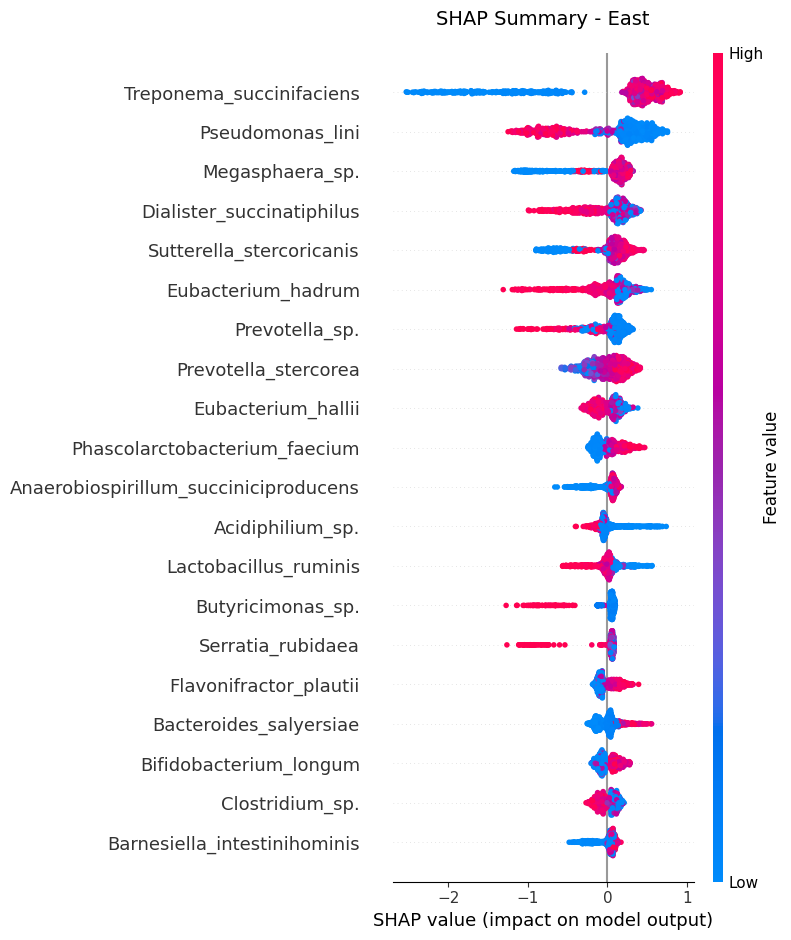

  ✅ Successfully plotted East

Processing North...
  SHAP values shape: (1004, 993)
  X shape: (1004, 993)
  Feature names: 993


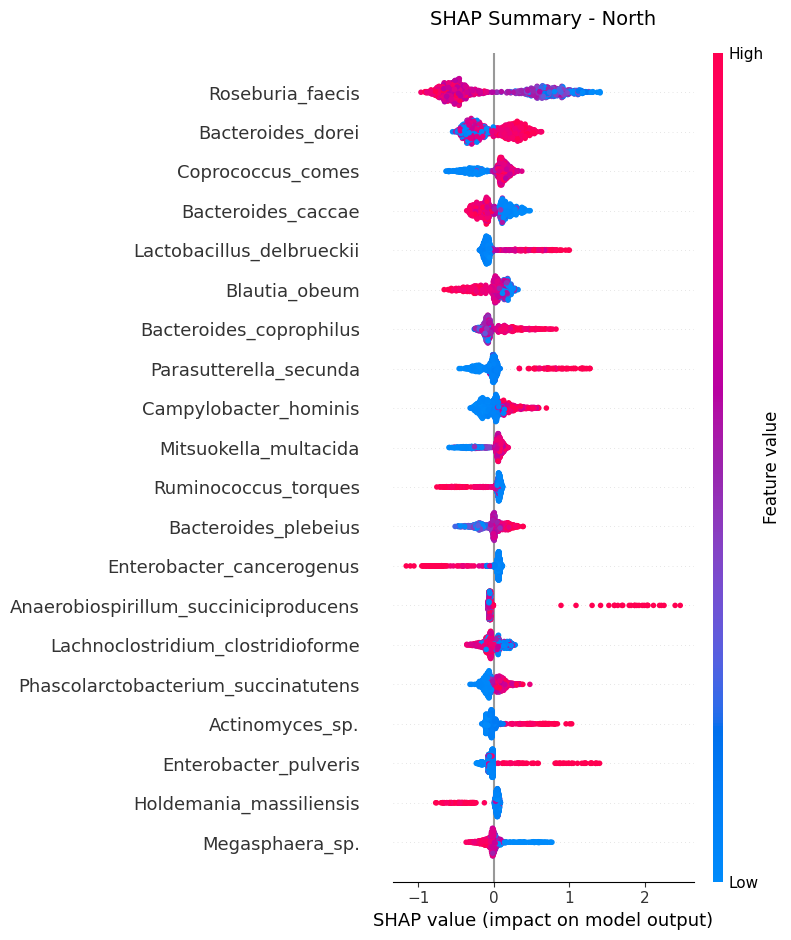

  ✅ Successfully plotted North

Processing South...
  SHAP values shape: (1004, 993)
  X shape: (1004, 993)
  Feature names: 993


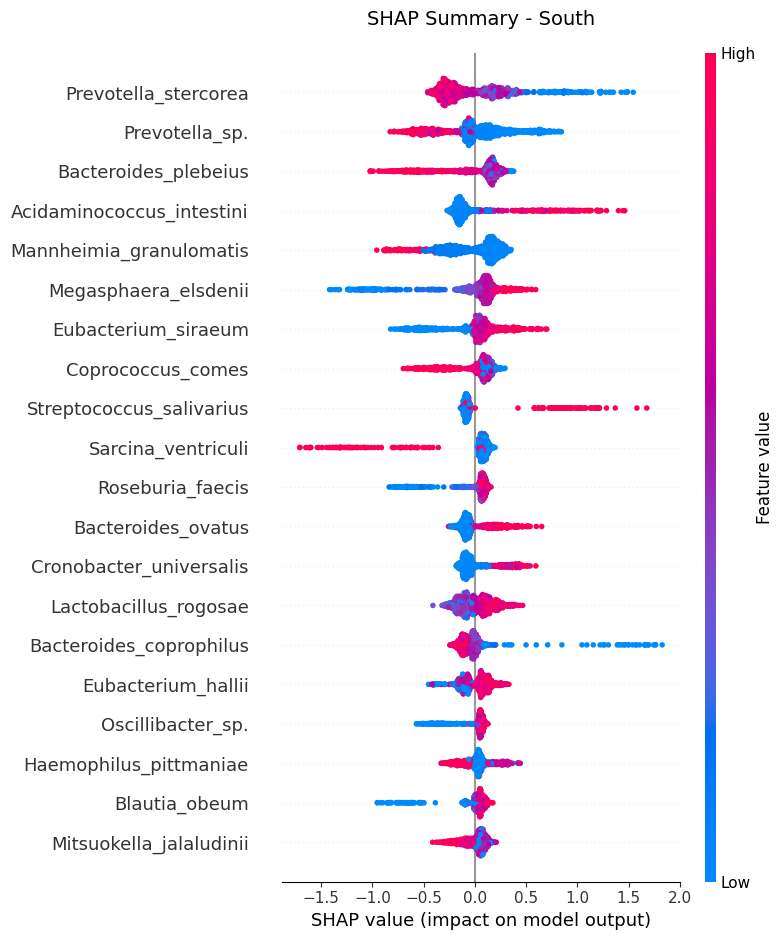

  ✅ Successfully plotted South

Processing West...
  SHAP values shape: (1004, 993)
  X shape: (1004, 993)
  Feature names: 993


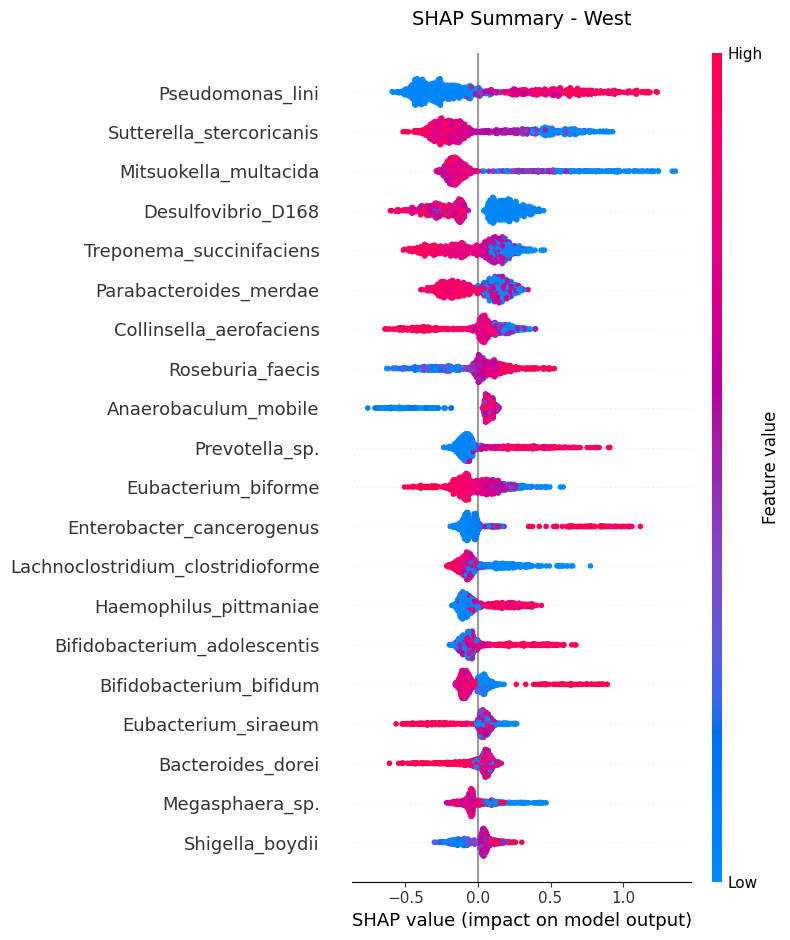

  ✅ Successfully plotted West

GENERATING FEATURE IMPORTANCE PLOT
  Including East in importance calculation
  Including North in importance calculation
  Including South in importance calculation
  Including West in importance calculation
  Averaged importance across 4 classes


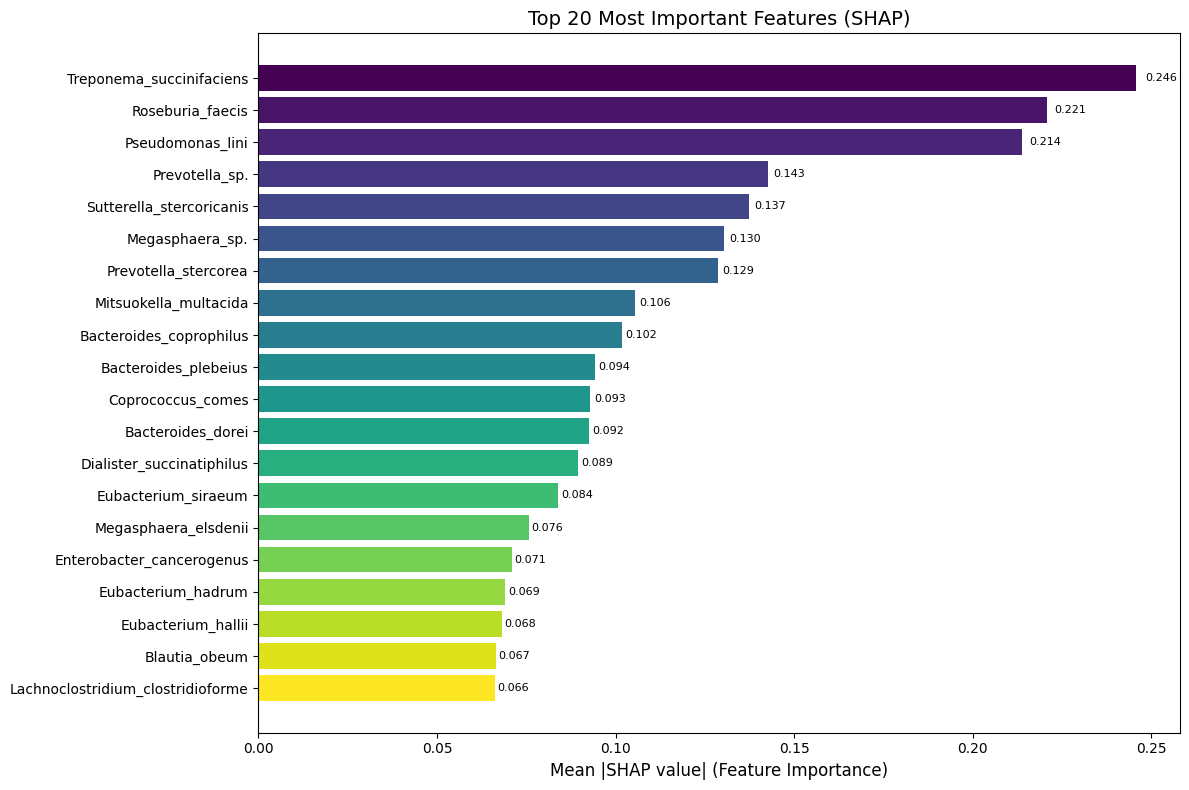

  ✅ Feature importance plot generated successfully

TOP 10 MOST IMPORTANT FEATURES
                 feature  importance
Treponema_succinifaciens    0.245709
        Roseburia_faecis    0.220624
        Pseudomonas_lini    0.213677
          Prevotella_sp.    0.142558
Sutterella_stercoricanis    0.137456
         Megasphaera_sp.    0.130446
    Prevotella_stercorea    0.128527
   Mitsuokella_multacida    0.105535
 Bacteroides_coprophilus    0.101777
    Bacteroides_plebeius    0.094195

💾 Results saved to 'shap_feature_importance.csv'

ANALYSIS COMPLETE


In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score
import lightgbm as lgb
import shap
import matplotlib.pyplot as plt
from matplotlib import rcParams

# -----------------------------
# 0. Plotting setup
# -----------------------------
rcParams['font.size'] = 10
rcParams['figure.dpi'] = 100

# -----------------------------
# 1. Data loading
# -----------------------------
otu_file = r"/home/user/Documents/Sandhya/AI_in_medicine_lab/AI project/abundance_only.xlsx"
meta_file = r"/home/user/Documents/Sandhya/AI_in_medicine_lab/AI project/metadata_only.xlsx"

otu_raw = pd.read_excel(otu_file, index_col=0)
meta_raw = pd.read_excel(meta_file)

meta = meta_raw.set_index(meta_raw.columns[0])
target_col = 'Geographical zone in India'

# Keep only samples with target info
meta = meta.dropna(subset=[target_col])
common_samples = list(set(otu_raw.index) & set(meta.index))
otu_aligned = otu_raw.loc[common_samples]
y = meta.loc[common_samples, target_col]

# -----------------------------
# 2. CLR Transformation
# -----------------------------
def centered_log_ratio(df):
    df_pseudo = df + 1e-6
    gm = np.exp(np.log(df_pseudo).mean(axis=1))
    return np.log(df_pseudo.divide(gm, axis=0))

X = centered_log_ratio(otu_aligned)

# -----------------------------
# 3. Encode target
# -----------------------------
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print("="*60)
print("DATA DIAGNOSTICS")
print("="*60)
print(f"Original data shape: {X.shape}")
print(f"Number of samples: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")
print(f"Number of classes: {len(le.classes_)}")
print(f"Classes: {le.classes_}")
print(f"Class distribution: {dict(zip(le.classes_, np.bincount(y_encoded)))}")

# -----------------------------
# 4. Train best model
# -----------------------------
best_params = {
    'learning_rate': 0.10351332282682328,
    'max_depth': 8,
    'n_estimators': 103,
    'num_leaves': 13,
    'random_state': 42
}

model = lgb.LGBMClassifier(**best_params)
X_model = X.copy()

# Cross-validation check
cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X_model, y_encoded, cv=cv_outer, scoring='accuracy', n_jobs=-1)
print(f"CV Accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

# Fit model on full data
model.fit(X_model, y_encoded)

# -----------------------------
# 5. SHAP DIAGNOSTIC SECTION
# -----------------------------
print("\n" + "="*60)
print("SHAP DIAGNOSTICS")
print("="*60)

explainer = shap.TreeExplainer(model)
print(f"TreeExplainer created successfully")
print(f"Expected value type: {type(explainer.expected_value)}")
if hasattr(explainer, 'expected_value'):
    if isinstance(explainer.expected_value, np.ndarray):
        print(f"Expected value shape: {explainer.expected_value.shape}")
    else:
        print(f"Expected value: {explainer.expected_value}")

# Calculate SHAP values
print("Calculating SHAP values...")
shap_values = explainer.shap_values(X_model)

print(f"SHAP values type: {type(shap_values)}")

if isinstance(shap_values, list):
    print(f"SHAP values is a list with {len(shap_values)} elements")
    for i, sv in enumerate(shap_values):
        print(f"  Class {i} shape: {sv.shape}")
        if sv.shape[0] != X_model.shape[0] or sv.shape[1] != X_model.shape[1]:
            print(f"    ⚠️  SHAPE MISMATCH! Expected: {X_model.shape}, Got: {sv.shape}")
elif isinstance(shap_values, np.ndarray):
    print(f"SHAP values array shape: {shap_values.shape}")
    print(f"SHAP values dimensions: {shap_values.ndim}")
    if shap_values.ndim == 3:
        print(f"3D array: (samples={shap_values.shape[0]}, classes={shap_values.shape[1]}, features={shap_values.shape[2]})")
    elif shap_values.ndim == 2:
        print(f"2D array: (samples={shap_values.shape[0]}, features={shap_values.shape[1]})")

# -----------------------------
# 6. SHAP VALUES CORRECTION
# -----------------------------
print("\n" + "="*60)
print("SHAP VALUES PROCESSING")
print("="*60)

def process_shap_values(shap_values, X_shape, n_classes):
    """Process SHAP values to ensure correct format"""
    
    if isinstance(shap_values, list):
        print("Processing list format SHAP values...")
        processed = []
        for i, sv in enumerate(shap_values):
            if sv.shape == X_shape:
                print(f"  Class {i}: Shape OK {sv.shape}")
                processed.append(sv)
            else:
                print(f"  Class {i}: Shape mismatch {sv.shape} vs {X_shape}")
                # Try to fix common issues
                if sv.shape[0] == X_shape[0] and sv.shape[1] != X_shape[1]:
                    if sv.shape[1] == X_shape[1] + 1:  # Extra column (bias term)
                        print(f"    Removing extra column (likely bias term)")
                        processed.append(sv[:, :-1])
                    elif sv.shape[1] < X_shape[1]:  # Missing features
                        print(f"    Padding with zeros for missing features")
                        padding = np.zeros((sv.shape[0], X_shape[1] - sv.shape[1]))
                        processed.append(np.hstack([sv, padding]))
                    else:
                        print(f"    Cannot fix shape mismatch")
                        processed.append(None)
                else:
                    print(f"    Cannot fix shape mismatch")
                    processed.append(None)
        return processed
    
    elif isinstance(shap_values, np.ndarray):
        if shap_values.ndim == 3:
            print(f"Processing 3D array: {shap_values.shape}")
            # (n_samples, n_features, n_classes) format
            if shap_values.shape[0] == X_shape[0] and shap_values.shape[2] == n_classes:
                print("Converting 3D to list format...")
                return [shap_values[:, :, i] for i in range(n_classes)]
            # (n_samples, n_classes, n_features) format  
            elif shap_values.shape[0] == X_shape[0] and shap_values.shape[1] == n_classes:
                print("Converting 3D (classes in middle) to list format...")
                return [shap_values[:, i, :] for i in range(n_classes)]
            else:
                print("Cannot process 3D array - unexpected dimensions")
                return None
                
        elif shap_values.ndim == 2:
            print(f"Processing 2D array: {shap_values.shape}")
            if shap_values.shape == X_shape:
                print("2D array shape matches - treating as binary classification")
                return [shap_values]
            else:
                print("2D array shape mismatch")
                return None
    
    return None

# Process the SHAP values
shap_values_processed = process_shap_values(shap_values, X_model.shape, len(le.classes_))

if shap_values_processed is None:
    print("❌ Could not process SHAP values correctly")
    exit()

# Filter out None values
shap_values_list = [sv for sv in shap_values_processed if sv is not None]
print(f"Successfully processed {len(shap_values_list)} SHAP arrays")

# -----------------------------
# 7. Utility functions
# -----------------------------
def clean_feature_names(feature_names, max_length=50):
    cleaned_names = []
    for name in feature_names:
        clean_name = str(name)
        # Remove common taxonomic prefixes
        for prefix in ['Proteobacteria_', 'Alphaproteobacteria_', 'Betaproteobacteria_', 
                       'Gammaproteobacteria_', 'Deltaproteobacteria_']:
            clean_name = clean_name.replace(prefix, '')
        # Take last 2 parts if too long
        parts = clean_name.split('_')
        if len(parts) > 3:
            clean_name = '_'.join(parts[-2:])
        if len(clean_name) > max_length:
            clean_name = clean_name[:max_length-3] + '...'
        cleaned_names.append(clean_name)
    return cleaned_names

# -----------------------------
# 8. SAFE SHAP PLOTTING
# -----------------------------
def plot_shap_summary_safe(shap_values_list, X, le, max_display=20):
    """Safe SHAP summary plotting with extensive error checking"""
    print("\n" + "="*50)
    print("GENERATING SHAP SUMMARY PLOTS")
    print("="*50)
    
    clean_names = clean_feature_names(X.columns)
    
    for i, sv in enumerate(shap_values_list):
        if sv is None:
            continue
            
        class_name = le.classes_[i] if i < len(le.classes_) else f"Class_{i}"
        print(f"\nProcessing {class_name}...")
        print(f"  SHAP values shape: {sv.shape}")
        print(f"  X shape: {X.shape}")
        print(f"  Feature names: {len(clean_names)}")
        
        # Final shape verification
        if sv.shape[1] != X.shape[1]:
            print(f"  ❌ Shape still doesn't match after processing. Skipping.")
            continue
            
        try:
            # Create temporary dataframe with correct feature names
            X_temp = pd.DataFrame(X.values, columns=clean_names, index=X.index)
            
            plt.figure(figsize=(12, 8))
            
            # Use the corrected approach - pass DataFrame directly
            shap.summary_plot(
                sv, 
                X_temp, 
                max_display=max_display, 
                show=False
            )
            
            plt.title(f'SHAP Summary - {class_name}', fontsize=14, pad=20)
            plt.tight_layout()
            plt.show()
            print(f"  ✅ Successfully plotted {class_name}")
            
        except Exception as e:
            print(f"  ❌ Error plotting {class_name}: {str(e)}")
            plt.close()

def plot_feature_importance_safe(shap_values_list, X, le, top_n=20):
    """Safe feature importance plotting"""
    print("\n" + "="*50)
    print("GENERATING FEATURE IMPORTANCE PLOT")
    print("="*50)
    
    clean_names = clean_feature_names(X.columns)
    
    # Calculate importance from valid SHAP arrays only
    valid_importance = []
    for i, sv in enumerate(shap_values_list):
        if sv is not None and sv.shape[1] == len(clean_names):
            importance = np.mean(np.abs(sv), axis=0)
            valid_importance.append(importance)
            class_name = le.classes_[i] if i < len(le.classes_) else f"Class_{i}"
            print(f"  Including {class_name} in importance calculation")
    
    if not valid_importance:
        print("❌ No valid SHAP arrays for importance calculation")
        return None
    
    # Average importance across classes
    if len(valid_importance) > 1:
        feature_importance = np.mean(valid_importance, axis=0)
        print(f"  Averaged importance across {len(valid_importance)} classes")
    else:
        feature_importance = valid_importance[0]
        print(f"  Using importance from single class")
    
    # Create DataFrame
    importance_df = pd.DataFrame({
        'feature': clean_names[:len(feature_importance)], 
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    # Plot
    plt.figure(figsize=(12, 8))
    top_features = importance_df.head(top_n)
    colors = plt.cm.viridis(np.linspace(0, 1, len(top_features)))
    
    bars = plt.barh(range(len(top_features)), top_features['importance'], color=colors)
    plt.yticks(range(len(top_features)), top_features['feature'], fontsize=10)
    plt.xlabel('Mean |SHAP value| (Feature Importance)', fontsize=12)
    plt.title(f'Top {top_n} Most Important Features (SHAP)', fontsize=14)
    plt.gca().invert_yaxis()
    
    # Add value labels
    for i, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(width + width*0.01, bar.get_y() + bar.get_height()/2, 
                f'{width:.3f}', ha='left', va='center', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    print("  ✅ Feature importance plot generated successfully")
    
    return importance_df

# -----------------------------
# 9. EXECUTE PLOTTING
# -----------------------------
if len(shap_values_list) > 0:
    # Generate plots
    plot_shap_summary_safe(shap_values_list, X_model, le, max_display=20)
    importance_df = plot_feature_importance_safe(shap_values_list, X_model, le, top_n=20)
    
    if importance_df is not None:
        print("\n" + "="*50)
        print("TOP 10 MOST IMPORTANT FEATURES")
        print("="*50)
        print(importance_df.head(10).to_string(index=False))
        
        # Save results
        importance_df.to_csv('shap_feature_importance.csv', index=False)
        print(f"\n💾 Results saved to 'shap_feature_importance.csv'")
    
else:
    print("❌ No valid SHAP values could be processed for plotting")

print("\n" + "="*60)
print("ANALYSIS COMPLETE")
print("="*60)


GENERATING SHAP VISUALIZATIONS

GENERATING PER-CLASS SHAP SUMMARY PLOTS

Processing East...


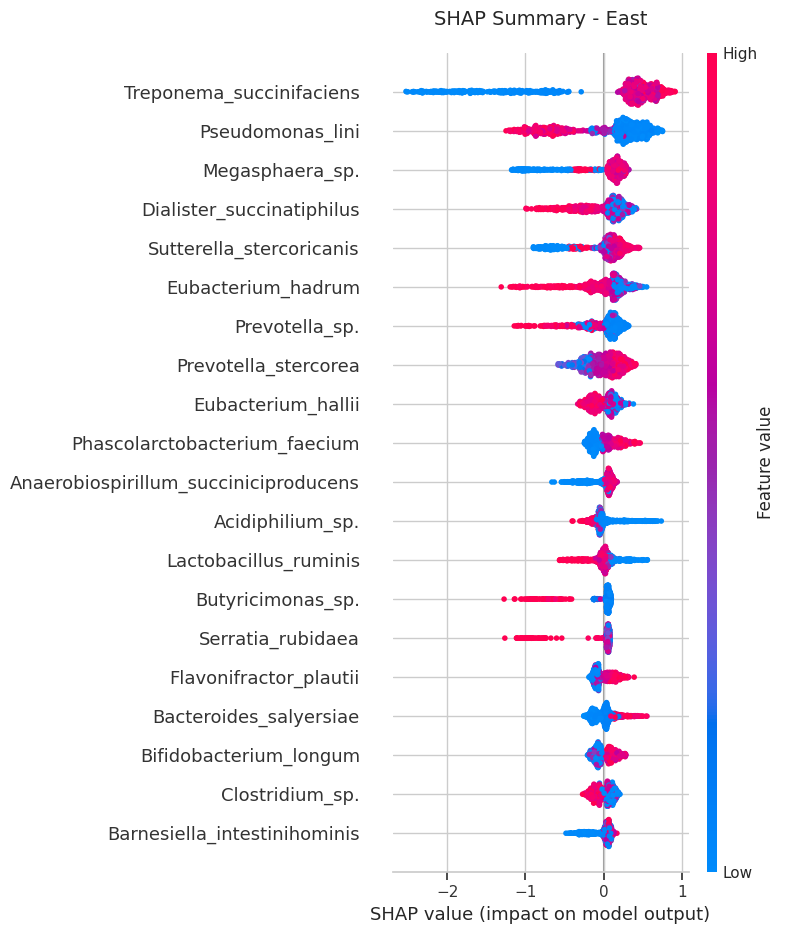

  ✅ Successfully plotted East

Processing North...


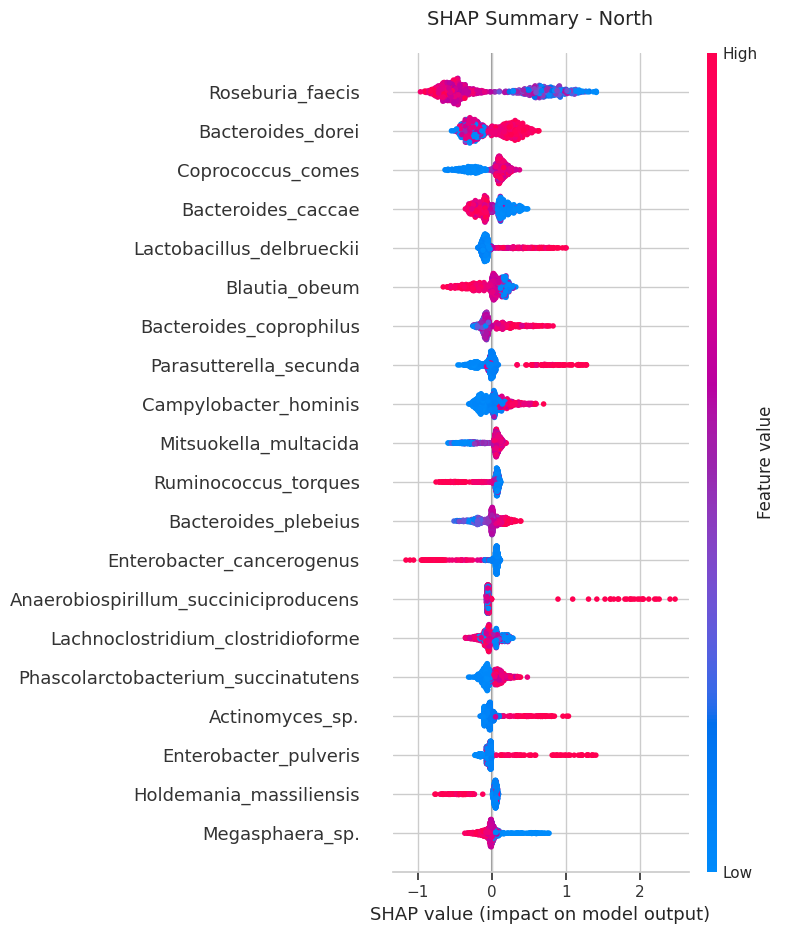

  ✅ Successfully plotted North

Processing South...


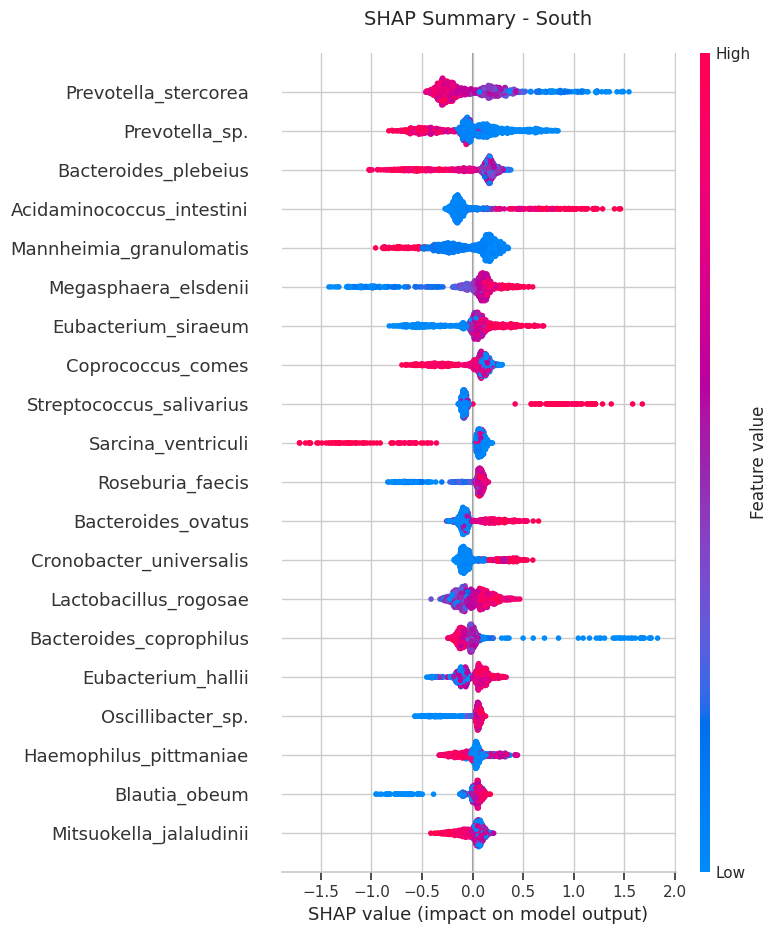

  ✅ Successfully plotted South

Processing West...


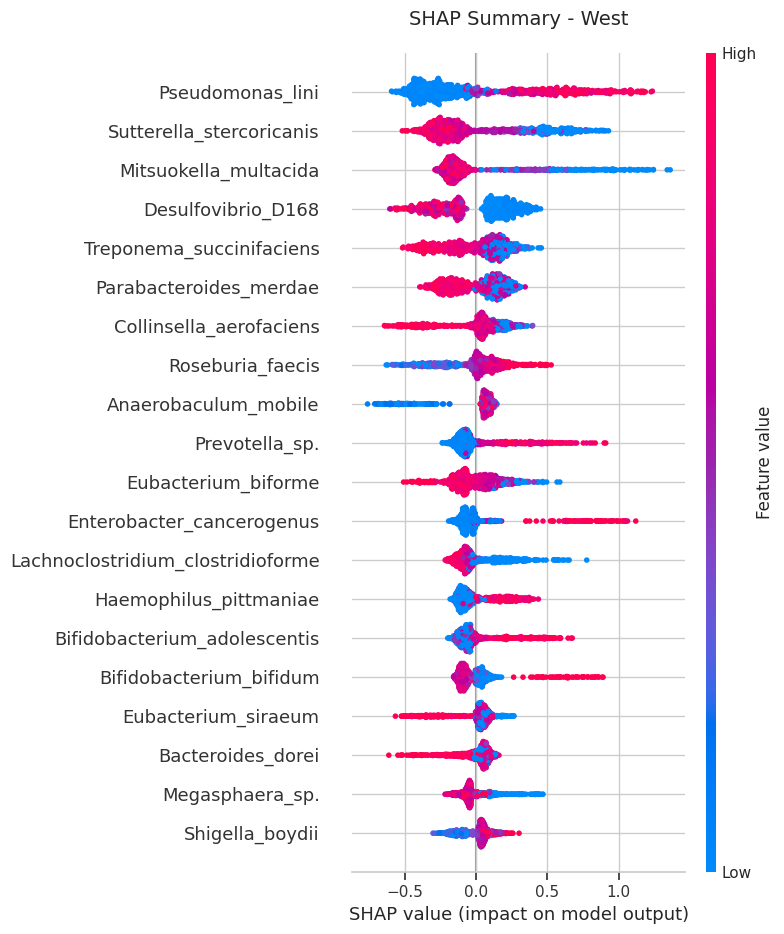

  ✅ Successfully plotted West

GENERATING MULTI-CLASS FEATURE IMPORTANCE BAR PLOT


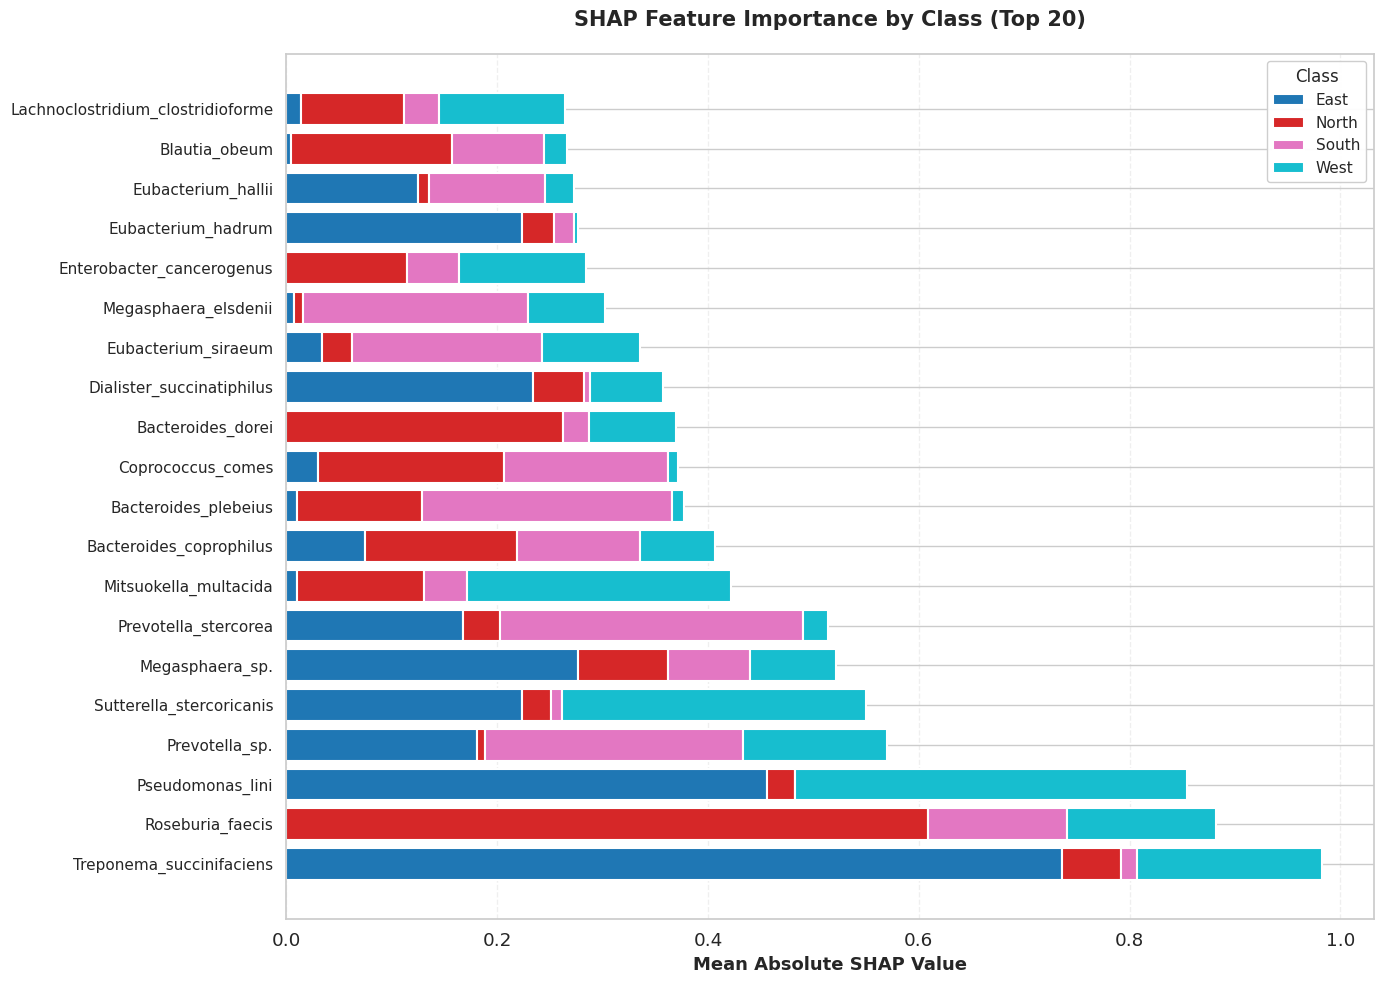

  ✅ Multi-class feature importance plot generated successfully
  📊 Saved as 'shap_feature_importance_by_class.png'

TOP 10 MOST IMPORTANT FEATURES (Overall)
                 feature  importance
Treponema_succinifaciens    0.982834
        Roseburia_faecis    0.882497
        Pseudomonas_lini    0.854709
          Prevotella_sp.    0.570231
Sutterella_stercoricanis    0.549824
         Megasphaera_sp.    0.521785
    Prevotella_stercorea    0.514109
   Mitsuokella_multacida    0.422139
 Bacteroides_coprophilus    0.407110
    Bacteroides_plebeius    0.376780

💾 Results saved to 'shap_feature_importance_overall.csv'

ANALYSIS COMPLETE


In [156]:
# =============================================================================
# 9B. CUSTOM MULTI-CLASS FEATURE IMPORTANCE BAR PLOT
# =============================================================================
def plot_feature_importance_by_class(shap_values_list, X, le, top_n=20):
    """
    Generates a horizontal stacked bar plot showing feature importance
    broken down by class contribution (similar to the provided image).
    """
    print("\n" + "="*60)
    print("GENERATING MULTI-CLASS FEATURE IMPORTANCE BAR PLOT")
    print("="*60)
    
    # Validation
    if len(shap_values_list) != len(le.classes_):
        print(f"❌ SHAP array count mismatch: Expected {len(le.classes_)}, got {len(shap_values_list)}")
        return None
    
    if not shap_values_list or shap_values_list[0].shape[1] != X.shape[1]:
        print("❌ Invalid SHAP values shape")
        return None
    
    clean_names = clean_feature_names(X.columns)
    
    try:
        # Calculate mean absolute SHAP values per class per feature
        # Shape: (n_classes, n_features)
        importance_by_class = np.array([
            np.mean(np.abs(sv), axis=0) for sv in shap_values_list
        ])
        
        # Sum across classes to get total importance per feature
        total_importance = np.sum(importance_by_class, axis=0)
        
        # Get top features
        top_indices = np.argsort(total_importance)[-top_n:][::-1]
        
        # Subset data
        importance_subset = importance_by_class[:, top_indices]  # (n_classes, top_n)
        top_features = [clean_names[i] for i in top_indices]
        
        # Create color map for classes
        colors = plt.cm.tab10(np.linspace(0, 1, len(le.classes_)))
        
        # Create figure
        fig, ax = plt.subplots(figsize=(14, 10))
        
        # Build stacked horizontal bars
        feature_range = np.arange(len(top_features))
        left = np.zeros(len(top_features))
        
        for class_idx, class_name in enumerate(le.classes_):
            values = importance_subset[class_idx, :]
            ax.barh(feature_range, values, left=left, label=class_name, 
                    color=colors[class_idx], edgecolor='white', linewidth=1.5)
            left += values
        
        # Customize plot
        ax.set_yticks(feature_range)
        ax.set_yticklabels(top_features, fontsize=11)
        ax.set_xlabel('Mean Absolute SHAP Value', fontsize=13, weight='bold')
        ax.set_title(f'SHAP Feature Importance by Class (Top {top_n})', 
                     fontsize=15, weight='bold', pad=20)
        ax.legend(title='Class', title_fontsize=12, fontsize=11, 
                  loc='upper right', framealpha=0.95)
        ax.grid(axis='x', alpha=0.3, linestyle='--')
        
        plt.tight_layout()
        plt.savefig('shap_feature_importance_by_class.png', dpi=150, bbox_inches='tight')
        plt.show()
        
        print(f"  ✅ Multi-class feature importance plot generated successfully")
        print(f"  📊 Saved as 'shap_feature_importance_by_class.png'")
        
        # Return importance dataframe
        overall_importance = pd.DataFrame({
            'feature': top_features,
            'importance': total_importance[top_indices]
        })
        
        return overall_importance
        
    except Exception as e:
        print(f"  ❌ Error generating plot: {str(e)}")
        import traceback
        traceback.print_exc()
        plt.close()
        return None


# =============================================================================
# 9. EXECUTE ALL PLOTTING
# =============================================================================
if len(shap_values_list) > 0:
    print("\n" + "="*60)
    print("GENERATING SHAP VISUALIZATIONS")
    print("="*60)
    
    # 1. Per-class summary plots (beeswarm style)
    plot_shap_summary_safe(shap_values_list, X_model, le, max_display=20)
    
    # 2. Multi-class bar plot (colored by class contribution)
    importance_df = plot_feature_importance_by_class(shap_values_list, X_model, le, top_n=20)
    
    if importance_df is not None:
        print("\n" + "="*60)
        print("TOP 10 MOST IMPORTANT FEATURES (Overall)")
        print("="*60)
        print(importance_df.head(10).to_string(index=False))
        
        # Save results
        importance_df.to_csv('shap_feature_importance_overall.csv', index=False)
        print(f"\n💾 Results saved to 'shap_feature_importance_overall.csv'")
        
else:
    print("❌ No valid SHAP values could be processed for plotting")

print("\n" + "="*60)
print("ANALYSIS COMPLETE")
print("="*60)


GENERATING TAXON → ZONE SANKEY DIAGRAM
  ✅ Sankey diagram created successfully!
  🎨 Beautiful pastel colors applied
  💾 Saved as 'sankey_taxon_zone_importance.html'
  📊 Nodes: 41 | Links: 80
  ℹ️  Install 'kaleido' for PNG export: pip install kaleido



TAXON IMPORTANCE SUMMARY
         Taxon  Features_Connected  Avg_Importance
  Spirochaetes                   2        0.455736
Proteobacteria                   8        0.257357
    Firmicutes                  18        0.203761
 Bacteroidetes                  10        0.198435
Actinobacteria                   1        0.152344
 Synergistetes                   1        0.138872

💾 Taxon summary saved to 'taxon_importance_summary.csv'

SANKEY VISUALIZATION COMPLETE! 🎉


In [197]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np
from collections import defaultdict
import re

def extract_taxon_from_feature(feature_name):
    """Extract taxonomic group (phylum/class level) from feature name"""
    if '_' in feature_name:
        return feature_name.split('_')[0].capitalize()
    else:
        return feature_name.capitalize()

def extract_genus_species(feature_name):
    """Extract only genus and species (last two words) from feature name"""
    parts = feature_name.split('_')
    if len(parts) >= 2:
        return f"{parts[-2]} {parts[-1]}"
    else:
        return feature_name

def create_taxon_zone_sankey(shap_values_list, X, le, top_n_per_class=15):
    """
    Creates a beautiful pastel Sankey diagram showing:
    Phylum → Taxa (genus_species) → Geographical Zones
    With panel headings and darker labels for better visibility
    """
    print("\n" + "="*60)
    print("GENERATING ENHANCED TAXON → ZONE SANKEY DIAGRAM")
    print("="*60)
    
    # LEFT PANEL: Cool tones for Phyla (Blues, Purples, Teals)
    pastel_taxon_colors = [
        '#ddb892',                   # Tan/Sand
        'rgba(180, 140, 255, 0.9)',  # Purple
        '#a9def9',                   # Teal
        '#ffc2d1',                   # Pink
        '#83c5be',                   # Sea green
        '#3a6ea5',                   # Dark blue
        'rgba(150, 150, 255, 0.9)',  # Periwinkle
        'rgba(130, 230, 220, 0.9)',  # Aqua
    ]
    
    # RIGHT PANEL: Warm tones for Zones (Reds, Oranges, Yellows, Greens)
    pastel_zone_colors = [
        '#ec8385',                   # Coral red (East)
        'rgba(255, 200, 80, 1)',     # Golden yellow (North)
        'rgba(255, 140, 60, 1)',     # Warm orange (West)
        'rgba(140, 220, 100, 1)',    # Fresh green (South)
    ]
    
    # Calculate mean absolute SHAP per class per feature
    importance_by_class = np.array([
        np.mean(np.abs(sv), axis=0) for sv in shap_values_list
    ])
    
    # Get top features for each class/zone
    class_top_features = {}
    for class_idx, class_name in enumerate(le.classes_):
        top_indices = np.argsort(importance_by_class[class_idx])[-top_n_per_class:][::-1]
        class_top_features[class_name] = [
            (X.columns[i], importance_by_class[class_idx][i]) 
            for i in top_indices
        ]
    
    # Build Sankey data structure
    taxon_to_features = defaultdict(list)
    feature_to_zones = defaultdict(list)
    feature_original_names = {}
    
    for zone, features in class_top_features.items():
        for feature_name, importance in features:
            taxon = extract_taxon_from_feature(feature_name)
            clean_feature = extract_genus_species(feature_name)
            feature_original_names[clean_feature] = feature_name
            taxon_to_features[taxon].append((clean_feature, importance))
            feature_to_zones[clean_feature].append((zone, importance))
    
    # Create node labels
    unique_taxa = sorted(taxon_to_features.keys())
    unique_features = sorted(feature_to_zones.keys())
    zones = list(le.classes_)
    
    all_nodes = unique_taxa + unique_features + zones
    node_dict = {node: idx for idx, node in enumerate(all_nodes)}
    
    # Create color mapping
    taxon_color_map = {taxon: pastel_taxon_colors[i % len(pastel_taxon_colors)] 
                       for i, taxon in enumerate(unique_taxa)}
    zone_color_map = {zone: pastel_zone_colors[i % len(pastel_zone_colors)] 
                      for i, zone in enumerate(zones)}
    
    # Create links with colored flows
    source = []
    target = []
    value = []
    link_colors = []
    
    # Taxon → Feature links (inherit taxon color)
    for taxon in unique_taxa:
        taxon_color_transparent = taxon_color_map[taxon].replace('0.9', '0.5')
        for feature, importance in taxon_to_features[taxon]:
            source.append(node_dict[taxon])
            target.append(node_dict[feature])
            value.append(importance)
            link_colors.append(taxon_color_transparent)
    
    # Feature → Zone links (inherit zone color)
    for feature in unique_features:
        for zone, importance in feature_to_zones[feature]:
            zone_color_transparent = zone_color_map[zone].replace('1)', '0.5)')
            source.append(node_dict[feature])
            target.append(node_dict[zone])
            value.append(importance)
            link_colors.append(zone_color_transparent)
    
    # Assign colors to nodes (darker for better visibility)
    node_colors = []
    for node in all_nodes:
        if node in unique_taxa:
            node_colors.append(taxon_color_map[node])
        elif node in zones:
            node_colors.append(zone_color_map[node])
        else:
            # Middle layer (features) - Darker gray for visibility
            node_colors.append('rgba(120, 120, 120, 0.9)')
            
    # --- START OF NODE LABEL MODIFICATION ---
    # Apply BOLD to all labels and ITALICS to the middle (Taxa) labels
    formatted_node_labels = []
    for node in all_nodes:
        # Step 1: Start with BOLD tag
        label = f"<b>{node}</b>"
        
        # Step 2: Apply ITALICS for the middle layer (Features/Taxa)
        if node in unique_features:
            label = f"<b><i>{node}</i></b>" # BOLD and ITALICS
        
        formatted_node_labels.append(label)
    # --- END OF NODE LABEL MODIFICATION ---

    # Create Sankey diagram
    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=20,
            thickness=25,
            line=dict(color="white", width=2.5),
            label=formatted_node_labels, # Use the formatted labels
            color=node_colors,
            customdata=[f"<b>{node}</b>" for node in all_nodes],
            hovertemplate='%{customdata}<br>Total Flow: %{value:.4f}<extra></extra>'
        ),
        link=dict(
            source=source,
            target=target,
            value=value,
            color=link_colors,
            hovertemplate='<b>%{source.label}</b> → <b>%{target.label}</b><br>Importance: %{value:.4f}<extra></extra>'
        )
    )])
    
    # Update layout with better title and panel headings
    fig.update_layout(
        title={
            'text': "Feature-Level Importance: Which Taxa Drive Predictions for Each Geographical Zone?",
            'font': {'size': 24, 'color': '#1a1a1a', 'family': 'Arial Black'},
            'x': 0.5,
            'xanchor': 'center',
            'y': 0.98,
            'yanchor': 'top'
        },
        # Darker font for better label visibility
        font=dict(size=12, family='Arial', color='#2C3E50'),
        plot_bgcolor='rgba(248, 249, 250, 1)',
        paper_bgcolor='white',
        height=950,
        margin=dict(l=10, r=10, t=120, b=20),
        annotations=[
            # LEFT PANEL HEADING: PHYLUM
            dict(
                text="<b>PHYLUM</b>",
                xref="paper", yref="paper",
                x=0.03, y=1.05,
                showarrow=False,
                font=dict(size=16, color='#2C3E50', family='Arial Black'),
                align='center'
            ),
            # MIDDLE PANEL HEADING: TAXA (Genus_Species)
            dict(
                text="<b>TAXA</b><br><span style='font-size:11px'>(Genus_Species)</span>",
                xref="paper", yref="paper",
                x=0.50, y=1.05,
                showarrow=False,
                font=dict(size=16, color='#2C3E50', family='Arial Black'),
                align='center'
            ),
            # RIGHT PANEL HEADING: GEOGRAPHICAL ZONE
            dict(
                text="<b>GEOGRAPHICAL ZONE</b>",
                xref="paper", yref="paper",
                x=0.99, y=1.05,
                showarrow=False,
                font=dict(size=16, color='#2C3E50', family='Arial Black'),
                align='center'
            )
        ]
    )
    
    # Save as HTML
    output_file = 'sankey_taxon_zone_importance.html'
    fig.write_html(output_file)
    print(f"  ✅ Enhanced Sankey diagram created successfully!")
    print(f"  🎨 Beautiful pastel colors with colored flows")
    print(f"  🏷️  Panel headings added: PHYLUM | TAXA | GEOGRAPHICAL ZONE")
    print(f"  📝 Middle layer shows: Genus_species only")
    print(f"  🔤 Labels are now **BOLD** (Taxa are also *Italicized*)")
    print(f"  🔢 Top {top_n_per_class} features per zone")
    print(f"  💾 Saved as '{output_file}'")
    print(f"  📊 Nodes: {len(all_nodes)} (Phyla: {len(unique_taxa)}, Taxa: {len(unique_features)}, Zones: {len(zones)})")
    print(f"  🔗 Links: {len(source)}")
    
    # Save static image if kaleido is available
    try:
        fig.write_image('sankey_taxon_zone_importance.png', width=1800, height=950, scale=2)
        print(f"  🖼️  Static PNG also saved")
    except:
        print(f"  ℹ️  Install 'kaleido' for PNG export: pip install kaleido")
    
    fig.show()
    
    # Return summary statistics
    summary = pd.DataFrame({
        'Phylum': unique_taxa,
        'Features_Connected': [len(set([f for f, _ in taxon_to_features[t]])) for t in unique_taxa],
        'Avg_Importance': [np.mean([imp for _, imp in taxon_to_features[t]]) 
                             for t in unique_taxa]
    }).sort_values('Avg_Importance', ascending=False)
    
    print("\n" + "="*60)
    print("PHYLUM IMPORTANCE SUMMARY")
    print("="*60)
    print(summary.to_string(index=False))
    
    return fig, summary


# =============================================================================
# EXECUTE SANKEY VISUALIZATION
# =============================================================================
# The execution block remains the same, assuming shap_values_list, X_model, and le are available.
if len(shap_values_list) > 0:
     sankey_fig, taxon_summary = create_taxon_zone_sankey(
         shap_values_list, 
         X_model, 
         le, 
         top_n_per_class=15 # 🔢 ADJUST THIS: Number of top features per zone
     )
    
#     # Save taxon summary
#     taxon_summary.to_csv('phylum_importance_summary.csv', index=False)
#     print(f"\n💾 Phylum summary saved to 'phylum_importance_summary.csv'")
# else:
#     print("❌ No SHAP values available for Sankey diagram")

# print("\n" + "="*60)
# print("SANKEY VISUALIZATION COMPLETE! 🎉")
# print("="*60)
# print("\n💡 TIP: Adjust 'top_n_per_class' parameter to show more/fewer features")
# print("💡 TIP: Open the HTML file in browser for interactive exploration")


GENERATING ENHANCED TAXON → ZONE SANKEY DIAGRAM
  ✅ Enhanced Sankey diagram created successfully!
  🎨 Beautiful pastel colors with colored flows
  🏷️  Panel headings added: PHYLUM | TAXA | GEOGRAPHICAL ZONE
  📝 Middle layer shows: Genus_species only
  🔤 Labels are now **BOLD** (Taxa are also *Italicized*)
  🔢 Top 15 features per zone
  💾 Saved as 'sankey_taxon_zone_importance.html'
  📊 Nodes: 55 (Phyla: 6, Taxa: 45, Zones: 4)
  🔗 Links: 120
  ℹ️  Install 'kaleido' for PNG export: pip install kaleido



PHYLUM IMPORTANCE SUMMARY
        Phylum  Features_Connected  Avg_Importance
  Spirochaetes                   1        0.455736
Proteobacteria                  12        0.185376
    Firmicutes                  20        0.179616
 Bacteroidetes                   9        0.175450
 Synergistetes                   1        0.138872
Actinobacteria                   2        0.131817


# Confusion Matrix

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score
import lightgbm as lgb
import shap
import matplotlib.pyplot as plt
from matplotlib import rcParams

# -----------------------------
# 0. Plotting setup
# -----------------------------
rcParams['font.size'] = 10
rcParams['figure.dpi'] = 100

# Custom pastel colormap
PASTEL_COLORS = ['#FFB3B3', '#FFD9B3', '#FFFFB3', '#B3FFB3', '#B3FFFF', '#B3D9FF', '#D9B3FF', '#FFB3D9']

# -----------------------------
# 1. Data loading
# -----------------------------
otu_file = r"/home/user/Documents/Sandhya/AI_in_medicine_lab/AI project/abundance_only.xlsx"
meta_file = r"/home/user/Documents/Sandhya/AI_in_medicine_lab/AI project/metadata_only.xlsx"

otu_raw = pd.read_excel(otu_file, index_col=0)
meta_raw = pd.read_excel(meta_file)

meta = meta_raw.set_index(meta_raw.columns[0])
target_col = 'Geographical zone in India'

# Keep only samples with target info
meta = meta.dropna(subset=[target_col])
common_samples = list(set(otu_raw.index) & set(meta.index))
otu_aligned = otu_raw.loc[common_samples]
y = meta.loc[common_samples, target_col]

# -----------------------------
# 2. CLR Transformation
# -----------------------------
def centered_log_ratio(df):
    df_pseudo = df + 1e-6
    gm = np.exp(np.log(df_pseudo).mean(axis=1))
    return np.log(df_pseudo.divide(gm, axis=0))

X = centered_log_ratio(otu_aligned)

# -----------------------------
# 3. Encode target
# -----------------------------
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print("="*60)
print("DATA DIAGNOSTICS")
print("="*60)
print(f"Original data shape: {X.shape}")
print(f"Number of samples: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")
print(f"Number of classes: {len(le.classes_)}")
print(f"Classes: {le.classes_}")
print(f"Class distribution: {dict(zip(le.classes_, np.bincount(y_encoded)))}")

# -----------------------------
# 4. Train best model
# -----------------------------
best_params = {
    'learning_rate': 0.10351332282682328,
    'max_depth': 8,
    'n_estimators': 103,
    'num_leaves': 13,
    'random_state': 42
}

model = lgb.LGBMClassifier(**best_params)
X_model = X.copy()

# Cross-validation check
cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X_model, y_encoded, cv=cv_outer, scoring='accuracy', n_jobs=-1)
print(f"CV Accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

# Fit model on full data
model.fit(X_model, y_encoded)

# -----------------------------
# 5. SHAP DIAGNOSTIC SECTION
# -----------------------------
print("\n" + "="*60)
print("SHAP DIAGNOSTICS")
print("="*60)

explainer = shap.TreeExplainer(model)
print(f"TreeExplainer created successfully")
print(f"Expected value type: {type(explainer.expected_value)}")
if hasattr(explainer, 'expected_value'):
    if isinstance(explainer.expected_value, np.ndarray):
        print(f"Expected value shape: {explainer.expected_value.shape}")
    else:
        print(f"Expected value: {explainer.expected_value}")

# Calculate SHAP values
print("Calculating SHAP values...")
shap_values = explainer.shap_values(X_model)

print(f"SHAP values type: {type(shap_values)}")

if isinstance(shap_values, list):
    print(f"SHAP values is a list with {len(shap_values)} elements")
    for i, sv in enumerate(shap_values):
        print(f"  Class {i} shape: {sv.shape}")
        if sv.shape[0] != X_model.shape[0] or sv.shape[1] != X_model.shape[1]:
            print(f"    ⚠️  SHAPE MISMATCH! Expected: {X_model.shape}, Got: {sv.shape}")
elif isinstance(shap_values, np.ndarray):
    print(f"SHAP values array shape: {shap_values.shape}")
    print(f"SHAP values dimensions: {shap_values.ndim}")
    if shap_values.ndim == 3:
        print(f"3D array: (samples={shap_values.shape[0]}, classes={shap_values.shape[1]}, features={shap_values.shape[2]})")
    elif shap_values.ndim == 2:
        print(f"2D array: (samples={shap_values.shape[0]}, features={shap_values.shape[1]})")

# -----------------------------
# 6. SHAP VALUES CORRECTION
# -----------------------------
print("\n" + "="*60)
print("SHAP VALUES PROCESSING")
print("="*60)

def process_shap_values(shap_values, X_shape, n_classes):
    """Process SHAP values to ensure correct format"""
    
    if isinstance(shap_values, list):
        print("Processing list format SHAP values...")
        processed = []
        for i, sv in enumerate(shap_values):
            if sv.shape == X_shape:
                print(f"  Class {i}: Shape OK {sv.shape}")
                processed.append(sv)
            else:
                print(f"  Class {i}: Shape mismatch {sv.shape} vs {X_shape}")
                # Try to fix common issues
                if sv.shape[0] == X_shape[0] and sv.shape[1] != X_shape[1]:
                    if sv.shape[1] == X_shape[1] + 1:  # Extra column (bias term)
                        print(f"    Removing extra column (likely bias term)")
                        processed.append(sv[:, :-1])
                    elif sv.shape[1] < X_shape[1]:  # Missing features
                        print(f"    Padding with zeros for missing features")
                        padding = np.zeros((sv.shape[0], X_shape[1] - sv.shape[1]))
                        processed.append(np.hstack([sv, padding]))
                    else:
                        print(f"    Cannot fix shape mismatch")
                        processed.append(None)
                else:
                    print(f"    Cannot fix shape mismatch")
                    processed.append(None)
        return processed
    
    elif isinstance(shap_values, np.ndarray):
        if shap_values.ndim == 3:
            print(f"Processing 3D array: {shap_values.shape}")
            # (n_samples, n_features, n_classes) format
            if shap_values.shape[0] == X_shape[0] and shap_values.shape[2] == n_classes:
                print("Converting 3D to list format...")
                return [shap_values[:, :, i] for i in range(n_classes)]
            # (n_samples, n_classes, n_features) format  
            elif shap_values.shape[0] == X_shape[0] and shap_values.shape[1] == n_classes:
                print("Converting 3D (classes in middle) to list format...")
                return [shap_values[:, i, :] for i in range(n_classes)]
            else:
                print("Cannot process 3D array - unexpected dimensions")
                return None
                
        elif shap_values.ndim == 2:
            print(f"Processing 2D array: {shap_values.shape}")
            if shap_values.shape == X_shape:
                print("2D array shape matches - treating as binary classification")
                return [shap_values]
            else:
                print("2D array shape mismatch")
                return None
    
    return None

# Process the SHAP values
shap_values_processed = process_shap_values(shap_values, X_model.shape, len(le.classes_))

if shap_values_processed is None:
    print("❌ Could not process SHAP values correctly")
    exit()

# Filter out None values
shap_values_list = [sv for sv in shap_values_processed if sv is not None]
print(f"Successfully processed {len(shap_values_list)} SHAP arrays")

# -----------------------------
# 7. Utility functions
# -----------------------------
def clean_feature_names(feature_names, max_length=50):
    cleaned_names = []
    for name in feature_names:
        clean_name = str(name)
        # Remove common taxonomic prefixes
        for prefix in ['Proteobacteria_', 'Alphaproteobacteria_', 'Betaproteobacteria_', 
                       'Gammaproteobacteria_', 'Deltaproteobacteria_']:
            clean_name = clean_name.replace(prefix, '')
        # Take last 2 parts if too long
        parts = clean_name.split('_')
        if len(parts) > 3:
            clean_name = '_'.join(parts[-2:])
        if len(clean_name) > max_length:
            clean_name = clean_name[:max_length-3] + '...'
        cleaned_names.append(clean_name)
    return cleaned_names

# -----------------------------
# 8. SAFE SHAP PLOTTING
# -----------------------------
def plot_shap_summary_safe(shap_values_list, X, le, max_display=20):
    """Safe SHAP summary plotting with extensive error checking and pastel colors"""
    print("\n" + "="*50)
    print("GENERATING SHAP SUMMARY PLOTS")
    print("="*50)
    
    clean_names = clean_feature_names(X.columns)
    
    for i, sv in enumerate(shap_values_list):
        if sv is None:
            continue
            
        class_name = le.classes_[i] if i < len(le.classes_) else f"Class_{i}"
        print(f"\nProcessing {class_name}...")
        print(f"  SHAP values shape: {sv.shape}")
        print(f"  X shape: {X.shape}")
        print(f"  Feature names: {len(clean_names)}")
        
        # Final shape verification
        if sv.shape[1] != X.shape[1]:
            print(f"  ❌ Shape still doesn't match after processing. Skipping.")
            continue
            
        try:
            # Create temporary dataframe with correct feature names
            X_temp = pd.DataFrame(X.values, columns=clean_names, index=X.index)
            
            plt.figure(figsize=(12, 8))
            
            # Use the corrected approach - pass DataFrame directly
            shap.summary_plot(
                sv, 
                X_temp, 
                max_display=max_display, 
                show=False,
                color_bar_label='Feature Value'
            )
            
            # Apply pastel color to the colorbar
            ax = plt.gca()
            for collection in ax.collections:
                collection.set_cmap('pastel1')
            
            plt.title(f'SHAP Summary - {class_name}', fontsize=14, pad=20)
            plt.tight_layout()
            plt.show()
            print(f"  ✅ Successfully plotted {class_name}")
            
        except Exception as e:
            print(f"  ❌ Error plotting {class_name}: {str(e)}")
            plt.close()

def plot_feature_importance_safe(shap_values_list, X, le, top_n=20):
    """Safe feature importance plotting with pastel colors"""
    print("\n" + "="*50)
    print("GENERATING FEATURE IMPORTANCE PLOT")
    print("="*50)
    
    clean_names = clean_feature_names(X.columns)
    
    # Calculate importance from valid SHAP arrays only
    valid_importance = []
    for i, sv in enumerate(shap_values_list):
        if sv is not None and sv.shape[1] == len(clean_names):
            importance = np.mean(np.abs(sv), axis=0)
            valid_importance.append(importance)
            class_name = le.classes_[i] if i < len(le.classes_) else f"Class_{i}"
            print(f"  Including {class_name} in importance calculation")
    
    if not valid_importance:
        print("❌ No valid SHAP arrays for importance calculation")
        return None
    
    # Average importance across classes
    if len(valid_importance) > 1:
        feature_importance = np.mean(valid_importance, axis=0)
        print(f"  Averaged importance across {len(valid_importance)} classes")
    else:
        feature_importance = valid_importance[0]
        print(f"  Using importance from single class")
    
    # Create DataFrame
    importance_df = pd.DataFrame({
        'feature': clean_names[:len(feature_importance)], 
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    # Plot with pastel colors
    plt.figure(figsize=(12, 8))
    top_features = importance_df.head(top_n)
    pastel_colors_extended = (PASTEL_COLORS * ((top_n // len(PASTEL_COLORS)) + 1))[:top_n]
    
    bars = plt.barh(range(len(top_features)), top_features['importance'], color=pastel_colors_extended)
    plt.yticks(range(len(top_features)), top_features['feature'], fontsize=10)
    plt.xlabel('Mean |SHAP value| (Feature Importance)', fontsize=12)
    plt.title(f'Top {top_n} Most Important Features (SHAP)', fontsize=14)
    plt.gca().invert_yaxis()
    
    # Add value labels
    for i, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(width + width*0.01, bar.get_y() + bar.get_height()/2, 
                f'{width:.3f}', ha='left', va='center', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    print("  ✅ Feature importance plot generated successfully")
    
    return importance_df

# -----------------------------
# 9. EXECUTE PLOTTING
# -----------------------------
if len(shap_values_list) > 0:
    # Generate plots
    plot_shap_summary_safe(shap_values_list, X_model, le, max_display=20)
    importance_df = plot_feature_importance_safe(shap_values_list, X_model, le, top_n=20)
    
    if importance_df is not None:
        print("\n" + "="*50)
        print("TOP 10 MOST IMPORTANT FEATURES")
        print("="*50)
        print(importance_df.head(10).to_string(index=False))
        
        # Save results
        importance_df.to_csv('shap_feature_importance.csv', index=False)
        print(f"\n💾 Results saved to 'shap_feature_importance.csv'")
    
else:
    print("❌ No valid SHAP values could be processed for plotting")

print("\n" + "="*60)
print("ANALYSIS COMPLETE")
print("="*60)

DATA DIAGNOSTICS
Original data shape: (1004, 993)
Number of samples: 1004
Number of features: 993
Number of classes: 4
Classes: ['East' 'North' 'South' 'West']
Class distribution: {'East': 250, 'North': 243, 'South': 250, 'West': 261}
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091754 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 253043
[Ligh

KeyboardInterrupt: 


Plotting CV Confusion Matrices with Absolute Intensity Gradient...


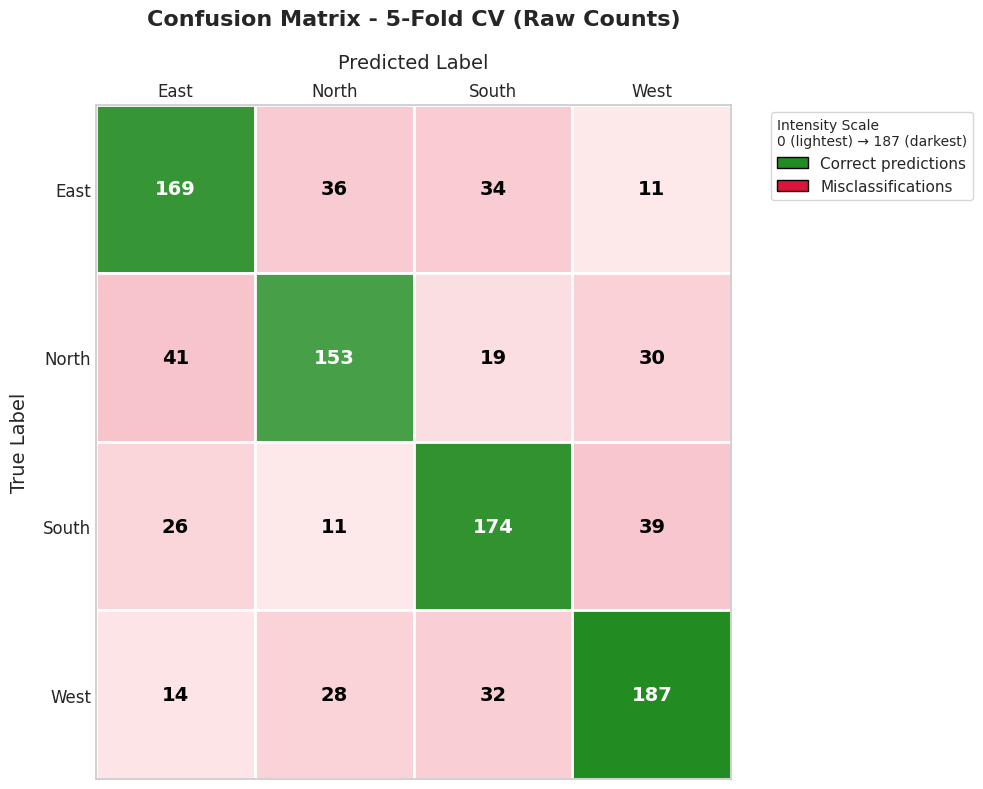

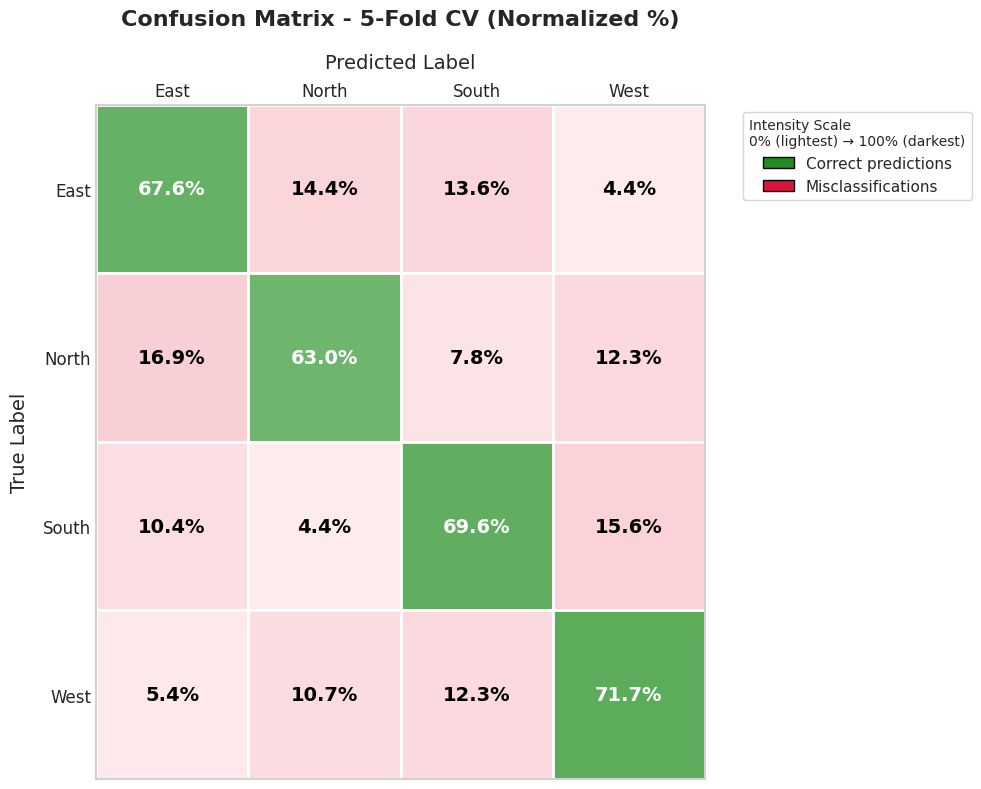

✅ CV confusion matrix plots displayed

Training on Full Data...


NotFittedError: Estimator not fitted, call fit before exploiting the model.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap, to_rgb

def plot_confusion_matrix_custom(cm, class_labels, title, normalize=False, figsize=(10, 8)):
    """
    Plot confusion matrix with gradient coloring:
    - Diagonal elements: light pastel green → deep green (based on value)
    - Off-diagonal elements: light pastel red → deep red (based on value)
    """
    # Define color gradients
    # Green gradient for diagonal (correct predictions)
    green_light = np.array([240, 255, 240]) / 255.0   # Very light pastel green
    green_dark = np.array([34, 139, 34]) / 255.0      # Deep forest green
    
    # Red gradient for off-diagonal (errors)
    red_light = np.array([255, 245, 245]) / 255.0     # Very light pastel red
    red_dark = np.array([220, 20, 60]) / 255.0        # Deep crimson
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Normalize if requested
    if normalize:
        cm_display = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm_display = np.round(cm_display * 100, 2)  # Convert to percentage
        fmt = '.2f'
        annot_suffix = '%'
    else:
        cm_display = cm
        fmt = 'd'
        annot_suffix = ''
    
    n_classes = len(class_labels)
    
    # Calculate separate max values for diagonal and off-diagonal
    diagonal_values = [cm_display[i, i] for i in range(n_classes)]
    offdiag_values = [cm_display[i, j] for i in range(n_classes) for j in range(n_classes) if i != j]
    
    max_diagonal = max(diagonal_values) if diagonal_values else 1
    max_offdiag = max(offdiag_values) if offdiag_values else 1
    
    # Avoid division by zero
    max_diagonal = max_diagonal if max_diagonal > 0 else 1
    max_offdiag = max_offdiag if max_offdiag > 0 else 1
    
    # Plot each cell
    for i in range(n_classes):
        for j in range(n_classes):
            value = cm_display[i, j]
            
            if i == j:  # Diagonal - green gradient
                # Normalize value relative to max diagonal value
                intensity = value / max_diagonal
                # Interpolate between light and dark green
                color = green_light + intensity * (green_dark - green_light)
            else:  # Off-diagonal - red gradient
                # Normalize value relative to max off-diagonal value
                intensity = value / max_offdiag
                # Interpolate between light and dark red
                color = red_light + intensity * (red_dark - red_light)
            
            # Draw rectangle with gradient color
            rect = plt.Rectangle((j, i), 1, 1, 
                                facecolor=color,
                                edgecolor='white',
                                linewidth=2)
            ax.add_patch(rect)
            
            # Add text annotation
            if normalize:
                text = f'{value:.1f}{annot_suffix}'
            else:
                text = f'{int(value)}'
            
            # Choose text color based on intensity
            # Use white text for darker colors (high intensity)
            text_color = 'white' if intensity > 0.5 else 'black'
            
            ax.text(j + 0.5, i + 0.5, text,
                   ha='center', va='center',
                   fontsize=14, weight='bold',
                   color=text_color)
    
    # Set axis properties
    ax.set_xlim(0, n_classes)
    ax.set_ylim(0, n_classes)
    ax.set_xticks(np.arange(n_classes) + 0.5)
    ax.set_yticks(np.arange(n_classes) + 0.5)
    ax.set_xticklabels(class_labels, fontsize=12)
    ax.set_yticklabels(class_labels, fontsize=12)
    
    # Move x-axis to top
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    ax.tick_params(length=0)
    
    # Invert y-axis to have [0,0] at top-left
    ax.invert_yaxis()
    
    # Labels and title
    ax.set_xlabel('Predicted Label', fontsize=14, labelpad=10)
    ax.set_ylabel('True Label', fontsize=14, labelpad=10)
    ax.set_title(title, fontsize=16, pad=20, weight='bold')
    
    # Add gradient legend bars
    from matplotlib.patches import Rectangle as LegendRect
    from matplotlib.patches import Patch
    
    # Create custom legend with gradient visualization
    legend_elements = []
    
    # Green gradient bar
    green_patch = Patch(facecolor=green_dark, edgecolor='black', linewidth=1,
                       label=f'Correct (max: {max_diagonal:.1f}{annot_suffix})')
    legend_elements.append(green_patch)
    
    # Red gradient bar
    red_patch = Patch(facecolor=red_dark, edgecolor='black', linewidth=1,
                     label=f'Errors (max: {max_offdiag:.1f}{annot_suffix})')
    legend_elements.append(red_patch)
    
    ax.legend(handles=legend_elements, loc='upper left', 
             bbox_to_anchor=(1.05, 1), fontsize=11,
             title='Gradient Scale', title_fontsize=12)
    
    plt.tight_layout()
    return fig, ax

# =============================================================================
# MAIN PLOTTING CODE
# =============================================================================

print("\nPlotting CV Confusion Matrices with Gradient Colors...")

# ---------- Raw Counts Matrix (CV) ----------
fig, ax = plot_confusion_matrix_custom(
    cm_cv,
    class_labels=le.classes_,
    title='Confusion Matrix - 5-Fold CV (Raw Counts)',
    normalize=False,
    figsize=(10, 8)
)
plt.show()

# ---------- Normalized Matrix (CV) ----------
fig, ax = plot_confusion_matrix_custom(
    cm_cv,
    class_labels=le.classes_,
    title='Confusion Matrix - 5-Fold CV (Normalized %)',
    normalize=True,
    figsize=(10, 8)
)
plt.show()

print("✅ CV confusion matrix plots displayed")

# ---------- Full Data Confusion Matrix ----------
print("\nTraining on Full Data...")
y_pred_full = model.predict(X_model)
cm_full = confusion_matrix(y_encoded, y_pred_full)
full_accuracy = accuracy_score(y_encoded, y_pred_full)

print(f"\nFull Data Confusion Matrix:")
print(cm_full)
print(f"Full Data Accuracy: {full_accuracy:.4f}")

cm_full_normalized = cm_full.astype('float') / cm_full.sum(axis=1)[:, np.newaxis]

# Save full data results
cm_full_df = pd.DataFrame(
    cm_full,
    index=[f'True {label}' for label in le.classes_],
    columns=[f'Pred {label}' for label in le.classes_]
)
cm_full_df.to_csv('confusion_matrix_full_data.csv')
print("✅ Saved: confusion_matrix_full_data.csv")

cm_full_norm_df = pd.DataFrame(
    cm_full_normalized,
    index=[f'True {label}' for label in le.classes_],
    columns=[f'Pred {label}' for label in le.classes_]
)
cm_full_norm_df.to_csv('confusion_matrix_normalized_full_data.csv')
print("✅ Saved: confusion_matrix_normalized_full_data.csv")

# ---------- Full Data Raw Counts ----------
fig, ax = plot_confusion_matrix_custom(
    cm_full,
    class_labels=le.classes_,
    title='Confusion Matrix - Full Data (Raw Counts)',
    normalize=False,
    figsize=(10, 8)
)
plt.show()

# ---------- Full Data Normalized ----------
fig, ax = plot_confusion_matrix_custom(
    cm_full,
    class_labels=le.classes_,
    title='Confusion Matrix - Full Data (Normalized %)',
    normalize=True,
    figsize=(10, 8)
)
plt.show()

print("✅ Full data confusion matrix plots displayed")

# =============================================================================
# BONUS: Side-by-side comparison with gradients
# =============================================================================
print("\nCreating side-by-side comparison with gradient colors...")

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Color definitions
green_light = np.array([240, 255, 240]) / 255.0
green_dark = np.array([34, 139, 34]) / 255.0
red_light = np.array([255, 245, 245]) / 255.0
red_dark = np.array([220, 20, 60]) / 255.0

n_classes = len(le.classes_)

# Left: CV Results
ax1 = axes[0]
cm_display = np.round(cm_cv_normalized * 100, 2)

# Calculate max values for CV
diagonal_vals = [cm_display[i, i] for i in range(n_classes)]
offdiag_vals = [cm_display[i, j] for i in range(n_classes) for j in range(n_classes) if i != j]
max_diag = max(diagonal_vals) if diagonal_vals else 1
max_off = max(offdiag_vals) if offdiag_vals else 1

for i in range(n_classes):
    for j in range(n_classes):
        value = cm_display[i, j]
        
        if i == j:
            intensity = value / max_diag
            color = green_light + intensity * (green_dark - green_light)
        else:
            intensity = value / max_off
            color = red_light + intensity * (red_dark - red_light)
        
        rect = plt.Rectangle((j, i), 1, 1, facecolor=color, 
                            edgecolor='white', linewidth=2)
        ax1.add_patch(rect)
        
        text_color = 'white' if intensity > 0.5 else 'black'
        ax1.text(j + 0.5, i + 0.5, f'{value:.1f}%',
               ha='center', va='center', fontsize=12, weight='bold',
               color=text_color)

ax1.set_xlim(0, n_classes)
ax1.set_ylim(0, n_classes)
ax1.set_xticks(np.arange(n_classes) + 0.5)
ax1.set_yticks(np.arange(n_classes) + 0.5)
ax1.set_xticklabels(le.classes_, fontsize=11)
ax1.set_yticklabels(le.classes_, fontsize=11)
ax1.xaxis.tick_top()
ax1.xaxis.set_label_position('top')
ax1.tick_params(length=0)
ax1.invert_yaxis()
ax1.set_xlabel('Predicted', fontsize=12, labelpad=8)
ax1.set_ylabel('True', fontsize=12, labelpad=8)
ax1.set_title('5-Fold Cross-Validation', fontsize=14, weight='bold', pad=15)

# Right: Full Data Results
ax2 = axes[1]
cm_display2 = np.round(cm_full_normalized * 100, 2)

# Calculate max values for Full Data
diagonal_vals2 = [cm_display2[i, i] for i in range(n_classes)]
offdiag_vals2 = [cm_display2[i, j] for i in range(n_classes) for j in range(n_classes) if i != j]
max_diag2 = max(diagonal_vals2) if diagonal_vals2 else 1
max_off2 = max(offdiag_vals2) if offdiag_vals2 else 1

for i in range(n_classes):
    for j in range(n_classes):
        value = cm_display2[i, j]
        
        if i == j:
            intensity = value / max_diag2
            color = green_light + intensity * (green_dark - green_light)
        else:
            intensity = value / max_off2
            color = red_light + intensity * (red_dark - red_light)
        
        rect = plt.Rectangle((j, i), 1, 1, facecolor=color,
                            edgecolor='white', linewidth=2)
        ax2.add_patch(rect)
        
        text_color = 'white' if intensity > 0.5 else 'black'
        ax2.text(j + 0.5, i + 0.5, f'{value:.1f}%',
               ha='center', va='center', fontsize=12, weight='bold',
               color=text_color)

ax2.set_xlim(0, n_classes)
ax2.set_ylim(0, n_classes)
ax2.set_xticks(np.arange(n_classes) + 0.5)
ax2.set_yticks(np.arange(n_classes) + 0.5)
ax2.set_xticklabels(le.classes_, fontsize=11)
ax2.set_yticklabels(le.classes_, fontsize=11)
ax2.xaxis.tick_top()
ax2.xaxis.set_label_position('top')
ax2.tick_params(length=0)
ax2.invert_yaxis()
ax2.set_xlabel('Predicted', fontsize=12, labelpad=8)
ax2.set_ylabel('True', fontsize=12, labelpad=8)
ax2.set_title('Full Dataset', fontsize=14, weight='bold', pad=15)

plt.suptitle('Model Performance Comparison (Normalized %)', 
            fontsize=16, weight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("✅ Side-by-side comparison displayed with gradient colors")
print("\n" + "="*60)
print("GRADIENT COLOR SCHEME:")
print("="*60)
print("✓ Diagonal (Correct): Light pastel green → Deep forest green")
print("✓ Off-diagonal (Errors): Light pastel red → Deep crimson")
print("✓ Color intensity proportional to value magnitude")
print("="*60) # ---------- Ful

Summary Statistics

In [62]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix
)

# =============================================================================
# COMPUTE METRICS FOR EACH CV FOLD
# =============================================================================

print("Computing metrics for each CV fold...")
print("="*70)

# Storage for metrics across folds
cv_metrics = {
    'fold': [],
    'accuracy': [],
    'precision_macro': [],
    'precision_weighted': [],
    'recall_macro': [],
    'recall_weighted': [],
    'f1_macro': [],
    'f1_weighted': [],
    'ppv_macro': [],  # Positive Predictive Value (same as precision)
    'ppv_weighted': [],
    'npv_macro': [],  # Negative Predictive Value
    'npv_weighted': []
}

# Assuming you have cv_results from cross_val_predict or similar
# We'll compute metrics for each fold
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_num = 1
for train_idx, val_idx in skf.split(X_model, y_encoded):
    # Use .iloc for pandas DataFrame indexing, or .values if it's a numpy array
    if isinstance(X_model, pd.DataFrame):
        X_train_fold, X_val_fold = X_model.iloc[train_idx], X_model.iloc[val_idx]
    else:
        X_train_fold, X_val_fold = X_model[train_idx], X_model[val_idx]
    
    # Handle y_encoded (works for both numpy arrays and pandas Series)
    if isinstance(y_encoded, pd.Series):
        y_train_fold, y_val_fold = y_encoded.iloc[train_idx], y_encoded.iloc[val_idx]
    else:
        y_train_fold, y_val_fold = y_encoded[train_idx], y_encoded[val_idx]
    
    # Train model on this fold
    model.fit(X_train_fold, y_train_fold)
    y_pred_fold = model.predict(X_val_fold)
    
    # Compute metrics
    acc = accuracy_score(y_val_fold, y_pred_fold)
    
    # Precision (PPV - Positive Predictive Value)
    prec_macro = precision_score(y_val_fold, y_pred_fold, average='macro', zero_division=0)
    prec_weighted = precision_score(y_val_fold, y_pred_fold, average='weighted', zero_division=0)
    
    # Recall (Sensitivity)
    rec_macro = recall_score(y_val_fold, y_pred_fold, average='macro', zero_division=0)
    rec_weighted = recall_score(y_val_fold, y_pred_fold, average='weighted', zero_division=0)
    
    # F1 Score
    f1_macro = f1_score(y_val_fold, y_pred_fold, average='macro', zero_division=0)
    f1_weighted = f1_score(y_val_fold, y_pred_fold, average='weighted', zero_division=0)
    
    # NPV (Negative Predictive Value) - computed per class then averaged
    cm_fold = confusion_matrix(y_val_fold, y_pred_fold)
    n_classes = len(np.unique(y_encoded))
    
    npv_per_class = []
    for i in range(n_classes):
        # True Negatives: all correct predictions except for class i
        tn = np.sum(cm_fold) - np.sum(cm_fold[i, :]) - np.sum(cm_fold[:, i]) + cm_fold[i, i]
        # False Negatives: predicted not class i, but actually class i
        fn = np.sum(cm_fold[i, :]) - cm_fold[i, i]
        
        # NPV = TN / (TN + FN)
        if (tn + fn) > 0:
            npv = tn / (tn + fn)
        else:
            npv = 0
        npv_per_class.append(npv)
    
    npv_macro = np.mean(npv_per_class)
    # Weighted NPV by support
    support = np.sum(cm_fold, axis=1)
    npv_weighted = np.average(npv_per_class, weights=support)
    
    # Store metrics
    cv_metrics['fold'].append(fold_num)
    cv_metrics['accuracy'].append(acc)
    cv_metrics['precision_macro'].append(prec_macro)
    cv_metrics['precision_weighted'].append(prec_weighted)
    cv_metrics['recall_macro'].append(rec_macro)
    cv_metrics['recall_weighted'].append(rec_weighted)
    cv_metrics['f1_macro'].append(f1_macro)
    cv_metrics['f1_weighted'].append(f1_weighted)
    cv_metrics['ppv_macro'].append(prec_macro)  # PPV is same as Precision
    cv_metrics['ppv_weighted'].append(prec_weighted)
    cv_metrics['npv_macro'].append(npv_macro)
    cv_metrics['npv_weighted'].append(npv_weighted)
    
    print(f"Fold {fold_num}: Accuracy={acc:.4f}, Precision(macro)={prec_macro:.4f}, "
          f"Recall(macro)={rec_macro:.4f}, F1(macro)={f1_macro:.4f}")
    
    fold_num += 1

print("="*70)
print("✅ Completed metrics computation for all 5 folds\n")

# =============================================================================
# CREATE SUMMARY STATISTICS TABLE
# =============================================================================

print("Computing summary statistics (mean, std, min, max)...\n")

summary_data = []

metrics_to_summarize = [
    ('Accuracy', 'accuracy'),
    ('Precision (Macro)', 'precision_macro'),
    ('Precision (Weighted)', 'precision_weighted'),
    ('Recall (Macro)', 'recall_macro'),
    ('Recall (Weighted)', 'recall_weighted'),
    ('F1 Score (Macro)', 'f1_macro'),
    ('F1 Score (Weighted)', 'f1_weighted'),
    ('PPV (Macro)', 'ppv_macro'),
    ('PPV (Weighted)', 'ppv_weighted'),
    ('NPV (Macro)', 'npv_macro'),
    ('NPV (Weighted)', 'npv_weighted')
]

for metric_name, metric_key in metrics_to_summarize:
    values = cv_metrics[metric_key]
    summary_data.append({
        'Metric': metric_name,
        'Mean': np.mean(values),
        'Std Dev': np.std(values, ddof=1),  # Sample std dev
        'Min': np.min(values),
        'Max': np.max(values)
    })

# Create DataFrame
summary_df = pd.DataFrame(summary_data)

# Format to 4 decimal places
summary_df['Mean'] = summary_df['Mean'].apply(lambda x: f"{x:.4f}")
summary_df['Std Dev'] = summary_df['Std Dev'].apply(lambda x: f"{x:.4f}")
summary_df['Min'] = summary_df['Min'].apply(lambda x: f"{x:.4f}")
summary_df['Max'] = summary_df['Max'].apply(lambda x: f"{x:.4f}")

# Display table
print("="*70)
print("CROSS-VALIDATION METRICS SUMMARY (5 Folds)")
print("="*70)
print(summary_df.to_string(index=False))
print("="*70)

# Save to CSV
summary_df.to_excel('cv_metrics_summary.xlsx', index=False)
print("\n✅ Saved: cv_metrics_summary.csv")

# =============================================================================
# SAVE DETAILED FOLD-BY-FOLD RESULTS
# =============================================================================

# Create detailed fold DataFrame
fold_df = pd.DataFrame(cv_metrics)

# Reorder columns for better readability
column_order = [
    'fold', 'accuracy',
    'precision_macro', 'precision_weighted',
    'recall_macro', 'recall_weighted',
    'f1_macro', 'f1_weighted',
    'ppv_macro', 'ppv_weighted',
    'npv_macro', 'npv_weighted'
]
fold_df = fold_df[column_order]

# Save detailed results
fold_df.to_excel('cv_metrics_detailed_by_fold.xlsx', index=False)
print("✅ Saved: cv_metrics_detailed_by_fold.csv")

print("\n" + "="*70)
print("NOTES:")
print("="*70)
print("• Macro averaging: Unweighted mean across all classes")
print("• Weighted averaging: Weighted by class support (number of samples)")
print("• PPV (Positive Predictive Value) = Precision")
print("• NPV (Negative Predictive Value) computed from confusion matrix")
print("• All metrics computed on validation set of each fold")
print("="*70)

Computing metrics for each CV fold...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 253032
[LightGBM] [Info] Number of data points in the train set: 803, number of used features: 993
[LightGBM] [Info] Start training from score -1.390037
[LightGBM] [Info] Start training from score -1.415355
[LightGBM] [Info] Start training from score -1.390037
[LightGBM] [Info] Start training from score -1.350817
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fold 1: Accuracy=0.7264, Precision(macro)=0.7257, Recall(macro)=0.7239, F1(macro)=0.7234
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022426 seconds.
You can set `force_col_wise=

In [16]:
explainer = shap.TreeExplainer(model)
shap_values_raw = explainer.shap_values(X_model)

# Ensure shap_values_list is always a list of arrays (one per class)
if isinstance(shap_values_raw, list):
    shap_values_list = []
    for sv in shap_values_raw:
        # If LightGBM returns extra column, trim it
        if sv.shape[1] > X_model.shape[1]:
            sv = sv[:, :X_model.shape[1]]
        shap_values_list.append(sv)
else:
    sv = shap_values_raw
    if sv.ndim == 2 and sv.shape[1] > X_model.shape[1]:
        sv = sv[:, :X_model.shape[1]]
    shap_values_list = [sv]


In [32]:
def plot_shap_summary(shap_values_list, X, le, max_display=20):
    n_classes = len(le.classes_)
    feature_names = X.columns

    for i in range(n_classes):
        class_shap = shap_values_list[i] if n_classes > 1 else shap_values_list[0]
        plt.figure(figsize=(12, 8))
        shap.summary_plot(class_shap, X, feature_names=feature_names,
                          max_display=max_display, show=False)
        title = f'SHAP Summary - {le.classes_[i]}' if n_classes > 1 else 'SHAP Summary'
        plt.title(title)
        plt.tight_layout()
        plt.show()


# Trying the sliding aggregation

Feature mode: sliding
Transformed data shape: (1004, 992)
Number of samples: 1004
Number of features: 992
Classes: ['East' 'North' 'South' 'West']
Class distribution: {'East': 250, 'North': 243, 'South': 250, 'West': 261}
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054364 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 252704
[LightGBM] [Info] Number of data points in the train set: 803, number of used features: 992
[LightGBM] [Info] Start training from score -1.390037
[LightGBM] [Info] Start training from score -1.420497
[LightGBM] [Info] Start training from score -1.390037
[LightGBM] [Info] Start training from score -1.346020
[LightGBM] [Info] Auto-choosing 

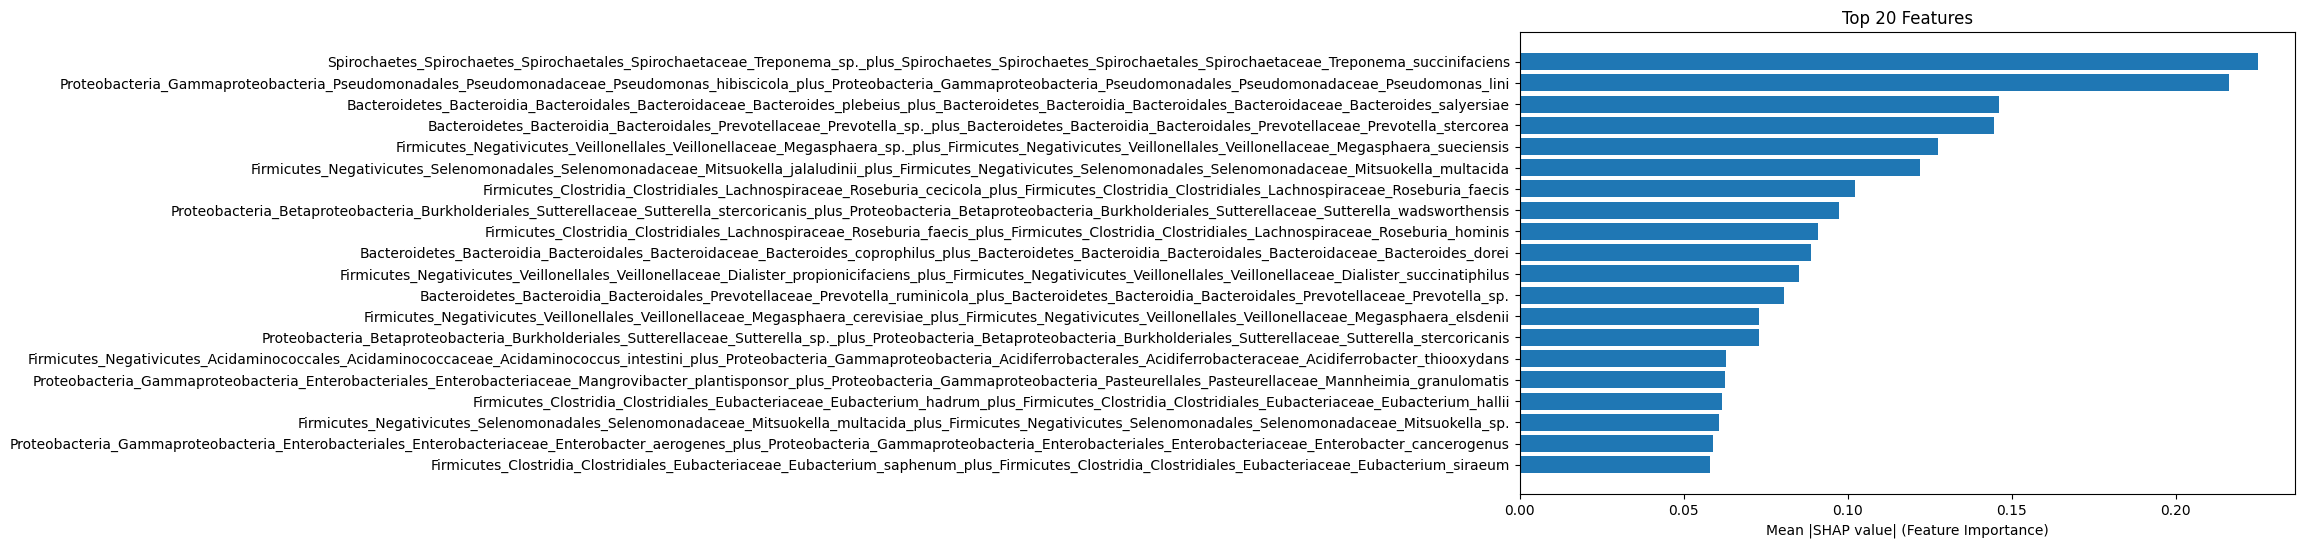

<Figure size 1000x800 with 0 Axes>

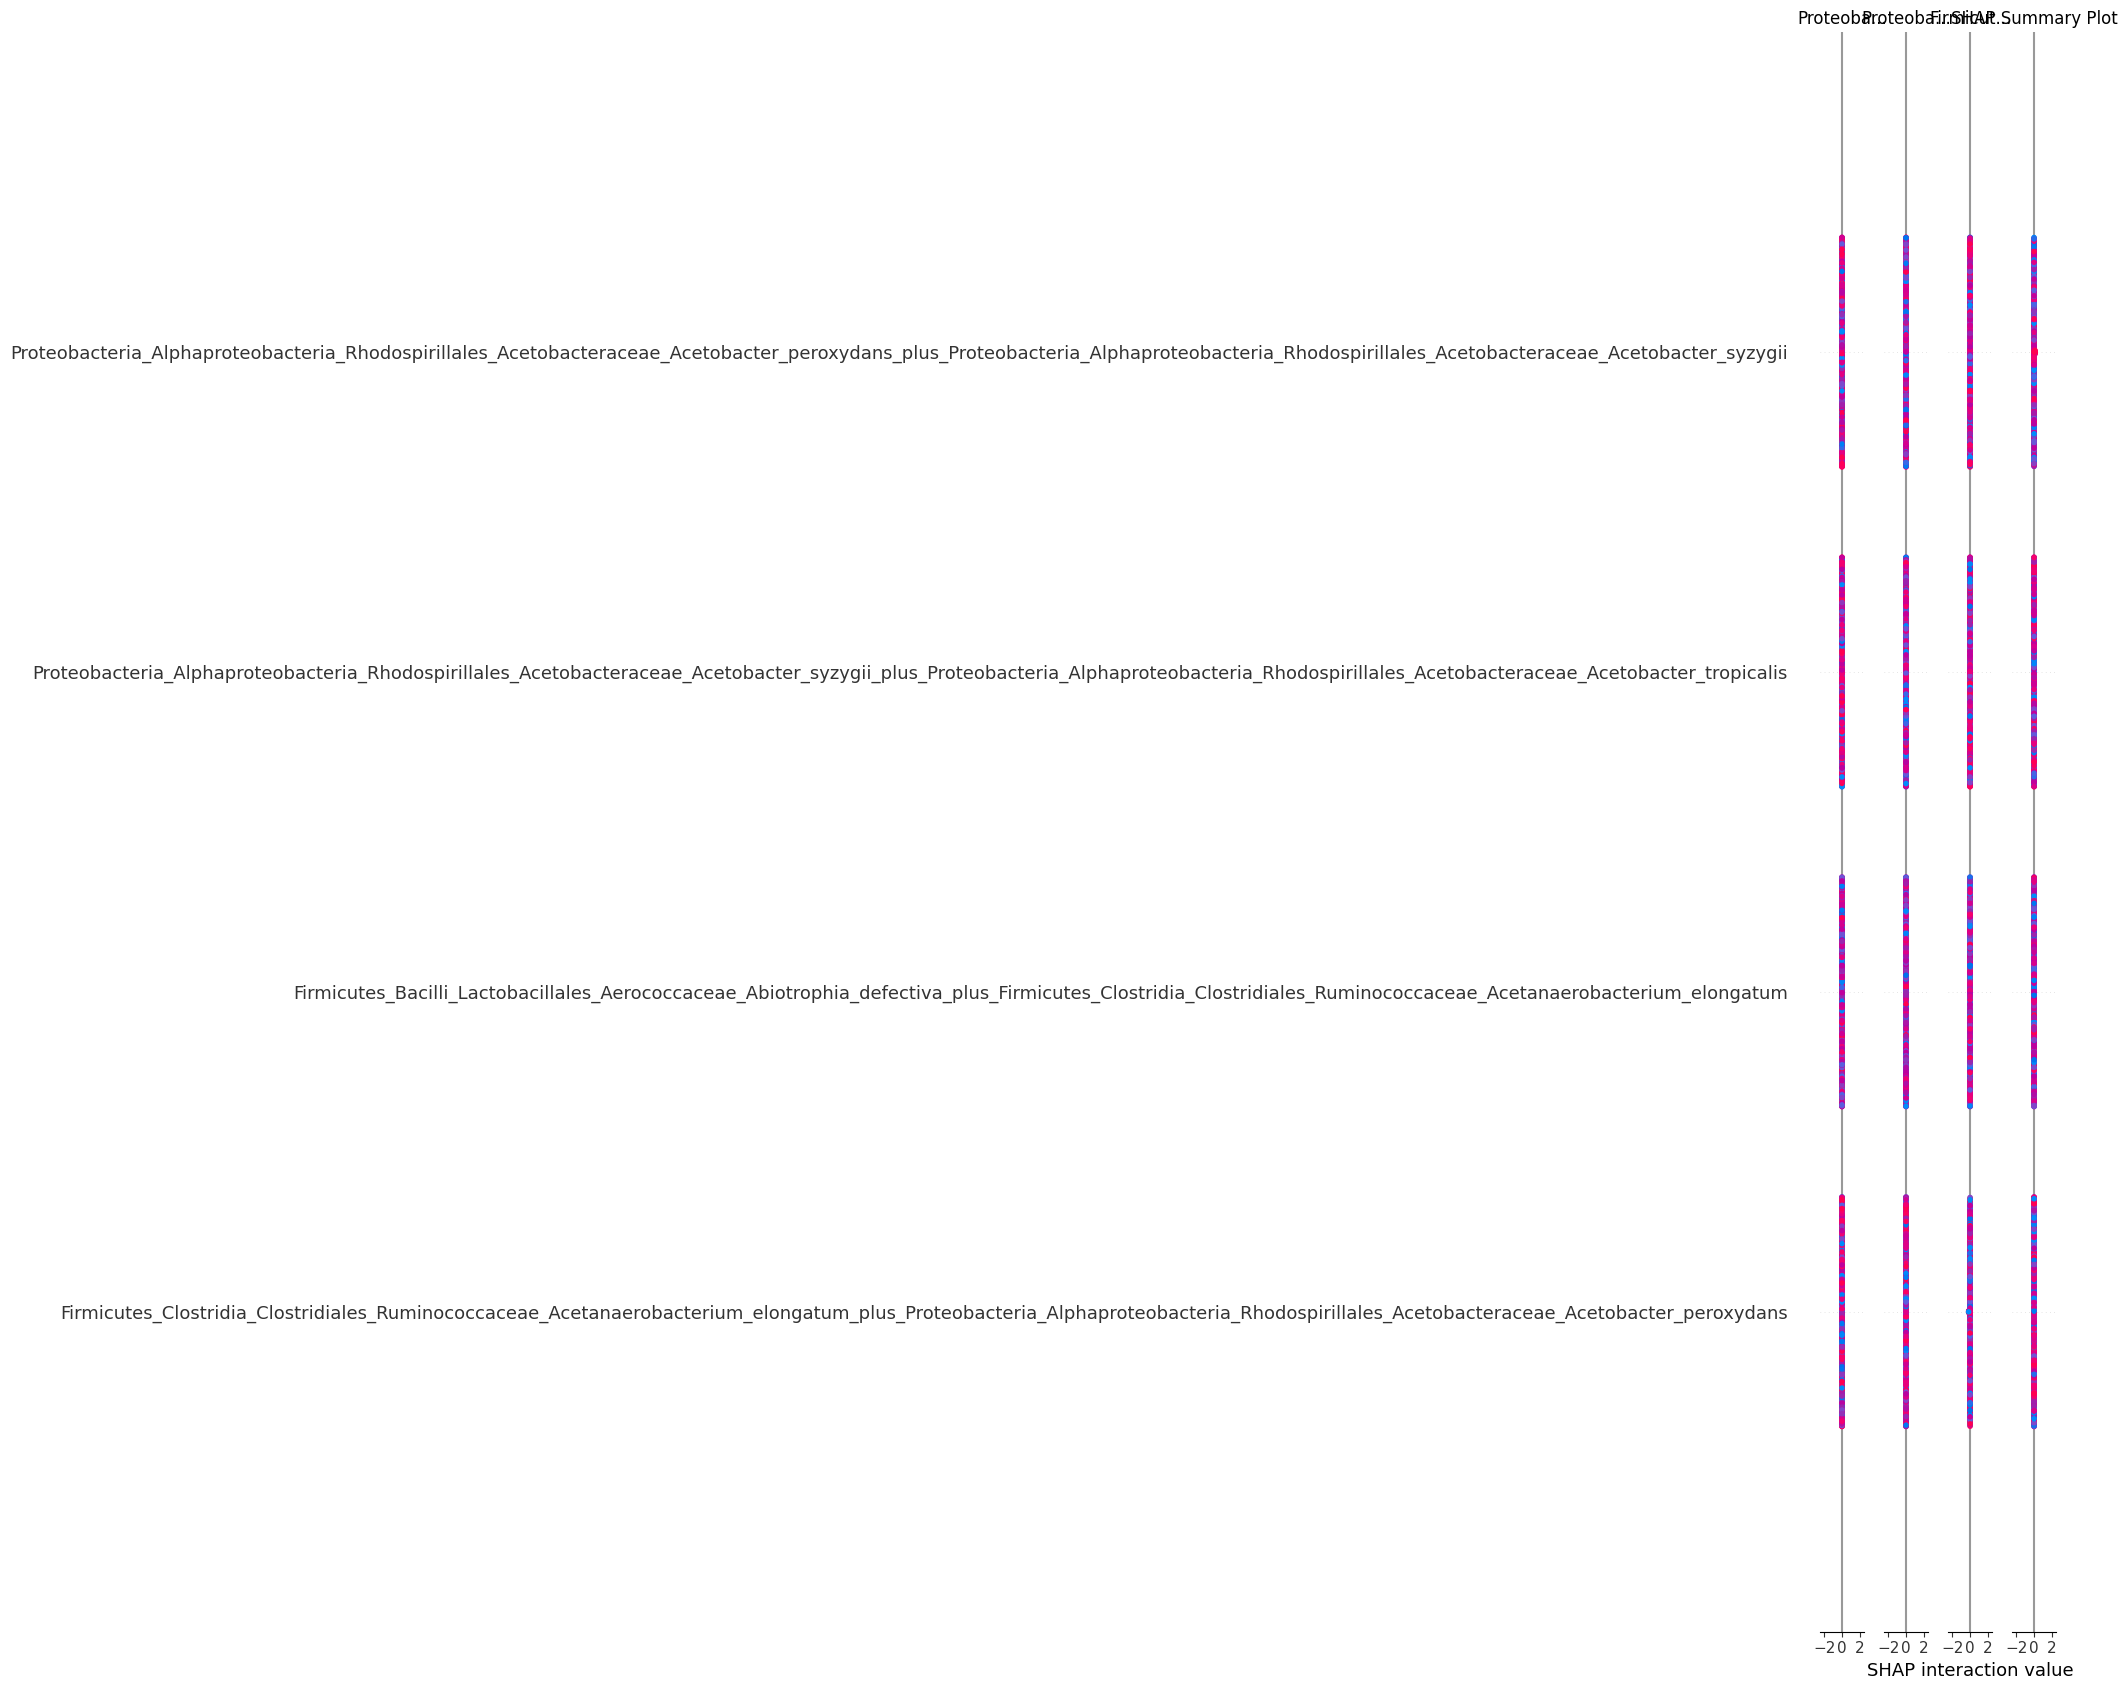


ANALYSIS COMPLETE


In [30]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, cross_val_score
import lightgbm as lgb
import shap
import matplotlib.pyplot as plt
from matplotlib import rcParams

# -----------------------------
# 0. Plotting setup
# -----------------------------
rcParams['font.size'] = 10
rcParams['figure.dpi'] = 100

# -----------------------------
# 1. Data loading
# -----------------------------
otu_file = r"/home/user/Documents/Sandhya/AI_in_medicine_lab/AI project/abundance_only.xlsx"
meta_file = r"/home/user/Documents/Sandhya/AI_in_medicine_lab/AI project/metadata_only.xlsx"

otu_raw = pd.read_excel(otu_file, index_col=0)
meta_raw = pd.read_excel(meta_file)

meta = meta_raw.set_index(meta_raw.columns[0])
target_col = 'Geographical zone in India'

# Keep only samples with target info
meta = meta.dropna(subset=[target_col])
common_samples = list(set(otu_raw.index) & set(meta.index))
otu_aligned = otu_raw.loc[common_samples]
y = meta.loc[common_samples, target_col]

# -----------------------------
# 2. CLR Transformation
# -----------------------------
def centered_log_ratio(df):
    df_pseudo = df + 1e-6
    gm = np.exp(np.log(df_pseudo).mean(axis=1))
    return np.log(df_pseudo.divide(gm, axis=0))

# -----------------------------
# 2b. Sliding sum features
# -----------------------------
def sliding_sum_features(df, window_size=2):
    """
    Create new features by summing consecutive taxa abundances.
    Example: if features are [f1, f2, f3, f4],
    result = [f1+f2, f2+f3, f3+f4].
    """
    new_features = {}
    cols = df.columns
    for i in range(len(cols) - window_size + 1):
        window_cols = cols[i:i+window_size]
        new_name = "_plus_".join(window_cols)
        new_features[new_name] = df.iloc[:, i:(i+window_size)].sum(axis=1)
    return pd.DataFrame(new_features, index=df.index)

# -----------------------------
# 2c. Choose feature mode
# -----------------------------
feature_mode = "sliding"   # options: "raw", "sliding", "combined"
clr_otu = centered_log_ratio(otu_aligned)

if feature_mode == "raw":
    X = clr_otu
elif feature_mode == "sliding":
    X = sliding_sum_features(clr_otu, window_size=2)
elif feature_mode == "combined":
    sliding = sliding_sum_features(clr_otu, window_size=2)
    X = pd.concat([clr_otu, sliding], axis=1)
else:
    raise ValueError("Invalid feature_mode. Choose from: raw, sliding, combined")

print("="*60)
print(f"Feature mode: {feature_mode}")
print(f"Transformed data shape: {X.shape}")
print("="*60)

# -----------------------------
# 3. Encode target
# -----------------------------
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print(f"Number of samples: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")
print(f"Classes: {le.classes_}")
print(f"Class distribution: {dict(zip(le.classes_, np.bincount(y_encoded)))}")

# -----------------------------
# 4. Train best model
# -----------------------------
best_params = {
    'learning_rate': 0.10351332282682328,
    'max_depth': 8,
    'n_estimators': 103,
    'num_leaves': 13,
    'random_state': 42
}

model = lgb.LGBMClassifier(**best_params)

# Cross-validation check
cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X, y_encoded, cv=cv_outer, scoring='accuracy', n_jobs=-1)
print(f"CV Accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

# Fit model on full data
model.fit(X, y_encoded)

# -----------------------------
# 5. SHAP DIAGNOSTICS (FIXED)
# -----------------------------
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# Debug: Print SHAP values structure
print(f"\nDEBUG: SHAP values type: {type(shap_values)}")
if isinstance(shap_values, list):
    print(f"DEBUG: SHAP values is a list with {len(shap_values)} elements")
    print(f"DEBUG: Each element shape: {[arr.shape for arr in shap_values]}")
else:
    print(f"DEBUG: SHAP values shape: {shap_values.shape}")

# Calculate feature importance - FIXED VERSION FOR 3D ARRAY
if isinstance(shap_values, list):
    # For multiclass: shap_values is a list of arrays (one per class)
    # Stack them and take mean absolute value across samples and classes
    stacked_shap = np.stack(shap_values, axis=0)  # Shape: (n_classes, n_samples, n_features)
    importance = np.mean(np.abs(stacked_shap), axis=(0, 1))  # Mean over classes and samples
elif shap_values.ndim == 3:
    # For multiclass with 3D array: (n_samples, n_features, n_classes)
    # Take mean absolute value across samples and classes
    importance = np.mean(np.abs(shap_values), axis=(0, 2))  # Mean over samples and classes
elif shap_values.ndim == 2:
    # For binary classification: shap_values is a 2D array (n_samples, n_features)
    importance = np.mean(np.abs(shap_values), axis=0)  # Mean over samples
else:
    raise ValueError(f"Unexpected SHAP values shape: {shap_values.shape}")

# Ensure importance is 1D
importance = np.array(importance).flatten()

print(f"DEBUG: Importance shape: {importance.shape}")
print(f"DEBUG: Number of features: {len(X.columns)}")
print(f"DEBUG: Importance array: {importance[:5]}...")  # Show first 5 values
print(f"DEBUG: Feature names: {list(X.columns[:5])}...")  # Show first 5 feature names

# Check if lengths match
if len(importance) != len(X.columns):
    print(f"ERROR: Length mismatch! Importance: {len(importance)}, Features: {len(X.columns)}")
    print("This suggests an issue with SHAP values calculation.")
    
    # Let's try a different approach
    print("Trying alternative SHAP importance calculation...")
    
    if isinstance(shap_values, list):
        # Try summing absolute values across all classes first
        total_importance = np.zeros(X.shape[1])
        for class_shap in shap_values:
            total_importance += np.mean(np.abs(class_shap), axis=0)
        importance = total_importance
    else:
        importance = np.mean(np.abs(shap_values), axis=0)
    
    importance = np.array(importance).flatten()
    print(f"DEBUG: After fix - Importance shape: {importance.shape}")

# Final check before creating DataFrame
assert len(importance) == len(X.columns), f"Still mismatched: {len(importance)} vs {len(X.columns)}"

# Create importance DataFrame
importance_df = pd.DataFrame({
    'feature': list(X.columns),  # Convert to list explicitly
    'importance': list(importance)  # Convert to list explicitly
}).sort_values('importance', ascending=False)

print("\n" + "="*50)
print("TOP 10 MOST IMPORTANT FEATURES")
print("="*50)
print(importance_df.head(10).to_string(index=False))

# Save results
importance_df.to_csv('shap_feature_importance.csv', index=False)
print("\n💾 Results saved to 'shap_feature_importance.csv'")

# Plot top features
plt.figure(figsize=(10,6))
top_features = importance_df.head(20)
plt.barh(top_features['feature'], top_features['importance'])
plt.gca().invert_yaxis()
plt.xlabel("Mean |SHAP value| (Feature Importance)")
plt.title("Top 20 Features")
plt.tight_layout()
plt.show()

# Optional: Create SHAP summary plot for better visualization
try:
    if isinstance(shap_values, list):
        # For multiclass, create summary plot for first class or combined
        plt.figure(figsize=(10, 8))
        shap.summary_plot(shap_values[0], X, max_display=20, show=False)
        plt.title(f"SHAP Summary Plot - Class: {le.classes_[0]}")
        plt.tight_layout()
        plt.show()
    else:
        plt.figure(figsize=(10, 8))
        shap.summary_plot(shap_values, X, max_display=20, show=False)
        plt.title("SHAP Summary Plot")
        plt.tight_layout()
        plt.show()
except Exception as e:
    print(f"Note: Could not create SHAP summary plot: {e}")

print("\n" + "="*60)
print("ANALYSIS COMPLETE")
print("="*60)

In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import lightgbm as lgb

# Assuming you have X, y_encoded, and best_params from your main code
# If running separately, you'll need to load/prepare your data first

best_params = {
    'learning_rate': 0.10351332282682328,
    'max_depth': 8,
    'n_estimators': 103,
    'num_leaves': 13,
    'random_state': 42
}

model = lgb.LGBMClassifier(**best_params)

# Set up cross-validation
cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define scoring metrics
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

print("="*60)
print("DETAILED CROSS-VALIDATION ANALYSIS")
print("="*60)

# Perform cross-validation with multiple metrics
cv_results = cross_validate(
    model, X, y_encoded, 
    cv=cv_outer, 
    scoring=scoring, 
    return_train_score=True,
    n_jobs=-1
)

# Create detailed results DataFrame
results_df = pd.DataFrame({
    'Fold': range(1, 6),
    'Train_Accuracy': cv_results['train_accuracy'],
    'Test_Accuracy': cv_results['test_accuracy'],
    'Test_Precision': cv_results['test_precision_macro'],
    'Test_Recall': cv_results['test_recall_macro'],
    'Test_F1': cv_results['test_f1_macro']
})

print("\nFOLD-BY-FOLD RESULTS:")
print(results_df.round(4))

# Calculate summary statistics
print("\n" + "="*50)
print("SUMMARY STATISTICS")
print("="*50)

metrics_summary = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Mean': [
        np.mean(cv_results['test_accuracy']),
        np.mean(cv_results['test_precision_macro']),
        np.mean(cv_results['test_recall_macro']),
        np.mean(cv_results['test_f1_macro'])
    ],
    'Std': [
        np.std(cv_results['test_accuracy']),
        np.std(cv_results['test_precision_macro']),
        np.std(cv_results['test_recall_macro']),
        np.std(cv_results['test_f1_macro'])
    ],
    'Min': [
        np.min(cv_results['test_accuracy']),
        np.min(cv_results['test_precision_macro']),
        np.min(cv_results['test_recall_macro']),
        np.min(cv_results['test_f1_macro'])
    ],
    'Max': [
        np.max(cv_results['test_accuracy']),
        np.max(cv_results['test_precision_macro']),
        np.max(cv_results['test_recall_macro']),
        np.max(cv_results['test_f1_macro'])
    ]
}

summary_df = pd.DataFrame(metrics_summary)
print(summary_df.round(4))

# Check for overfitting
print("\n" + "="*50)
print("OVERFITTING CHECK")
print("="*50)

train_mean = np.mean(cv_results['train_accuracy'])
test_mean = np.mean(cv_results['test_accuracy'])
gap = train_mean - test_mean

print(f"Mean Training Accuracy: {train_mean:.4f}")
print(f"Mean Test Accuracy: {test_mean:.4f}")
print(f"Train-Test Gap: {gap:.4f}")

if gap > 0.1:
    print("⚠️  Large gap suggests potential overfitting")
elif gap > 0.05:
    print("⚠️  Moderate gap - monitor for overfitting")
else:
    print("✅ Good generalization - low overfitting risk")

# Individual fold analysis
print("\n" + "="*50)
print("INDIVIDUAL FOLD ANALYSIS")
print("="*50)

for i, (accuracy, f1) in enumerate(zip(cv_results['test_accuracy'], cv_results['test_f1_macro'])):
    status = "🟢 Good" if accuracy > 0.65 else "🟡 Fair" if accuracy > 0.55 else "🔴 Poor"
    print(f"Fold {i+1}: Accuracy={accuracy:.4f}, F1={f1:.4f} {status}")

# Save detailed results
results_df.to_csv('detailed_cv_results.csv', index=False)
summary_df.to_csv('cv_summary_stats.csv', index=False)

print(f"\n💾 Detailed results saved to:")
print(f"   - detailed_cv_results.csv")
print(f"   - cv_summary_stats.csv")

print("\n" + "="*60)
print("CV ANALYSIS COMPLETE")
print("="*60)

DETAILED CROSS-VALIDATION ANALYSIS
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 252685
[LightGBM] [Info] Number of data points in the train set: 803, number of used features: 992
[LightGBM] [Info] Start training from score -1.390037
[LightGBM] [Info] Start training from score -1.415355
[LightGBM] [Info] Start training from score -1.390037
[LightGBM] [Info] Start training from score -1.350817
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, t

LOADING DATA
✅ Loaded 1004 samples

FEATURE ENGINEERING: SLIDING SUM FEATURES
Original OTU features: 993
Sliding sum features: 992
Number of samples: 1004

Classes: ['East' 'North' 'South' 'West']
Class distribution: {'East': 250, 'North': 243, 'South': 250, 'West': 261}

5-FOLD CROSS-VALIDATION
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 252685
[LightGBM] [Info] Number of data points in the train set: 803, number of used features: 992
[LightGBM] [Info] Start training from score -1.390037
[LightGBM] [Info] Start training from score -1.415355
[LightGBM] [Info] Start training from score -1.390037
[LightGBM] [Info] Start training from score -1.350817
Fold 1: Acc=0.7313, Prec=0.7288, Rec=0.7289, F1=0.7282
[LightGBM] [Warning] Found whitespace in feature_names, replac

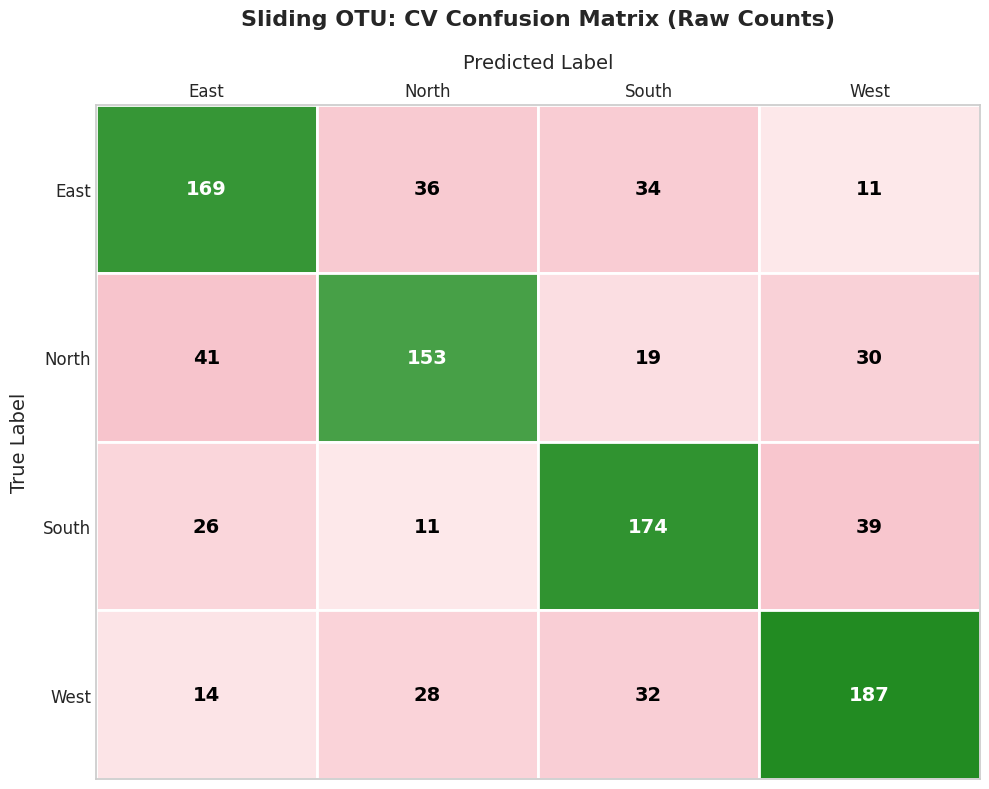

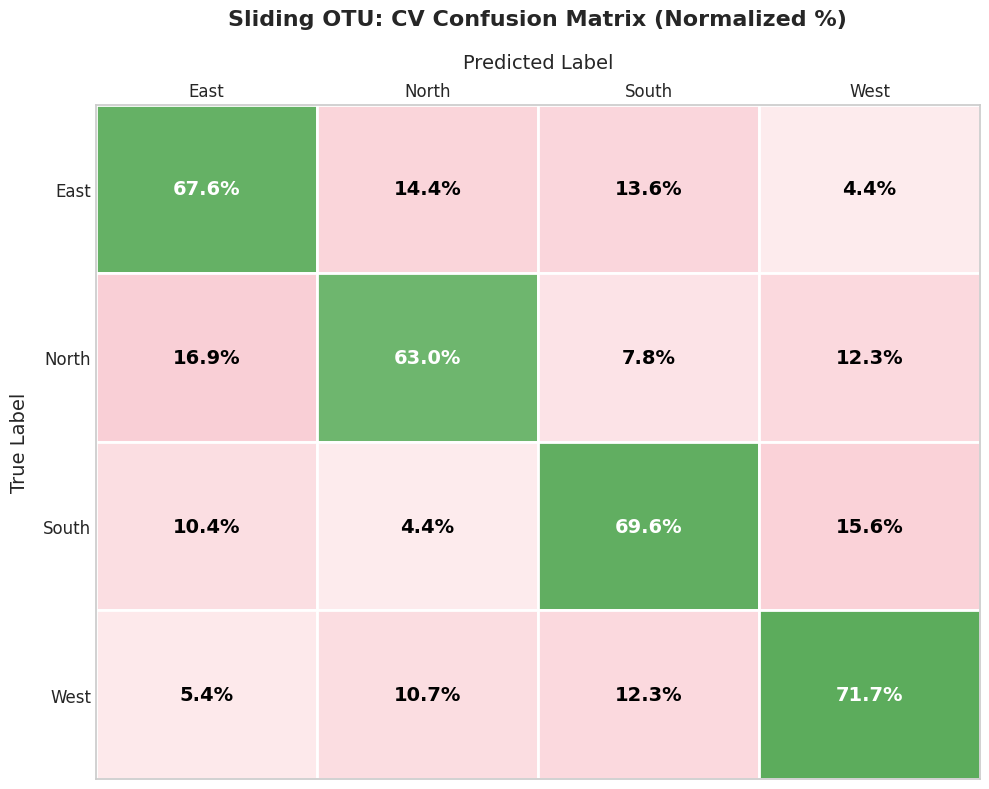

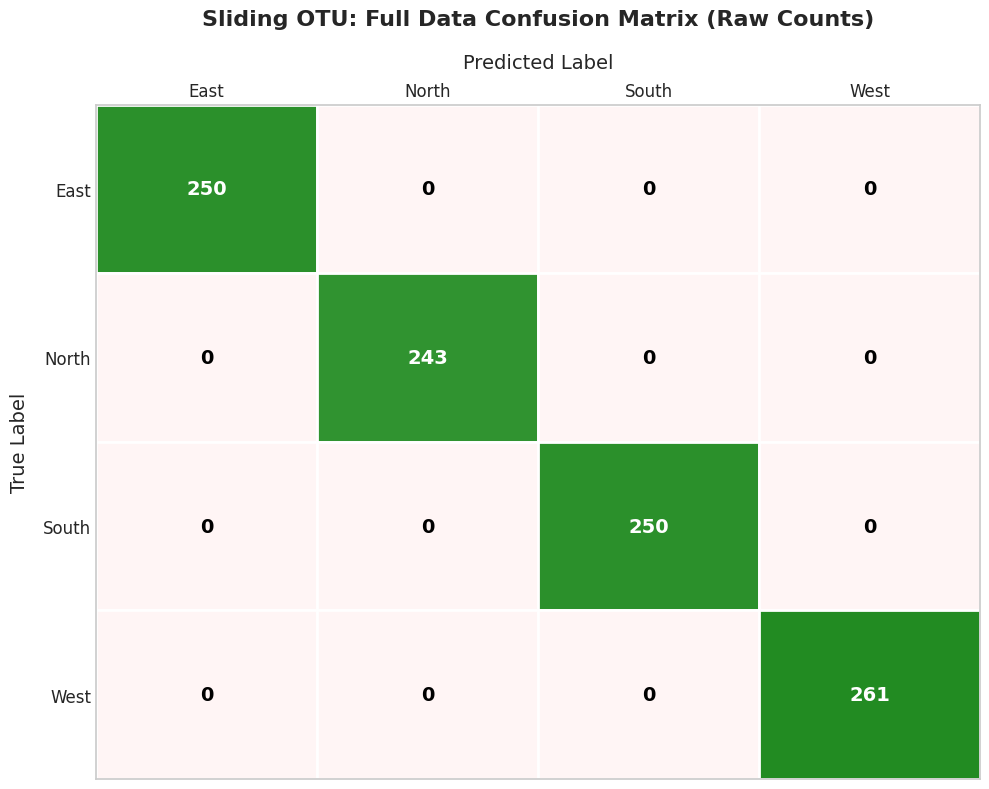

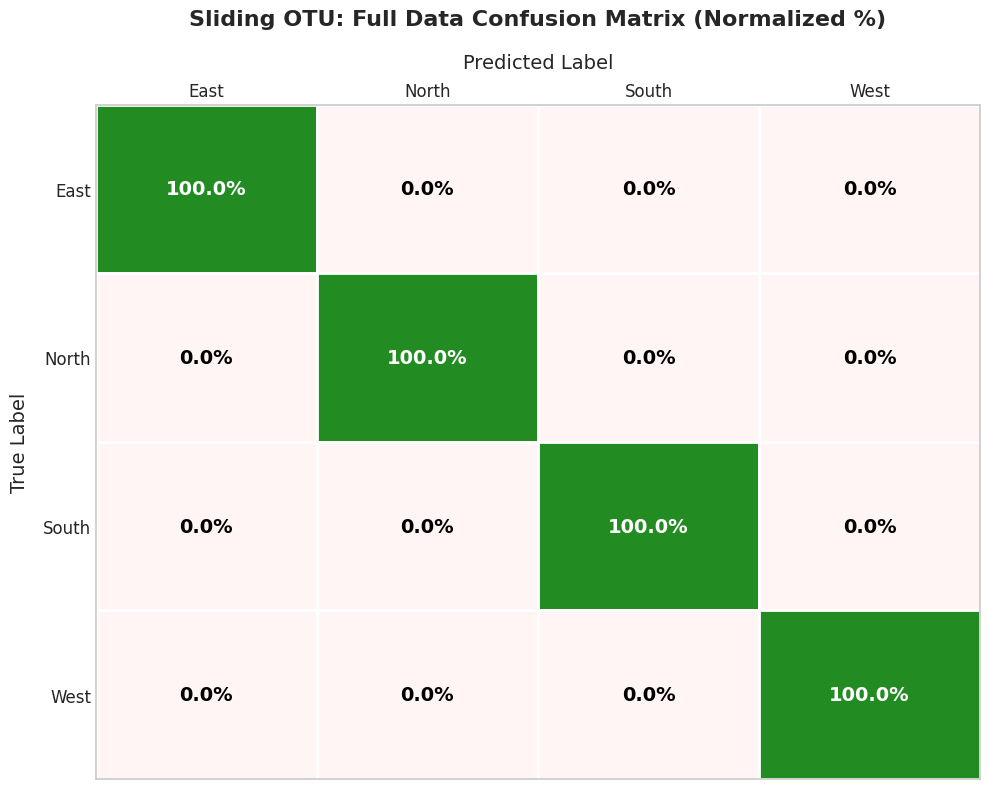

✅ Saved confusion matrix visualizations as PNG files

GENERATING OVERALL FEATURE IMPORTANCE PLOT (SHAP)


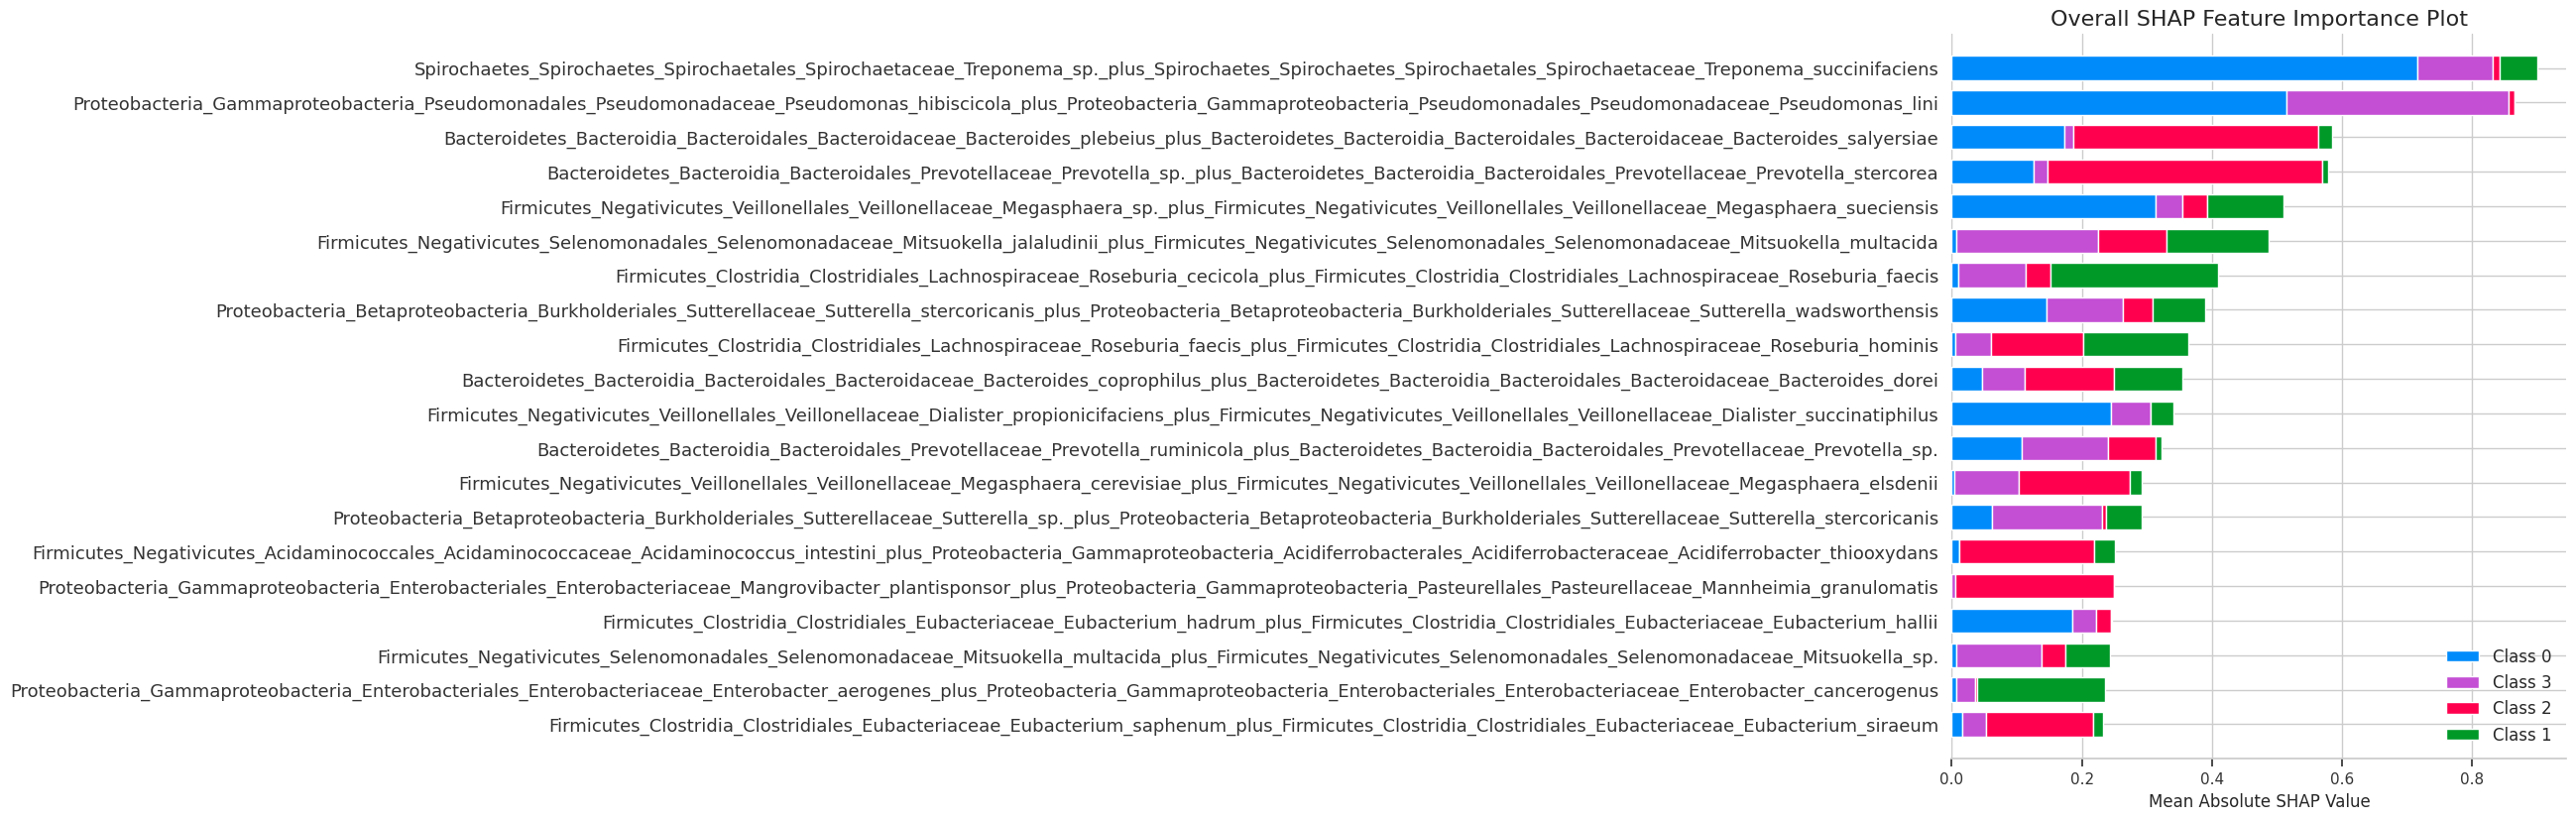

✅ Saved overall SHAP summary plot as PNG file

GENERATING PER-CLASS SHAP BEESWARM PLOTS
Generating SHAP plot for class: East
❗ An error occurred during per-class SHAP plotting: The shape of the shap_values matrix does not match the shape of the provided data matrix.

ANALYSIS COMPLETE - SLIDING OTU MODEL

Saved files:
  Excel files:
    • sliding_otu_fold_by_fold_metrics.xlsx
    • sliding_otu_summary_statistics.xlsx
    • sliding_otu_cv_confusion_matrix_raw.xlsx
    • sliding_otu_cv_confusion_matrix_normalized.xlsx
    • sliding_otu_full_confusion_matrix_raw.xlsx
    • sliding_otu_full_confusion_matrix_normalized.xlsx

  Visualizations:
    • sliding_otu_cv_confusion_matrix_raw.png
    • sliding_otu_cv_confusion_matrix_normalized.png
    • sliding_otu_full_confusion_matrix_raw.png
    • sliding_otu_full_confusion_matrix_normalized.png
    • sliding_otu_shap_feature_importance.png
    • **Per-class SHAP plots (one for each geographical zone)**


<Figure size 1000x800 with 0 Axes>

In [70]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    confusion_matrix
)
import lightgbm as lgb
import matplotlib.pyplot as plt
from matplotlib import rcParams
import shap

# -----------------------------
# 0. Plotting setup
# -----------------------------
rcParams['font.size'] = 10
rcParams['figure.dpi'] = 100

# -----------------------------
# 1. Data loading
# -----------------------------
print("="*70)
print("LOADING DATA")
print("="*70)

otu_file = r"/home/user/Documents/Sandhya/AI_in_medicine_lab/AI project/abundance_only.xlsx"
meta_file = r"/home/user/Documents/Sandhya/AI_in_medicine_lab/AI project/metadata_only.xlsx"

otu_raw = pd.read_excel(otu_file, index_col=0)
meta_raw = pd.read_excel(meta_file)

meta = meta_raw.set_index(meta_raw.columns[0])
target_col = 'Geographical zone in India'

# Keep only samples with target info
meta = meta.dropna(subset=[target_col])
common_samples = list(set(otu_raw.index) & set(meta.index))
otu_aligned = otu_raw.loc[common_samples]
y = meta.loc[common_samples, target_col]

print(f"✅ Loaded {len(common_samples)} samples")

# -----------------------------
# 2. CLR Transformation
# -----------------------------
def centered_log_ratio(df):
    """Applies Centered Log-Ratio transformation to a dataframe."""
    df_pseudo = df + 1e-6
    gm = np.exp(np.log(df_pseudo).mean(axis=1))
    return np.log(df_pseudo.divide(gm, axis=0))

# -----------------------------
# 3. Sliding sum features
# -----------------------------
def sliding_sum_features(df, window_size=2):
    """
    Create new features by summing consecutive taxa abundances.
    """
    new_features = {}
    cols = df.columns
    for i in range(len(cols) - window_size + 1):
        window_cols = cols[i:i+window_size]
        new_name = "_plus_".join(window_cols)
        new_features[new_name] = df.iloc[:, i:(i+window_size)].sum(axis=1)
    return pd.DataFrame(new_features, index=df.index)

# -----------------------------
# 4. Feature engineering
# -----------------------------
print("\n" + "="*70)
print("FEATURE ENGINEERING: SLIDING SUM FEATURES")
print("="*70)

clr_otu = centered_log_ratio(otu_aligned)
X = sliding_sum_features(clr_otu, window_size=2)

print(f"Original OTU features: {otu_aligned.shape[1]}")
print(f"Sliding sum features: {X.shape[1]}")
print(f"Number of samples: {X.shape[0]}")

# -----------------------------
# 5. Encode target
# -----------------------------
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print(f"\nClasses: {le.classes_}")
print(f"Class distribution: {dict(zip(le.classes_, np.bincount(y_encoded)))}")

# -----------------------------
# 6. Model parameters
# -----------------------------
best_params = {
    'learning_rate': 0.10351332282682328,
    'max_depth': 8,
    'n_estimators': 103,
    'num_leaves': 13,
    'random_state': 42
}

model = lgb.LGBMClassifier(**best_params)

# =============================================================================
# 7. CROSS-VALIDATION WITH DETAILED METRICS
# =============================================================================
print("\n" + "="*70)
print("5-FOLD CROSS-VALIDATION")
print("="*70)

cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Storage for fold-by-fold results
fold_results = {
    'Fold': [],
    'Accuracy': [],
    'Precision_Macro': [],
    'Precision_Weighted': [],
    'Recall_Macro': [],
    'Recall_Weighted': [],
    'F1_Macro': [],
    'F1_Weighted': [],
    'NPV_Macro': [],
    'NPV_Weighted': []
}

# Storage for confusion matrices
cv_confusion_matrices = []

fold_num = 1
for train_idx, val_idx in cv_outer.split(X, y_encoded):
    # Split data
    X_train_fold = X.iloc[train_idx]
    X_val_fold = X.iloc[val_idx]
    y_train_fold = y_encoded[train_idx]
    y_val_fold = y_encoded[val_idx]
    
    # Train and predict
    model.fit(X_train_fold, y_train_fold)
    y_pred_fold = model.predict(X_val_fold)
    
    # Compute metrics
    acc = accuracy_score(y_val_fold, y_pred_fold)
    prec_macro = precision_score(y_val_fold, y_pred_fold, average='macro', zero_division=0)
    prec_weighted = precision_score(y_val_fold, y_pred_fold, average='weighted', zero_division=0)
    rec_macro = recall_score(y_val_fold, y_pred_fold, average='macro', zero_division=0)
    rec_weighted = recall_score(y_val_fold, y_pred_fold, average='weighted', zero_division=0)
    f1_macro = f1_score(y_val_fold, y_pred_fold, average='macro', zero_division=0)
    f1_weighted = f1_score(y_val_fold, y_pred_fold, average='weighted', zero_division=0)
    
    # Compute NPV
    cm_fold = confusion_matrix(y_val_fold, y_pred_fold)
    cv_confusion_matrices.append(cm_fold)
    
    n_classes = len(le.classes_)
    npv_per_class = []
    for i in range(n_classes):
        tn = np.sum(cm_fold) - np.sum(cm_fold[i, :]) - np.sum(cm_fold[:, i]) + cm_fold[i, i]
        fn = np.sum(cm_fold[i, :]) - cm_fold[i, i]
        npv = tn / (tn + fn) if (tn + fn) > 0 else 0
        npv_per_class.append(npv)
    
    npv_macro = np.mean(npv_per_class)
    support = np.sum(cm_fold, axis=1)
    npv_weighted = np.average(npv_per_class, weights=support)
    
    # Store results
    fold_results['Fold'].append(fold_num)
    fold_results['Accuracy'].append(acc)
    fold_results['Precision_Macro'].append(prec_macro)
    fold_results['Precision_Weighted'].append(prec_weighted)
    fold_results['Recall_Macro'].append(rec_macro)
    fold_results['Recall_Weighted'].append(rec_weighted)
    fold_results['F1_Macro'].append(f1_macro)
    fold_results['F1_Weighted'].append(f1_weighted)
    fold_results['NPV_Macro'].append(npv_macro)
    fold_results['NPV_Weighted'].append(npv_weighted)
    
    print(f"Fold {fold_num}: Acc={acc:.4f}, Prec={prec_macro:.4f}, Rec={rec_macro:.4f}, F1={f1_macro:.4f}")
    
    fold_num += 1

# Create fold-by-fold DataFrame
fold_df = pd.DataFrame(fold_results)

# =============================================================================
# 8. COMPUTE SUMMARY STATISTICS
# =============================================================================
print("\n" + "="*70)
print("SUMMARY STATISTICS")
print("="*70)

summary_data = []
metrics_to_summarize = [
    ('Accuracy', 'Accuracy'),
    ('Precision (Macro)', 'Precision_Macro'),
    ('Precision (Weighted)', 'Precision_Weighted'),
    ('Recall (Macro)', 'Recall_Macro'),
    ('Recall (Weighted)', 'Recall_Weighted'),
    ('F1 Score (Macro)', 'F1_Macro'),
    ('F1 Score (Weighted)', 'F1_Weighted'),
    ('NPV (Macro)', 'NPV_Macro'),
    ('NPV (Weighted)', 'NPV_Weighted')
]

for metric_name, metric_key in metrics_to_summarize:
    values = fold_df[metric_key].values
    summary_data.append({
        'Metric': metric_name,
        'Mean': np.mean(values),
        'Std_Dev': np.std(values, ddof=1),
        'Min': np.min(values),
        'Max': np.max(values)
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.round(4))

# =============================================================================
# 9. AGGREGATE CONFUSION MATRIX (CV)
# =============================================================================
cm_cv = np.sum(cv_confusion_matrices, axis=0)
cm_cv_normalized = cm_cv.astype('float') / cm_cv.sum(axis=1)[:, np.newaxis]

print("\n" + "="*70)
print("AGGREGATED CV CONFUSION MATRIX (Raw Counts)")
print("="*70)
print(cm_cv)

# =============================================================================
# 10. TRAIN ON FULL DATA
# =============================================================================
print("\n" + "="*70)
print("TRAINING ON FULL DATASET")
print("="*70)

# Train the model on the entire dataset for final evaluation and feature importance analysis
model.fit(X, y_encoded)
y_pred_full = model.predict(X)
cm_full = confusion_matrix(y_encoded, y_pred_full)
cm_full_normalized = cm_full.astype('float') / cm_full.sum(axis=1)[:, np.newaxis]

full_accuracy = accuracy_score(y_encoded, y_pred_full)
print(f"Full Data Accuracy: {full_accuracy:.4f}")

# =============================================================================
# 11. SAVE ALL RESULTS TO EXCEL FILES
# =============================================================================
print("\n" + "="*70)
print("SAVING RESULTS")
print("="*70)

# Save fold-by-fold metrics
fold_df.to_excel('sliding_otu_fold_by_fold_metrics.xlsx', index=False)
print("✅ Saved: sliding_otu_fold_by_fold_metrics.xlsx")

# Save summary statistics
summary_df.to_excel('sliding_otu_summary_statistics.xlsx', index=False)
print("✅ Saved: sliding_otu_summary_statistics.xlsx")

# Save CV confusion matrix (raw)
cm_cv_df = pd.DataFrame(
    cm_cv,
    index=[f'True_{label}' for label in le.classes_],
    columns=[f'Pred_{label}' for label in le.classes_]
)
cm_cv_df.to_excel('sliding_otu_cv_confusion_matrix_raw.xlsx')
print("✅ Saved: sliding_otu_cv_confusion_matrix_raw.xlsx")

# Save CV confusion matrix (normalized)
cm_cv_norm_df = pd.DataFrame(
    cm_cv_normalized * 100,  # Convert to percentage
    index=[f'True_{label}' for label in le.classes_],
    columns=[f'Pred_{label}' for label in le.classes_]
)
cm_cv_norm_df.to_excel('sliding_otu_cv_confusion_matrix_normalized.xlsx')
print("✅ Saved: sliding_otu_cv_confusion_matrix_normalized.xlsx")

# Save Full data confusion matrix (raw)
cm_full_df = pd.DataFrame(
    cm_full,
    index=[f'True_{label}' for label in le.classes_],
    columns=[f'Pred_{label}' for label in le.classes_]
)
cm_full_df.to_excel('sliding_otu_full_confusion_matrix_raw.xlsx')
print("✅ Saved: sliding_otu_full_confusion_matrix_raw.xlsx")

# Save Full data confusion matrix (normalized)
cm_full_norm_df = pd.DataFrame(
    cm_full_normalized * 100,  # Convert to percentage
    index=[f'True_{label}' for label in le.classes_],
    columns=[f'Pred_{label}' for label in le.classes_]
)
cm_full_norm_df.to_excel('sliding_otu_full_confusion_matrix_normalized.xlsx')
print("✅ Saved: sliding_otu_full_confusion_matrix_normalized.xlsx")

# =============================================================================
# 12. VISUALIZE CONFUSION MATRICES
# =============================================================================
print("\n" + "="*70)
print("GENERATING CONFUSION MATRIX VISUALIZATIONS")
print("="*70)

# Color definitions
green_light = np.array([240, 255, 240]) / 255.0
green_dark = np.array([34, 139, 34]) / 255.0
red_light = np.array([255, 245, 245]) / 255.0
red_dark = np.array([220, 20, 60]) / 255.0

def plot_confusion_matrix_absolute(cm, class_labels, title, normalize=False, figsize=(10, 8)):
    """
    Plots a confusion matrix with color intensity based on absolute values.
    Diagonal (correct) predictions are shaded green, incorrect are red.
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    if normalize:
        cm_display = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm_display = np.round(cm_display * 100, 2)
        max_value = 100.0
        suffix = '%'
    else:
        cm_display = cm
        max_value = cm_display.max()
        suffix = ''
    
    n_classes = len(class_labels)
    
    for i in range(n_classes):
        for j in range(n_classes):
            value = cm_display[i, j]
            intensity = value / max_value if max_value > 0 else 0
            intensity = np.clip(intensity, 0, 1)
            
            if i == j:
                color = green_light + intensity * (green_dark - green_light)
            else:
                color = red_light + intensity * (red_dark - red_light)
            
            rect = plt.Rectangle((j, i), 1, 1, facecolor=color, edgecolor='white', linewidth=2)
            ax.add_patch(rect)
            
            text = f'{value:.1f}{suffix}' if normalize else f'{int(value)}'
            text_color = 'white' if intensity > 0.5 else 'black'
            ax.text(j + 0.5, i + 0.5, text, ha='center', va='center',
                     fontsize=14, weight='bold', color=text_color)
    
    ax.set_xlim(0, n_classes)
    ax.set_ylim(0, n_classes)
    ax.set_xticks(np.arange(n_classes) + 0.5)
    ax.set_yticks(np.arange(n_classes) + 0.5)
    ax.set_xticklabels(class_labels, fontsize=12)
    ax.set_yticklabels(class_labels, fontsize=12)
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    ax.tick_params(length=0)
    ax.invert_yaxis()
    ax.set_xlabel('Predicted Label', fontsize=14, labelpad=10)
    ax.set_ylabel('True Label', fontsize=14, labelpad=10)
    ax.set_title(title, fontsize=16, pad=20, weight='bold')
    
    plt.tight_layout()
    return fig, ax

# Plot CV confusion matrices
fig1, _ = plot_confusion_matrix_absolute(
    cm_cv, le.classes_, 
    'Sliding OTU: CV Confusion Matrix (Raw Counts)',
    normalize=False
)
plt.savefig('sliding_otu_cv_confusion_matrix_raw.png', dpi=150, bbox_inches='tight')
plt.show()

fig2, _ = plot_confusion_matrix_absolute(
    cm_cv, le.classes_,
    'Sliding OTU: CV Confusion Matrix (Normalized %)',
    normalize=True
)
plt.savefig('sliding_otu_cv_confusion_matrix_normalized.png', dpi=150, bbox_inches='tight')
plt.show()

# Plot Full data confusion matrices
fig3, _ = plot_confusion_matrix_absolute(
    cm_full, le.classes_,
    'Sliding OTU: Full Data Confusion Matrix (Raw Counts)',
    normalize=False
)
plt.savefig('sliding_otu_full_confusion_matrix_raw.png', dpi=150, bbox_inches='tight')
plt.show()

fig4, _ = plot_confusion_matrix_absolute(
    cm_full, le.classes_,
    'Sliding OTU: Full Data Confusion Matrix (Normalized %)',
    normalize=True
)
plt.savefig('sliding_otu_full_confusion_matrix_normalized.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Saved confusion matrix visualizations as PNG files")


# =============================================================================
# 13. OVERALL FEATURE IMPORTANCE (SHAP)
# =============================================================================
print("\n" + "="*70)
print("GENERATING OVERALL FEATURE IMPORTANCE PLOT (SHAP)")
print("="*70)

try:
    # Create a SHAP TreeExplainer for the trained LightGBM model
    explainer = shap.TreeExplainer(model)
    
    # Calculate SHAP values for the full dataset X
    # For multiclass models, this returns a list of arrays, one for each class.
    shap_values = explainer.shap_values(X)

    # Plot overall SHAP summary plot (bar chart)
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X, plot_type='bar', show=False)
    plt.title('Overall SHAP Feature Importance Plot', fontsize=16)
    plt.xlabel('Mean Absolute SHAP Value', fontsize=12)
    plt.savefig('sliding_otu_shap_feature_importance.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("✅ Saved overall SHAP summary plot as PNG file")
    
except Exception as e:
    print(f"❗ An error occurred during SHAP calculation or plotting: {e}")
    print("Please ensure you have the 'shap' library installed (`pip install shap`)")


# =============================================================================
# 14. SHAP PLOTS FOR EACH CLASS
# =============================================================================
print("\n" + "="*70)
print("GENERATING PER-CLASS SHAP BEESWARM PLOTS")
print("="*70)

try:
    if 'shap_values' in locals() and shap_values is not None:
        # Loop through each class and generate a SHAP plot
        for i, class_name in enumerate(le.classes_):
            print(f"Generating SHAP plot for class: {class_name}")
            plt.figure(figsize=(10, 8))
            shap.summary_plot(shap_values[i], X, show=False)
            plt.title(f'SHAP Values for Predicting: {class_name}', fontsize=16)
            plt.savefig(f'sliding_otu_shap_class_{class_name.lower().replace(" ", "_")}.png', dpi=150, bbox_inches='tight')
            plt.show()
            print(f"✅ Saved: sliding_otu_shap_class_{class_name.lower().replace(' ', '_')}.png")
            
    else:
        print("❗ SHAP values were not calculated in the previous step. Skipping per-class plots.")
        
except Exception as e:
    print(f"❗ An error occurred during per-class SHAP plotting: {e}")

# =============================================================================
# 15. FINAL SUMMARY
# =============================================================================
print("\n" + "="*70)
print("ANALYSIS COMPLETE - SLIDING OTU MODEL")
print("="*70)
print("\nSaved files:")
print("  Excel files:")
print("    • sliding_otu_fold_by_fold_metrics.xlsx")
print("    • sliding_otu_summary_statistics.xlsx")
print("    • sliding_otu_cv_confusion_matrix_raw.xlsx")
print("    • sliding_otu_cv_confusion_matrix_normalized.xlsx")
print("    • sliding_otu_full_confusion_matrix_raw.xlsx")
print("    • sliding_otu_full_confusion_matrix_normalized.xlsx")
print("\n  Visualizations:")
print("    • sliding_otu_cv_confusion_matrix_raw.png")
print("    • sliding_otu_cv_confusion_matrix_normalized.png")
print("    • sliding_otu_full_confusion_matrix_raw.png")
print("    • sliding_otu_full_confusion_matrix_normalized.png")
print("    • sliding_otu_shap_feature_importance.png")
print("    • **Per-class SHAP plots (one for each geographical zone)**")
print("="*70)


CALCULATING SHAP VALUES
Raw SHAP values type: <class 'numpy.ndarray'>
Raw SHAP values shape: (1004, 992, 4)
  3D array detected: (samples=1004, features=992, classes=4)
✅ Converted 3D array to list with 4 classes
✅ Class count verified: 4 classes
  Class 0 (East): shape (1004, 992)
  Class 1 (North): shape (1004, 992)
  Class 2 (South): shape (1004, 992)
  Class 3 (West): shape (1004, 992)

GENERATING PER-CLASS SHAP SUMMARY PLOTS

  Generating SHAP plot for: East
  Plotting top 20 features


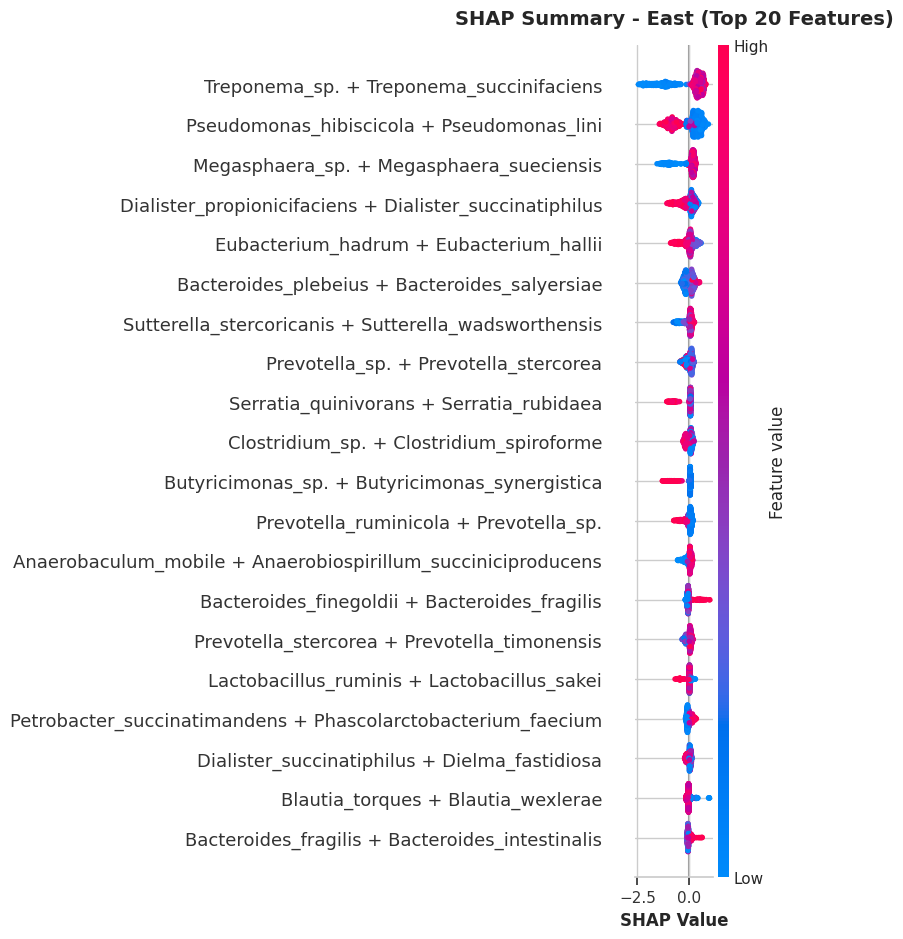

  ✅ Saved: sliding_otu_shap_class_east_top20.png

  Generating SHAP plot for: North
  Plotting top 20 features


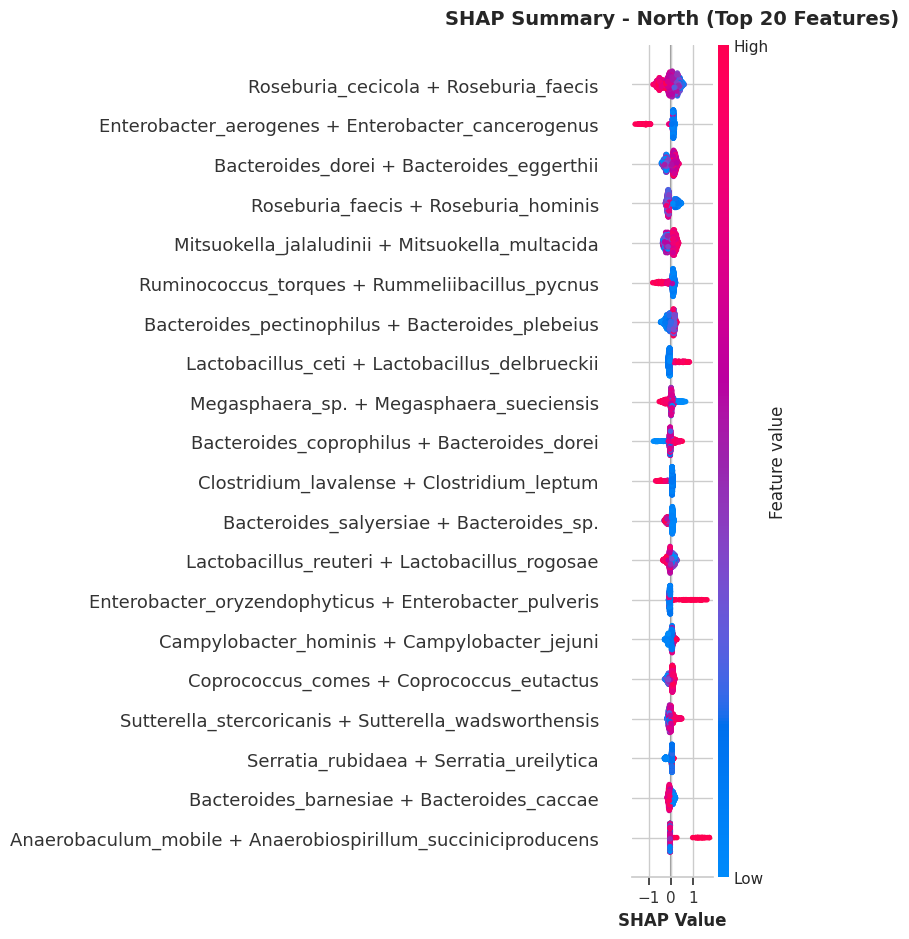

  ✅ Saved: sliding_otu_shap_class_north_top20.png

  Generating SHAP plot for: South
  Plotting top 20 features


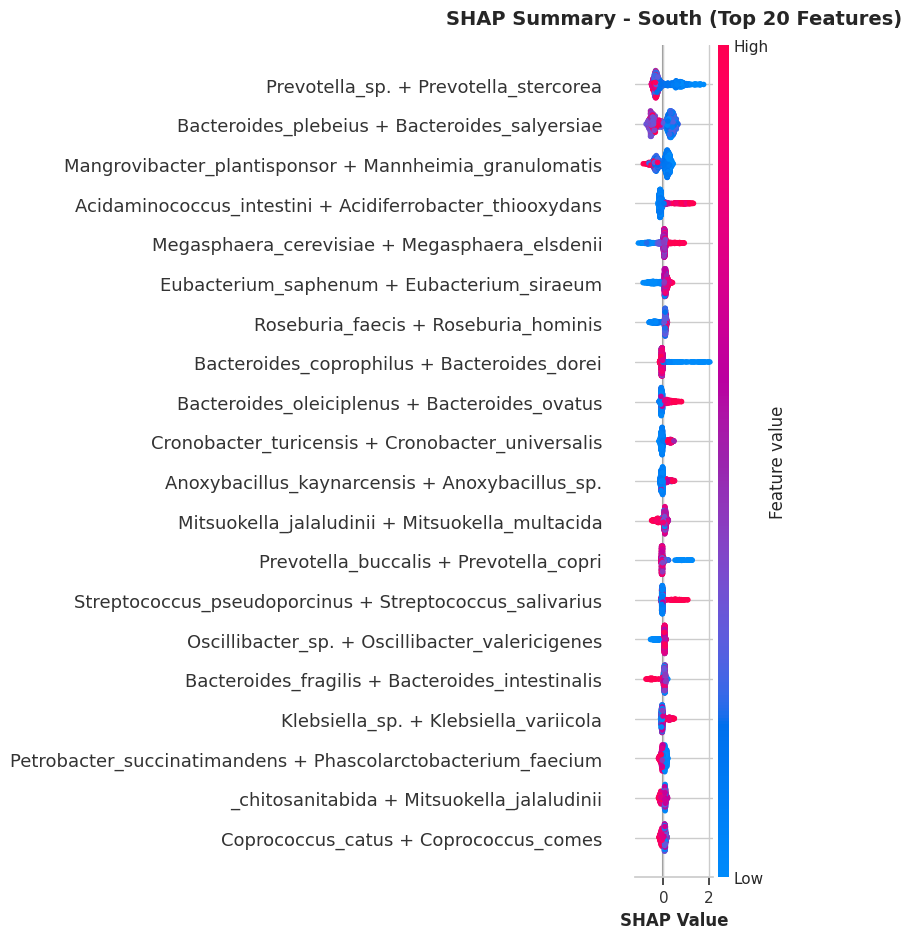

  ✅ Saved: sliding_otu_shap_class_south_top20.png

  Generating SHAP plot for: West
  Plotting top 20 features


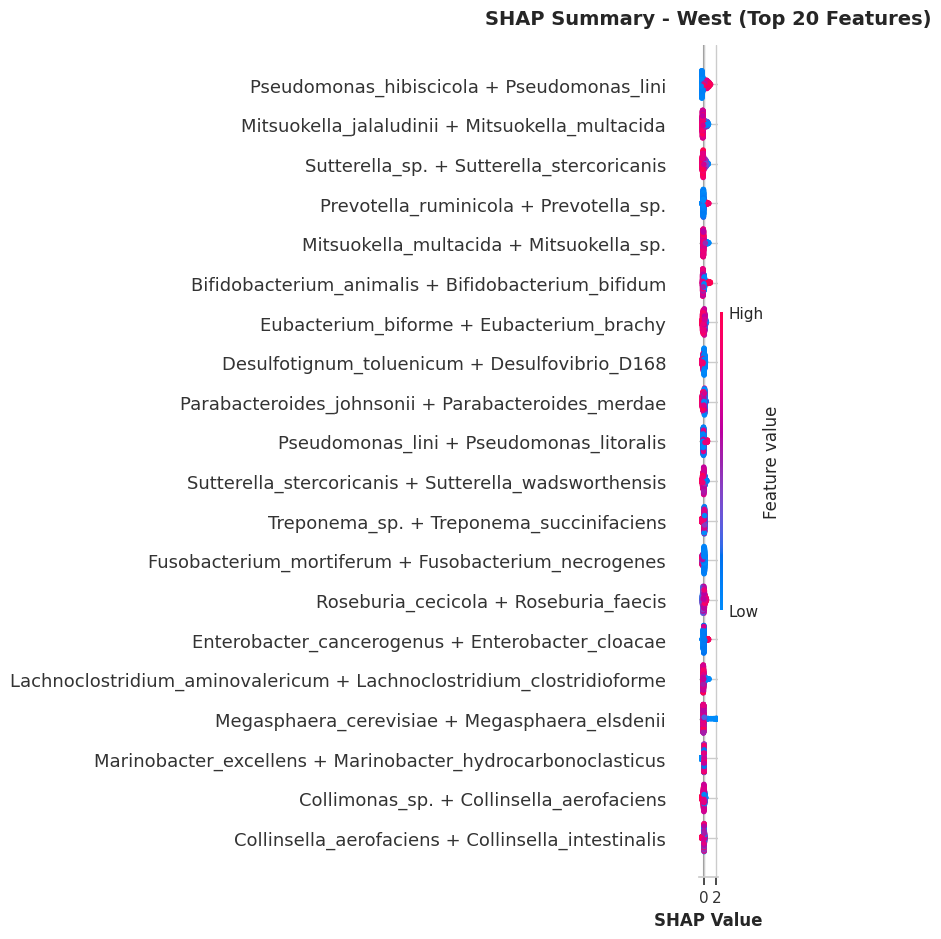

  ✅ Saved: sliding_otu_shap_class_west_top20.png

GENERATING FEATURE IMPORTANCE PLOT
  Including East in importance calculation
  Including North in importance calculation
  Including South in importance calculation
  Including West in importance calculation
  Averaged importance across 4 classes


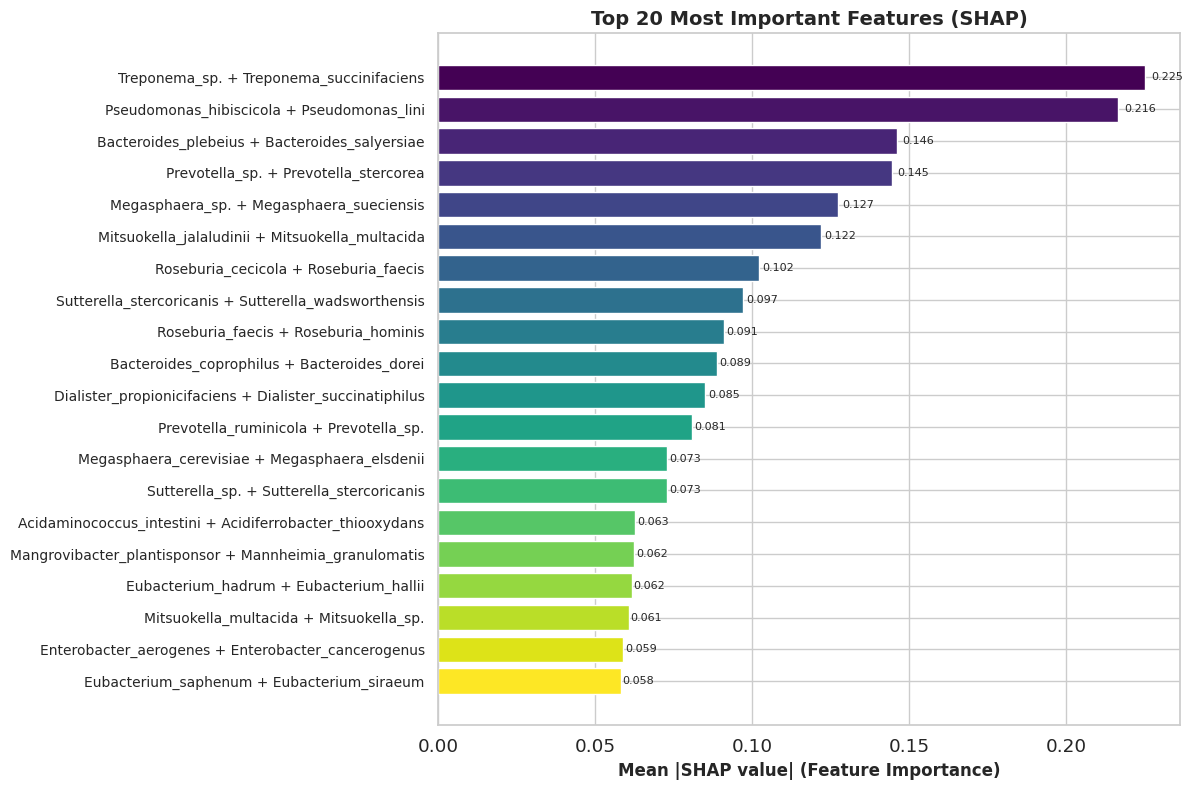

  ✅ Feature importance plot generated successfully

TOP 10 MOST IMPORTANT FEATURES
                                             feature  importance
            Treponema_sp. + Treponema_succinifaciens    0.224923
          Pseudomonas_hibiscicola + Pseudomonas_lini    0.216301
       Bacteroides_plebeius + Bacteroides_salyersiae    0.146188
               Prevotella_sp. + Prevotella_stercorea    0.144599
            Megasphaera_sp. + Megasphaera_sueciensis    0.127482
     Mitsuokella_jalaludinii + Mitsuokella_multacida    0.121875
               Roseburia_cecicola + Roseburia_faecis    0.102153
Sutterella_stercoricanis + Sutterella_wadsworthensis    0.097215
                Roseburia_faecis + Roseburia_hominis    0.090964
         Bacteroides_coprophilus + Bacteroides_dorei    0.088757

✅ Results saved to 'sliding_otu_shap_feature_importance.csv'


In [86]:
# =============================================================================
# 14. GENERATE SHAP VALUES AND EXECUTE PLOTTING (CORRECTED)
# =============================================================================
print("\n" + "="*70)
print("CALCULATING SHAP VALUES")
print("="*70)

try:
    explainer = shap.TreeExplainer(model)
    shap_values_raw = explainer.shap_values(X)

    print(f"Raw SHAP values type: {type(shap_values_raw)}")
    print(f"Raw SHAP values shape: {shap_values_raw.shape if hasattr(shap_values_raw, 'shape') else 'N/A'}")

    # 💡 CORRECTED LOGIC FOR SHAP VALUES
    if isinstance(shap_values_raw, list):
        # Already in the correct format for a multiclass model
        shap_values_list = shap_values_raw
        print(f"✅ Found list format with {len(shap_values_list)} elements")
    elif isinstance(shap_values_raw, np.ndarray):
        if shap_values_raw.ndim == 3:
            # For LightGBM: typically (n_samples, n_features, n_classes)
            # We need to permute to get (n_samples, n_classes, n_features)
            # Then extract each class
            n_samples, n_features, n_classes = shap_values_raw.shape
            print(f"  3D array detected: (samples={n_samples}, features={n_features}, classes={n_classes})")
            
            # Reshape: move class dimension to position 1
            shap_permuted = np.transpose(shap_values_raw, (0, 2, 1))  # (n_samples, n_classes, n_features)
            shap_values_list = [shap_permuted[:, i, :] for i in range(n_classes)]
            print(f"✅ Converted 3D array to list with {len(shap_values_list)} classes")
        else:
            print(f"❌ Unexpected array dimensions: {shap_values_raw.ndim}D array")
            shap_values_list = []
    else:
        print(f"❌ Unexpected SHAP format: {type(shap_values_raw)}")
        shap_values_list = []

    # Final verification of class count before plotting
    if len(shap_values_list) != len(le.classes_):
        print(f"❌ Class count mismatch: Expected {len(le.classes_)}, but SHAP values have {len(shap_values_list)} elements.")
        print("This indicates an issue with the model or SHAP's output format.")
        shap_values_list = []
    else:
        print(f"✅ Class count verified: {len(shap_values_list)} classes")
    
    # Print info about each class to verify dimensions
    for i, sv in enumerate(shap_values_list):
        class_name = le.classes_[i] if i < len(le.classes_) else f"Class_{i}"
        if sv is not None:
            print(f"  Class {i} ({class_name}): shape {sv.shape}")
        else:
            print(f"  Class {i} ({class_name}): None")

except Exception as e:
    print(f"❌ Error calculating SHAP values: {e}")
    import traceback
    traceback.print_exc()
    shap_values_list = []

if len(shap_values_list) > 0:
    # Generate plots
    plot_shap_summary_safe(shap_values_list, X, le, max_display=20)
    importance_df = plot_feature_importance_safe(shap_values_list, X, le, top_n=20)

    if importance_df is not None:
        print("\n" + "="*70)
        print("TOP 10 MOST IMPORTANT FEATURES")
        print("="*70)
        print(importance_df.head(10).to_string(index=False))

        # Save results
        importance_df.to_csv('sliding_otu_shap_feature_importance.csv', index=False)
        print(f"\n✅ Results saved to 'sliding_otu_shap_feature_importance.csv'")
else:
    print("❌ Cannot proceed with plotting. SHAP values could not be calculated correctly.")

# Comparision of all classifiers

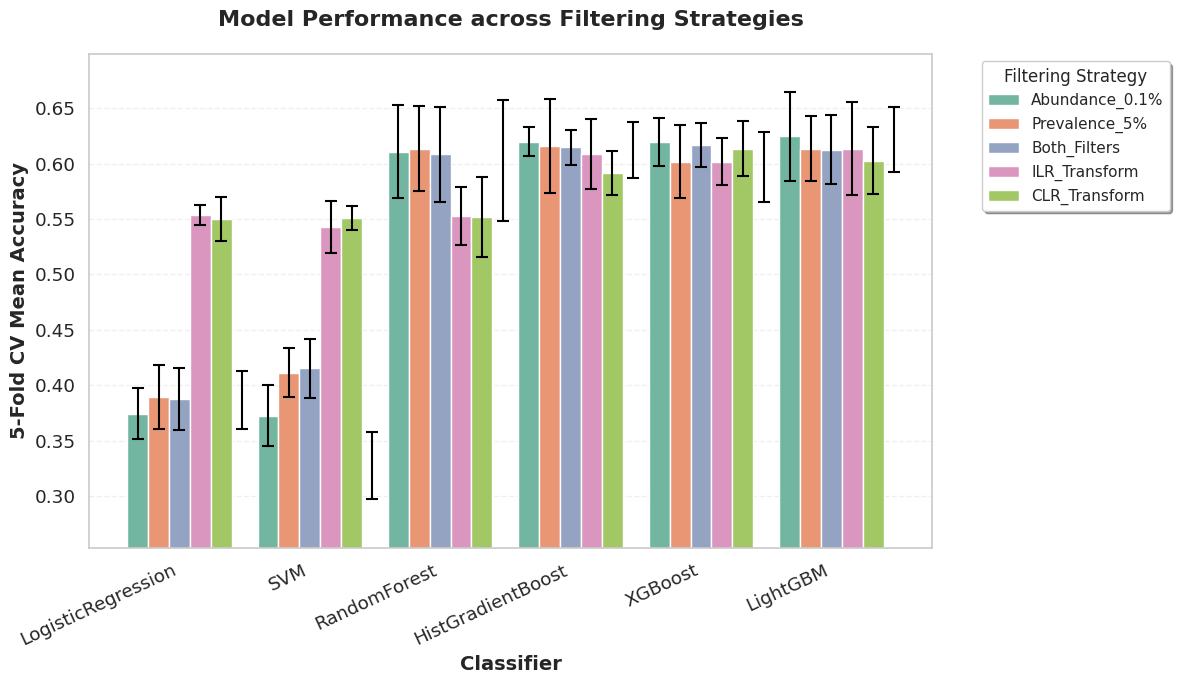


SUMMARY STATISTICS
                   CV_Accuracy_Mean                 CV_Accuracy_Std
                               mean     min     max            mean
Filtering_Strategy                                                 
Abundance_0.1%               0.5369  0.3726  0.6245          0.0279
Prevalence_5%                0.5409  0.3895  0.6156          0.0323
Both_Filters                 0.5425  0.3875  0.6166          0.0274
ILR_Transform                0.5789  0.5428  0.6136          0.0256
CLR_Transform                0.5767  0.5498  0.6136          0.0237


In [150]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load data
#df = pd.read_excel("/home/user/Documents/Sandhya/AI_in_medicine_lab/AI project/geographical_zone_tuned_results.xlsx")
df = pd.read_excel("/home/user/Documents/Sandhya/AI_in_medicine_lab/AI project/geo_location_all_models_tuned.xlsx")

# Define custom order for classifiers
classifier_order = [
    'LogisticRegression', 
    'SVM', 
    'RandomForest', 
    'HistGradientBoost', 
    'XGBoost', 
    'LightGBM'
]

# Define custom order for filtering strategies
filtering_order = [
    'Abundance_0.1%',
    'Prevalence_5%',
    'Both_Filters',
    'ILR_Transform',
    'CLR_Transform'
]

# Apply categorical ordering
df['Classifier'] = pd.Categorical(df['Classifier'], categories=classifier_order, ordered=True)
df['Filtering_Strategy'] = pd.Categorical(df['Filtering_Strategy'], categories=filtering_order, ordered=True)

# Sort by both columns
df = df.sort_values(['Classifier', 'Filtering_Strategy'])

# Set plot aesthetics
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 12})

fig, ax = plt.subplots(figsize=(12, 7))

# Create barplot without built-in error bars
barplot = sns.barplot(
    data=df,
    x="Classifier",
    y="CV_Accuracy_Mean",
    hue="Filtering_Strategy",
    palette="Set2",
    ax=ax,
    errorbar=None  # Disable automatic error bars
)

# Get the bar positions and add error bars manually
# Number of unique filtering strategies
n_strategies = df['Filtering_Strategy'].nunique()
n_classifiers = df['Classifier'].nunique()

# Calculate bar positions
x_positions = []
for i, classifier in enumerate(df['Classifier'].unique()):
    subset = df[df['Classifier'] == classifier]
    # Calculate positions for bars within each classifier group
    for j, strategy in enumerate(subset['Filtering_Strategy']):
        # Position calculation for grouped bars
        bar_width = 0.8 / n_strategies
        offset = (j - n_strategies/2 + 0.5) * bar_width
        x_positions.append(i + offset)

# Add error bars
for idx, (x_pos, row) in enumerate(zip(x_positions, df.itertuples())):
    ax.errorbar(
        x_pos, 
        row.CV_Accuracy_Mean,
        yerr=row.CV_Accuracy_Std,
        fmt='none', 
        ecolor='black', 
        elinewidth=1.5, 
        capsize=4,
        capthick=1.5,
        zorder=10  # Ensure error bars appear on top
    )

# Labeling and styling
ax.set_ylabel("5-Fold CV Mean Accuracy", fontsize=14, fontweight='bold')
ax.set_xlabel("Classifier", fontsize=14, fontweight='bold')
ax.set_title("Model Performance across Filtering Strategies", 
             fontsize=16, pad=20, fontweight='bold')

# Improve legend
ax.legend(
    title="Filtering Strategy", 
    title_fontsize=12,
    fontsize=11,
    bbox_to_anchor=(1.05, 1), 
    loc="upper left",
    frameon=True,
    shadow=True
)

# Rotate x-axis labels
plt.xticks(rotation=25, ha='right')

# Add grid for better readability
ax.yaxis.grid(True, alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

# Set y-axis limits with some padding
y_min = df['CV_Accuracy_Mean'].min() - df['CV_Accuracy_Std'].max() - 0.02
y_max = df['CV_Accuracy_Mean'].max() + df['CV_Accuracy_Std'].max() + 0.02
ax.set_ylim(y_min, y_max)

plt.tight_layout()
plt.show()

# Optional: Print summary statistics
print("\n" + "="*70)
print("SUMMARY STATISTICS")
print("="*70)
summary = df.groupby('Filtering_Strategy').agg({
    'CV_Accuracy_Mean': ['mean', 'min', 'max'],
    'CV_Accuracy_Std': 'mean'
}).round(4)
print(summary)
print("="*70)

Total rows: 30
Classifiers: ['HistGradientBoost', 'LightGBM', 'LogisticRegression', 'RandomForest', 'SVM', 'XGBoost']
Filtering strategies: ['Abundance_0.1%', 'Both_Filters', 'CLR_Transform', 'ILR_Transform', 'Prevalence_5%']

Number of bars: 35
Number of data rows: 30


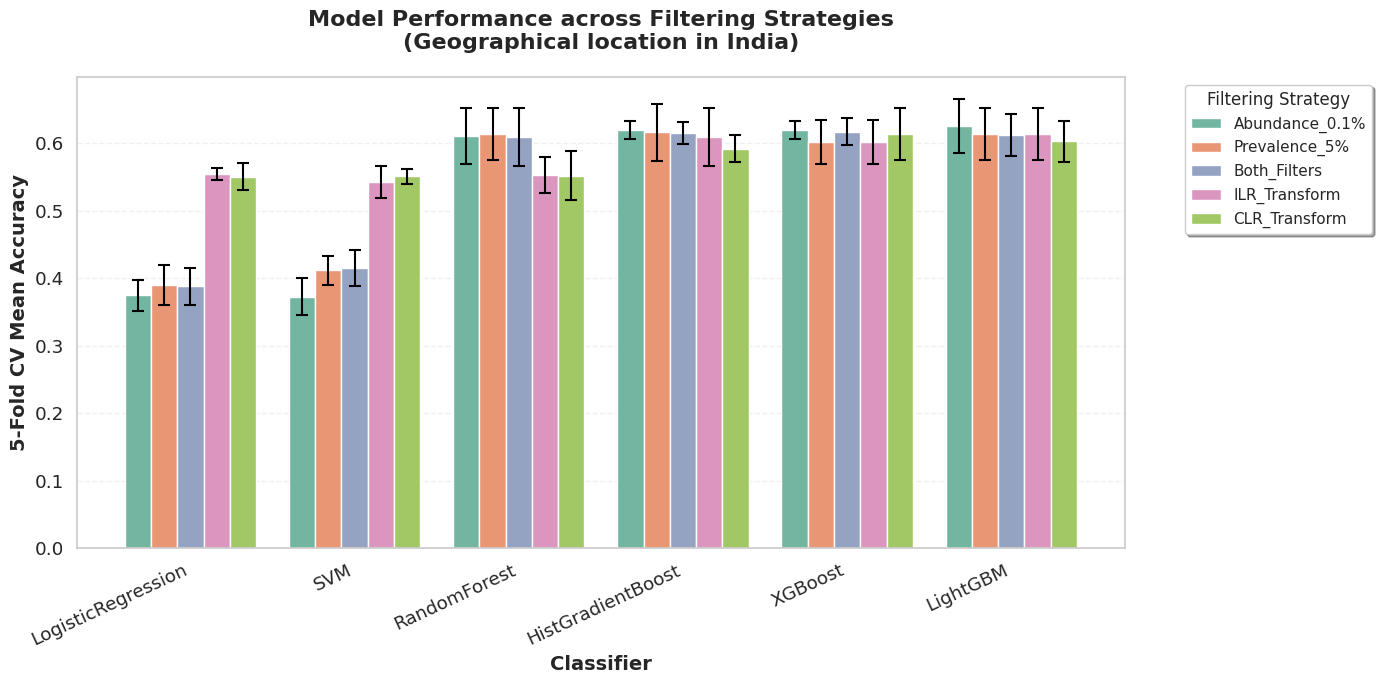


SUMMARY STATISTICS
                   CV_Accuracy_Mean                 CV_Accuracy_Std
                               mean     min     max            mean
Filtering_Strategy                                                 
Abundance_0.1%               0.5369  0.3726  0.6245          0.0279
Prevalence_5%                0.5409  0.3895  0.6156          0.0323
Both_Filters                 0.5425  0.3875  0.6166          0.0274
ILR_Transform                0.5789  0.5428  0.6136          0.0256
CLR_Transform                0.5767  0.5498  0.6136          0.0237

TOP 5 BEST PERFORMING COMBINATIONS
       Classifier Filtering_Strategy  CV_Accuracy_Mean  CV_Accuracy_Std
         LightGBM     Abundance_0.1%          0.624527         0.040019
HistGradientBoost     Abundance_0.1%          0.619527         0.013024
          XGBoost     Abundance_0.1%          0.619527         0.021830
          XGBoost       Both_Filters          0.616552         0.019799
HistGradientBoost      Prevalence_5%    

In [155]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load data
#df = pd.read_excel("your_file.xlsx")  # or read_csv if it's a CSV

# Filter to Geographical zone in India only
#df = df[df['Target_Feature'] == 'Geographical zone in India'].copy()

# Define custom order for classifiers
classifier_order = [
    'LogisticRegression', 
    'SVM', 
    'RandomForest', 
    'HistGradientBoost', 
    'XGBoost', 
    'LightGBM'
]

# Define custom order for filtering strategies
filtering_order = [
    'Abundance_0.1%',
    'Prevalence_5%',
    'Both_Filters',
    'ILR_Transform',
    'CLR_Transform',
    'No_Filtering'
]

# Filter to only include classifiers/strategies that exist in data
df['Classifier'] = pd.Categorical(
    df['Classifier'], 
    categories=[c for c in classifier_order if c in df['Classifier'].values],
    ordered=True
)
df['Filtering_Strategy'] = pd.Categorical(
    df['Filtering_Strategy'],
    categories=[f for f in filtering_order if f in df['Filtering_Strategy'].values],
    ordered=True
)

# Remove rows with NaN in categorical columns
df = df.dropna(subset=['Classifier', 'Filtering_Strategy'])

# Sort by both columns
df = df.sort_values(['Classifier', 'Filtering_Strategy']).reset_index(drop=True)

print(f"Total rows: {len(df)}")
print(f"Classifiers: {sorted(df['Classifier'].unique())}")
print(f"Filtering strategies: {sorted(df['Filtering_Strategy'].unique())}\n")

# Set plot aesthetics
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 12})

fig, ax = plt.subplots(figsize=(14, 7))

# Create barplot without error bars
barplot = sns.barplot(
    data=df,
    x="Classifier",
    y="CV_Accuracy_Mean",
    hue="Filtering_Strategy",
    palette="Set2",
    ax=ax,
    errorbar=None
)

# Get bar patches and add error bars
bar_patches = [p for p in ax.patches if isinstance(p, plt.Rectangle)]

print(f"Number of bars: {len(bar_patches)}")
print(f"Number of data rows: {len(df)}")

# For each bar, find matching row by its height (CV_Accuracy_Mean)
for bar in bar_patches:
    x_pos = bar.get_x() + bar.get_width() / 2
    y_pos = bar.get_height()
    
    # Find the row with matching accuracy value
    for idx, row in df.iterrows():
        if abs(y_pos - row['CV_Accuracy_Mean']) < 0.0001:
            ax.errorbar(
                x_pos, 
                row['CV_Accuracy_Mean'],
                yerr=row['CV_Accuracy_Std'],
                fmt='none', 
                ecolor='black', 
                elinewidth=1.5, 
                capsize=4,
                capthick=1.5,
                zorder=10
            )
            break

# Labeling and styling
ax.set_ylabel("5-Fold CV Mean Accuracy", fontsize=14, fontweight='bold')
ax.set_xlabel("Classifier", fontsize=14, fontweight='bold')
ax.set_title("Model Performance across Filtering Strategies\n(Geographical location in India)", 
             fontsize=16, pad=20, fontweight='bold')

# Improve legend
ax.legend(
    title="Filtering Strategy", 
    title_fontsize=12,
    fontsize=11,
    bbox_to_anchor=(1.05, 1), 
    loc="upper left",
    frameon=True,
    shadow=True
)

# Rotate x-axis labels
plt.xticks(rotation=25, ha='right')

# Add grid for better readability
ax.yaxis.grid(True, alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

# Set y-axis limits with some padding
#y_min = df['CV_Accuracy_Mean'].min() - df['CV_Accuracy_Std'].max() - 0.02
#y_max = df['CV_Accuracy_Mean'].max() + df['CV_Accuracy_Std'].max() + 0.02
#ax.set_ylim(max(0.4, y_min), min(0.75, y_max))

plt.tight_layout()
plt.savefig('model_performance_geographical_location.png', dpi=150, bbox_inches='tight')
plt.show()

# Print summary statistics
print("\n" + "="*70)
print("SUMMARY STATISTICS")
print("="*70)
summary = df.groupby('Filtering_Strategy').agg({
    'CV_Accuracy_Mean': ['mean', 'min', 'max'],
    'CV_Accuracy_Std': 'mean'
}).round(4)
print(summary)

print("\n" + "="*70)
print("TOP 5 BEST PERFORMING COMBINATIONS")
print("="*70)
top_5 = df.nlargest(5, 'CV_Accuracy_Mean')[['Classifier', 'Filtering_Strategy', 'CV_Accuracy_Mean', 'CV_Accuracy_Std']]
print(top_5.to_string(index=False))

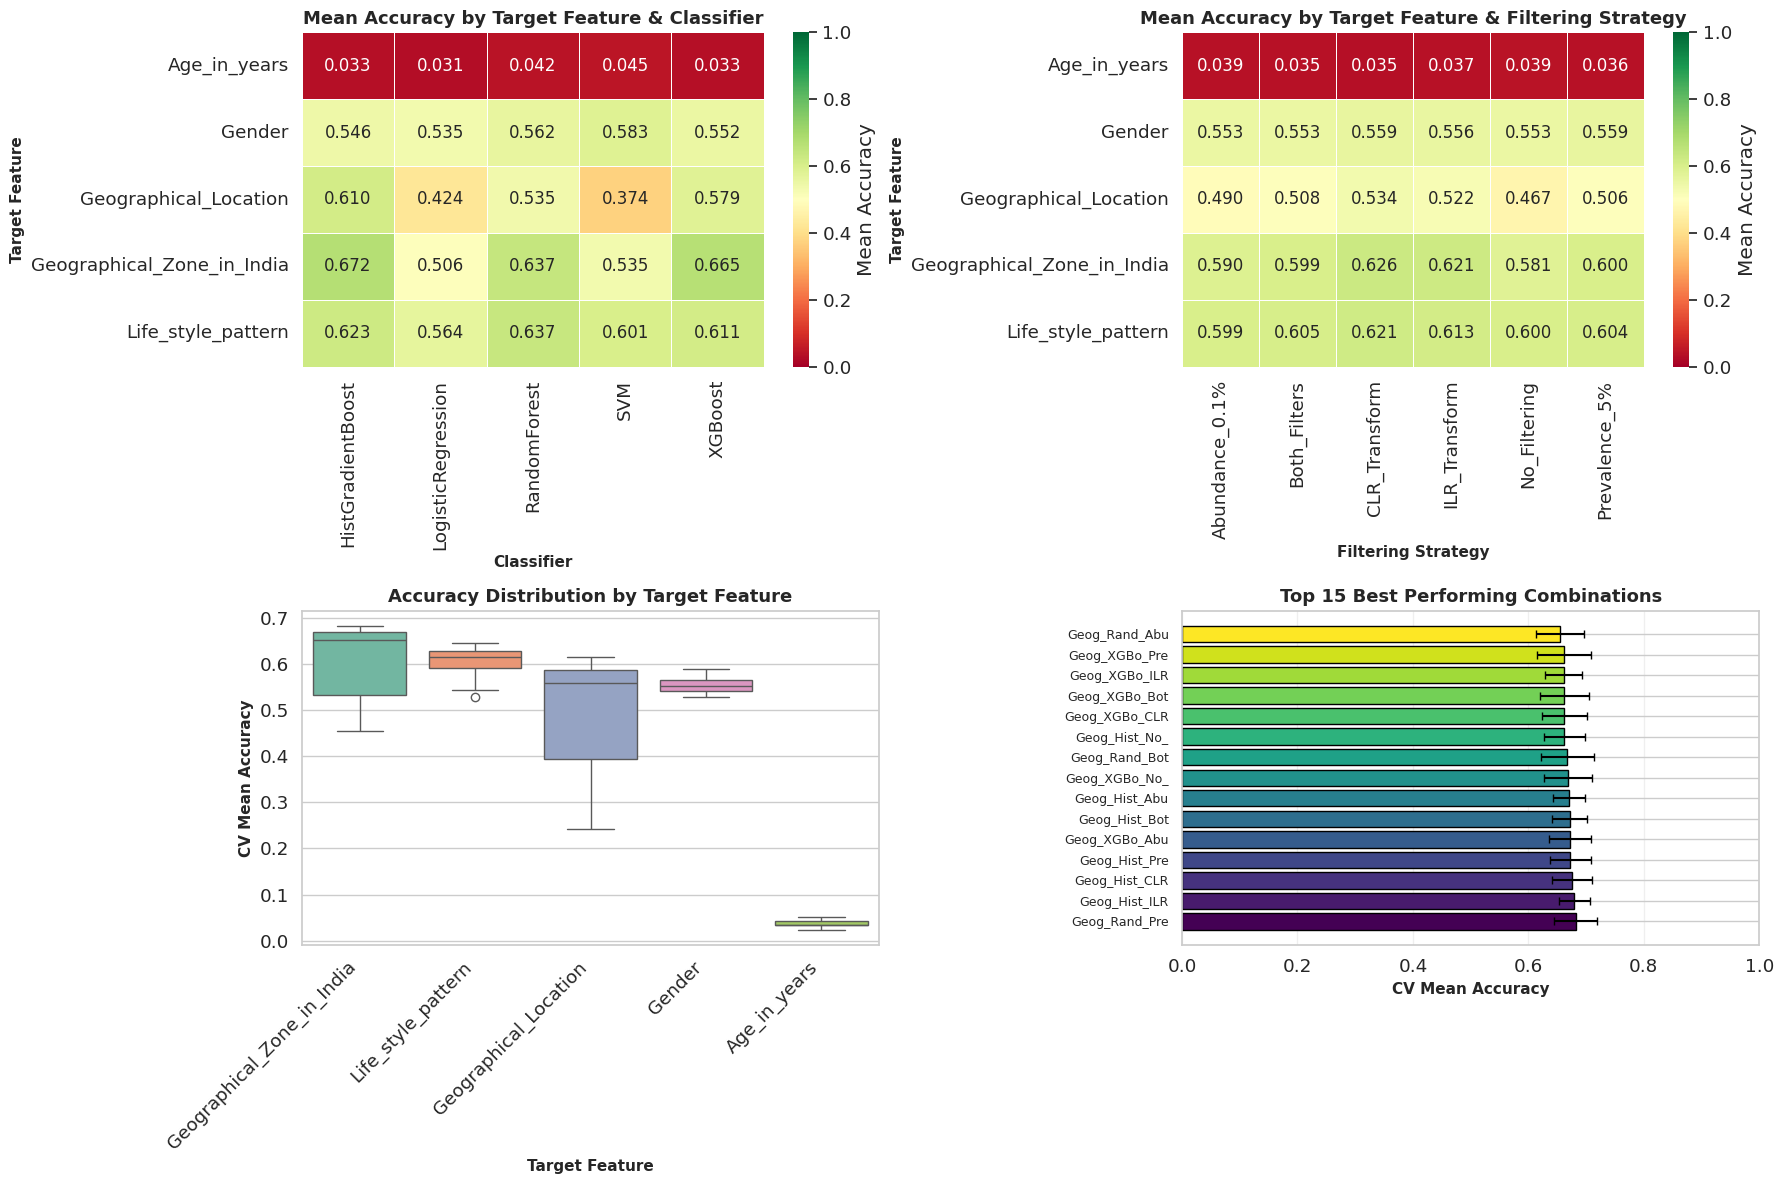


SUMMARY STATISTICS BY TARGET FEATURE

Geographical_Zone_in_India:
  Best accuracy: 0.6822 ± 0.0370
  Mean accuracy: 0.6030
  Worst accuracy: 0.4551
  Best combination: RandomForest + Prevalence_5%

Life_style_pattern:
  Best accuracy: 0.6444 ± 0.0346
  Mean accuracy: 0.6070
  Worst accuracy: 0.5279
  Best combination: RandomForest + Both_Filters

Geographical_Location:
  Best accuracy: 0.6155 ± 0.0439
  Mean accuracy: 0.5045
  Worst accuracy: 0.2421
  Best combination: HistGradientBoost + Both_Filters

Gender:
  Best accuracy: 0.5896 ± 0.0092
  Mean accuracy: 0.5556
  Worst accuracy: 0.5278
  Best combination: SVM + CLR_Transform

Age_in_years:
  Best accuracy: 0.0518 ± 0.0068
  Mean accuracy: 0.0368
  Worst accuracy: 0.0239
  Best combination: SVM + Abundance_0.1%

CLASSIFIER PERFORMANCE (Averaged across all features & strategies)
                      mean     std     min     max
Classifier                                        
HistGradientBoost   0.4965  0.2396  0.0269  0.6793
XG

In [116]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load data
df = pd.read_excel("/home/user/Documents/Sandhya/AI_in_medicine_lab/AI project/all_classifiers_new.xlsx")

# Create a figure with multiple subplots for different perspectives
fig = plt.figure(figsize=(18, 12))

# =============================================================================
# 1. HEATMAP: Performance by Target Feature and Classifier
# =============================================================================
ax1 = plt.subplot(2, 2, 1)

# Aggregate by target feature and classifier (average across filtering strategies)
pivot_target_classifier = df.groupby(['Target_Feature', 'Classifier'])['CV_Accuracy_Mean'].mean().reset_index()
heatmap_data = pivot_target_classifier.pivot(index='Target_Feature', columns='Classifier', values='CV_Accuracy_Mean')

sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='RdYlGn', vmin=0, vmax=1, 
            ax=ax1, cbar_kws={'label': 'Mean Accuracy'}, linewidths=0.5)
ax1.set_title('Mean Accuracy by Target Feature & Classifier', fontsize=13, fontweight='bold')
ax1.set_xlabel('Classifier', fontsize=11, fontweight='bold')
ax1.set_ylabel('Target Feature', fontsize=11, fontweight='bold')

# =============================================================================
# 2. HEATMAP: Performance by Target Feature and Filtering Strategy
# =============================================================================
ax2 = plt.subplot(2, 2, 2)

pivot_target_strategy = df.groupby(['Target_Feature', 'Filtering_Strategy'])['CV_Accuracy_Mean'].mean().reset_index()
heatmap_data2 = pivot_target_strategy.pivot(index='Target_Feature', columns='Filtering_Strategy', values='CV_Accuracy_Mean')

sns.heatmap(heatmap_data2, annot=True, fmt='.3f', cmap='RdYlGn', vmin=0, vmax=1,
            ax=ax2, cbar_kws={'label': 'Mean Accuracy'}, linewidths=0.5)
ax2.set_title('Mean Accuracy by Target Feature & Filtering Strategy', fontsize=13, fontweight='bold')
ax2.set_xlabel('Filtering Strategy', fontsize=11, fontweight='bold')
ax2.set_ylabel('Target Feature', fontsize=11, fontweight='bold')

# =============================================================================
# 3. BOX PLOT: Distribution of Accuracy across Target Features
# =============================================================================
ax3 = plt.subplot(2, 2, 3)

sns.boxplot(data=df, x='Target_Feature', y='CV_Accuracy_Mean', ax=ax3, palette='Set2')
ax3.set_title('Accuracy Distribution by Target Feature', fontsize=13, fontweight='bold')
ax3.set_xlabel('Target Feature', fontsize=11, fontweight='bold')
ax3.set_ylabel('CV Mean Accuracy', fontsize=11, fontweight='bold')
ax3.tick_params(axis='x', rotation=45)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')

# =============================================================================
# 4. BAR PLOT: Top 15 Best Performing Combinations
# =============================================================================
ax4 = plt.subplot(2, 2, 4)

top_15 = df.nlargest(15, 'CV_Accuracy_Mean').copy()
top_15['Label'] = top_15['Target_Feature'].str.slice(0, 4) + '_' + \
                  top_15['Classifier'].str.slice(0, 4) + '_' + \
                  top_15['Filtering_Strategy'].str.slice(0, 3)

colors = plt.cm.viridis(np.linspace(0, 1, len(top_15)))
bars = ax4.barh(range(len(top_15)), top_15['CV_Accuracy_Mean'], color=colors, edgecolor='black', linewidth=1)

# Add error bars
for i, (idx, row) in enumerate(top_15.iterrows()):
    ax4.errorbar(row['CV_Accuracy_Mean'], i, xerr=row['CV_Accuracy_Std'],
                fmt='none', ecolor='black', elinewidth=1.5, capsize=3, zorder=10)

ax4.set_yticks(range(len(top_15)))
ax4.set_yticklabels(top_15['Label'], fontsize=9)
ax4.set_xlabel('CV Mean Accuracy', fontsize=11, fontweight='bold')
ax4.set_title('Top 15 Best Performing Combinations', fontsize=13, fontweight='bold')
ax4.set_xlim(0, 1)
ax4.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('comprehensive_ml_results.png', dpi=150, bbox_inches='tight')
plt.show()

# =============================================================================
# Print Summary Statistics
# =============================================================================
print("\n" + "="*80)
print("SUMMARY STATISTICS BY TARGET FEATURE")
print("="*80)

for feature in df['Target_Feature'].unique():
    subset = df[df['Target_Feature'] == feature]
    print(f"\n{feature}:")
    print(f"  Best accuracy: {subset['CV_Accuracy_Mean'].max():.4f} ± {subset.loc[subset['CV_Accuracy_Mean'].idxmax(), 'CV_Accuracy_Std']:.4f}")
    print(f"  Mean accuracy: {subset['CV_Accuracy_Mean'].mean():.4f}")
    print(f"  Worst accuracy: {subset['CV_Accuracy_Mean'].min():.4f}")
    best_row = subset.loc[subset['CV_Accuracy_Mean'].idxmax()]
    print(f"  Best combination: {best_row['Classifier']} + {best_row['Filtering_Strategy']}")

print("\n" + "="*80)
print("CLASSIFIER PERFORMANCE (Averaged across all features & strategies)")
print("="*80)
classifier_stats = df.groupby('Classifier')['CV_Accuracy_Mean'].agg(['mean', 'std', 'min', 'max']).round(4)
print(classifier_stats.sort_values('mean', ascending=False))

print("\n" + "="*80)
print("FILTERING STRATEGY PERFORMANCE (Averaged across all features & classifiers)")
print("="*80)
strategy_stats = df.groupby('Filtering_Strategy')['CV_Accuracy_Mean'].agg(['mean', 'std', 'min', 'max']).round(4)
print(strategy_stats.sort_values('mean', ascending=False))

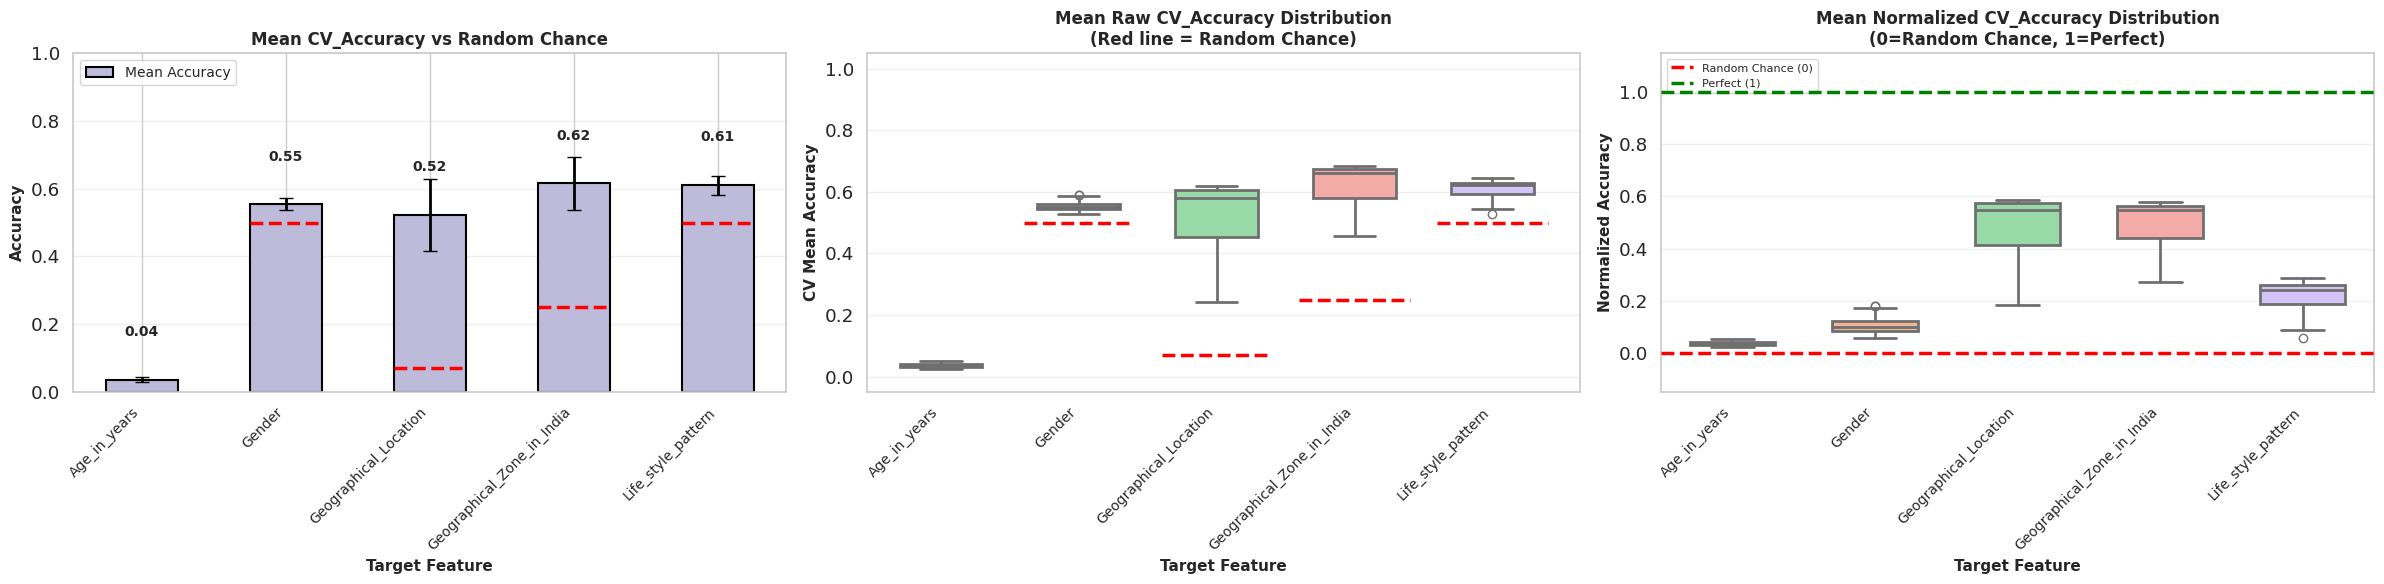

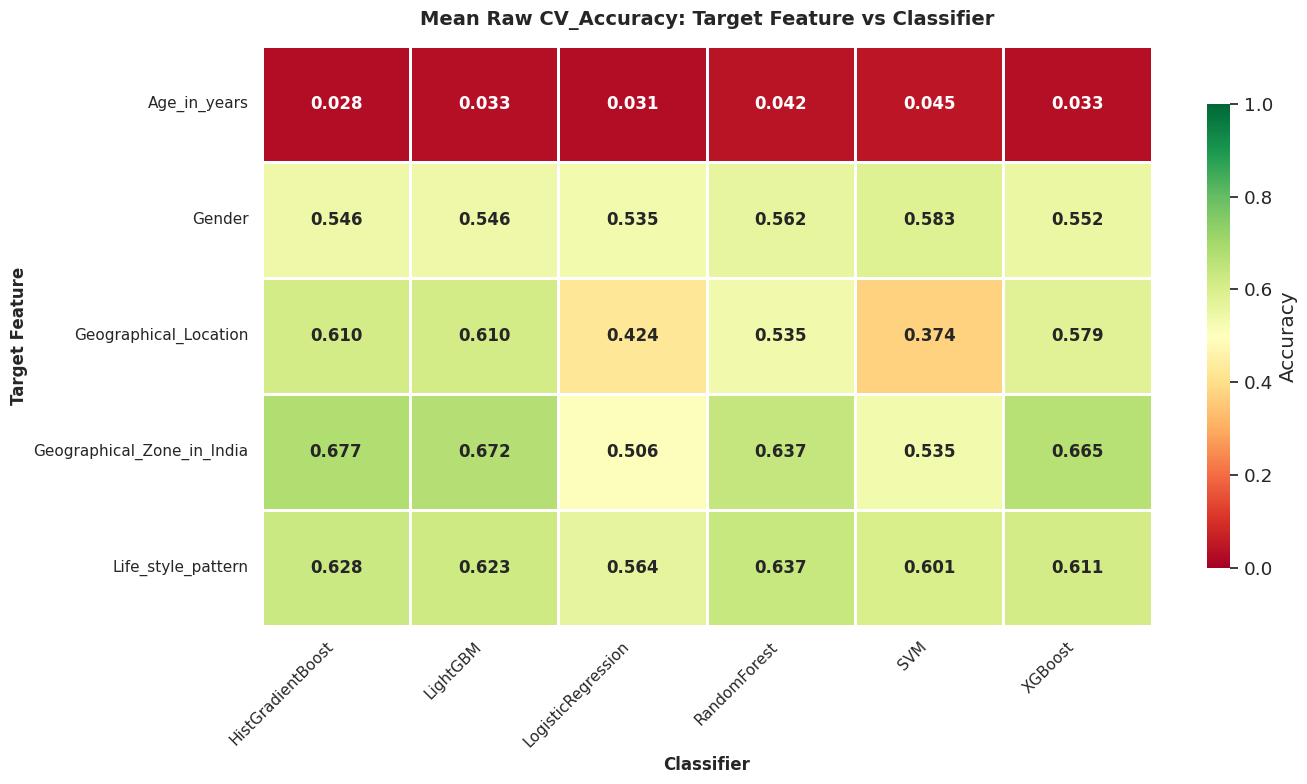

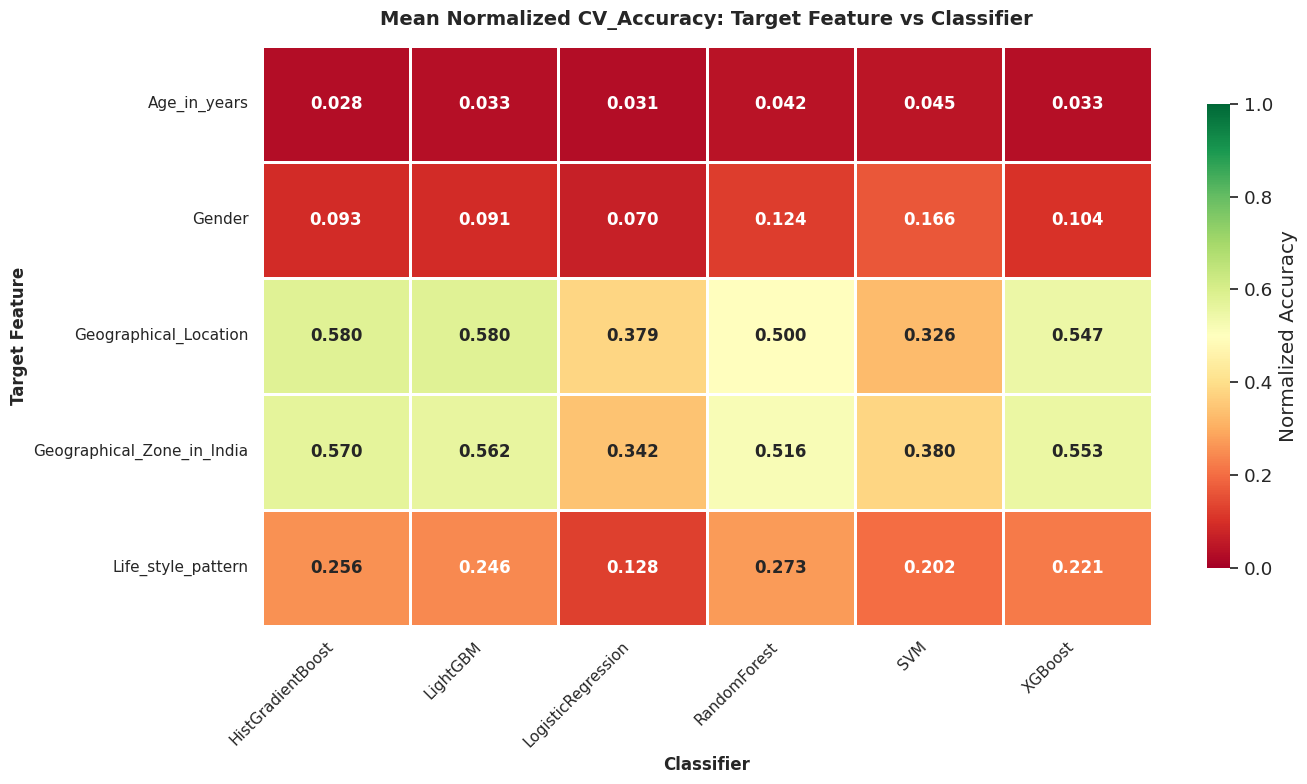

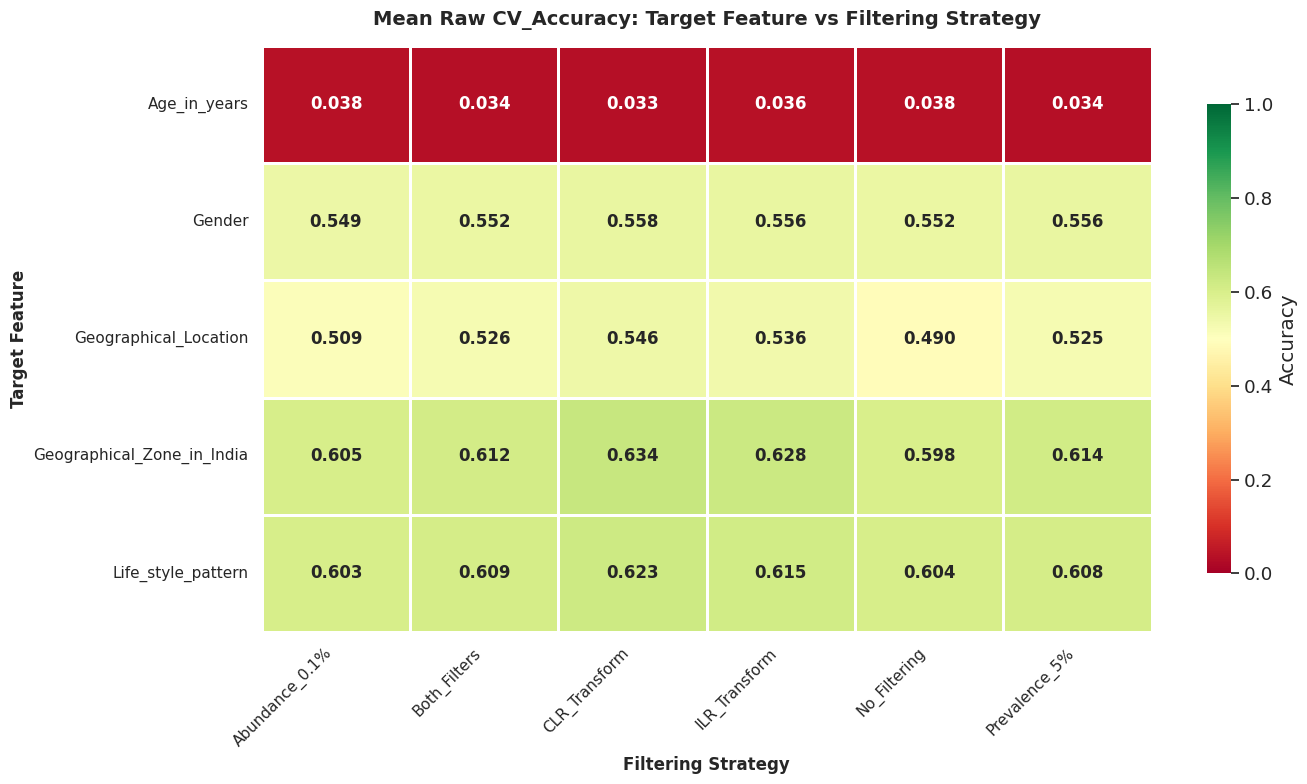


SUMMARY

Age_in_years (Regression - no baseline):
  Mean Raw Accuracy: 3.54%

Gender:
  Baseline: 50.0% | Mean Raw: 55.41% | Mean Normalized: 10.81%

Geographical_Location:
  Baseline: 7.1% | Mean Raw: 52.20% | Mean Normalized: 48.52%

Geographical_Zone_in_India:
  Baseline: 25.0% | Mean Raw: 61.54% | Mean Normalized: 48.72%

Life_style_pattern:
  Baseline: 50.0% | Mean Raw: 61.05% | Mean Normalized: 22.09%


In [143]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load data
df = pd.read_excel("/home/user/Documents/Sandhya/AI_in_medicine_lab/AI project/all_classifiers_new.xlsx")

# Define baselines
baselines = {
    'Geographical_Zone_in_India': 0.25,
    'Life_style_pattern': 0.50,
    'Geographical_Location': 1/14,
    'Gender': 0.50
}

# Handle Age_in_years and other regression targets
for feature in df['Target_Feature'].unique():
    if feature not in baselines:
        baselines[feature] = 0.0

# Calculate normalized accuracy
df['Baseline'] = df['Target_Feature'].map(baselines)
df['Normalized_Accuracy'] = (df['CV_Accuracy_Mean'] - df['Baseline']) / (1 - df['Baseline'])
df['Normalized_Accuracy'] = df['Normalized_Accuracy'].clip(0, 1)

sns.set_style("whitegrid")
sns.set_palette("pastel")

# ============================================================================
# TOP ROW: 3 PLOTS (Bar, Box Raw, Box Normalized)
# ============================================================================
fig1, axes1 = plt.subplots(1, 3, figsize=(24, 6))

# PLOT 1: BAR GRAPH - MEAN ACCURACY BY TARGET WITH BASELINES
ax = axes1[0]

target_stats = df.groupby('Target_Feature').agg({
    'CV_Accuracy_Mean': ['mean', 'std']
}).reset_index()
target_stats.columns = ['Target_Feature', 'Mean_Acc', 'Std_Acc']
target_stats['Baseline'] = target_stats['Target_Feature'].map(baselines)

x = np.arange(len(target_stats))
width = 0.5

bars1 = ax.bar(x, target_stats['Mean_Acc'], width, 
               label='Mean Accuracy', color='#bebada', edgecolor='black', linewidth=1.5)

ax.errorbar(x, target_stats['Mean_Acc'], 
            yerr=target_stats['Std_Acc'], fmt='none', ecolor='black', 
            elinewidth=2, capsize=5, zorder=5)

for i, (idx, row) in enumerate(target_stats.iterrows()):
    if row['Baseline'] > 0:
        ax.hlines(row['Baseline'], i - 0.25, i + 0.25, colors='red', linestyles='--', 
                 linewidth=2.5, label='Random Chance' if i == 0 else '', zorder=10)

ax.set_xlabel('Target Feature', fontsize=11, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=11, fontweight='bold')
ax.set_title('Mean CV_Accuracy vs Random Chance', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(target_stats['Target_Feature'], rotation=45, ha='right', fontsize=10)
ax.set_ylim(0, 1)
ax.legend(fontsize=10, loc='upper left')
ax.grid(axis='y', alpha=0.3)

for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.12,
            f'{height:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# PLOT 2: BOX PLOT - RAW ACCURACY BY TARGET
ax = axes1[1]

target_order = sorted(df['Target_Feature'].unique())
df_sorted = df.copy()
df_sorted['Target_Feature'] = pd.Categorical(df_sorted['Target_Feature'], 
                                              categories=target_order, ordered=True)

sns.boxplot(data=df_sorted, x='Target_Feature', y='CV_Accuracy_Mean', ax=ax,
            palette='pastel', width=0.6, linewidth=2, order=target_order)

for i, target in enumerate(target_order):
    baseline = baselines.get(target, 0)
    if baseline > 0:
        ax.hlines(baseline, i - 0.4, i + 0.4, colors='red', linestyles='--', linewidth=2.5, zorder=10)

ax.set_xlabel('Target Feature', fontsize=11, fontweight='bold')
ax.set_ylabel('CV Mean Accuracy', fontsize=11, fontweight='bold')
ax.set_title('Mean Raw CV_Accuracy Distribution\n(Red line = Random Chance)', fontsize=12, fontweight='bold')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right', fontsize=10)
ax.set_ylim(-0.05, 1.05)
ax.grid(axis='y', alpha=0.3, zorder=0)

# PLOT 3: BOX PLOT - NORMALIZED ACCURACY BY TARGET
ax = axes1[2]

sns.boxplot(data=df_sorted, x='Target_Feature', y='Normalized_Accuracy', ax=ax,
            palette='pastel', width=0.6, linewidth=2, order=target_order)

ax.axhline(y=0, color='red', linestyle='--', linewidth=2.5, label='Random Chance (0)', zorder=10)
ax.axhline(y=1, color='green', linestyle='--', linewidth=2.5, label='Perfect (1)', zorder=10)

ax.set_xlabel('Target Feature', fontsize=11, fontweight='bold')
ax.set_ylabel('Normalized Accuracy', fontsize=11, fontweight='bold')
ax.set_title('Mean Normalized CV_Accuracy Distribution\n(0=Random Chance, 1=Perfect)', fontsize=12, fontweight='bold')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right', fontsize=10)
ax.set_ylim(-0.15, 1.15)
ax.grid(axis='y', alpha=0.3, zorder=0)
ax.legend(fontsize=8, loc='upper left')

plt.tight_layout()
plt.savefig('ml_results_top_row.png', dpi=150, bbox_inches='tight')
plt.show()

# ============================================================================
# HEATMAP 1: RAW ACCURACY (Target vs Classifier)
# ============================================================================
fig2, ax = plt.subplots(figsize=(14, 8))

pivot_raw_1 = df.groupby(['Target_Feature', 'Classifier'])['CV_Accuracy_Mean'].mean().reset_index()
heatmap_raw_1 = pivot_raw_1.pivot(index='Target_Feature', columns='Classifier', values='CV_Accuracy_Mean')

sns.heatmap(heatmap_raw_1, annot=True, fmt='.3f', cmap='RdYlGn', vmin=0, vmax=1, 
            ax=ax, cbar_kws={'label': 'Accuracy', 'shrink': 0.8}, linewidths=2, linecolor='white', 
            annot_kws={'size': 12, 'weight': 'bold'})
ax.set_title('Mean Raw CV_Accuracy: Target Feature vs Classifier', fontsize=14, fontweight='bold', pad=15)
ax.set_ylabel('Target Feature', fontsize=12, fontweight='bold')
ax.set_xlabel('Classifier', fontsize=12, fontweight='bold')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right', fontsize=11)
plt.setp(ax.yaxis.get_majorticklabels(), rotation=0, fontsize=11)

plt.tight_layout()
plt.savefig('heatmap_raw_vs_classifier.png', dpi=150, bbox_inches='tight')
plt.show()

# ============================================================================
# HEATMAP 2: NORMALIZED ACCURACY (Target vs Classifier)
# ============================================================================
fig3, ax = plt.subplots(figsize=(14, 8))

pivot_norm_1 = df.groupby(['Target_Feature', 'Classifier'])['Normalized_Accuracy'].mean().reset_index()
heatmap_norm_1 = pivot_norm_1.pivot(index='Target_Feature', columns='Classifier', values='Normalized_Accuracy')

sns.heatmap(heatmap_norm_1, annot=True, fmt='.3f', cmap='RdYlGn', vmin=0, vmax=1, 
            ax=ax, cbar_kws={'label': 'Normalized Accuracy', 'shrink': 0.8}, linewidths=2, linecolor='white',
            annot_kws={'size': 12, 'weight': 'bold'})
ax.set_title('Mean Normalized CV_Accuracy: Target Feature vs Classifier', fontsize=14, fontweight='bold', pad=15)
ax.set_ylabel('Target Feature', fontsize=12, fontweight='bold')
ax.set_xlabel('Classifier', fontsize=12, fontweight='bold')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right', fontsize=11)
plt.setp(ax.yaxis.get_majorticklabels(), rotation=0, fontsize=11)

plt.tight_layout()
plt.savefig('heatmap_normalized_vs_classifier.png', dpi=150, bbox_inches='tight')
plt.show()

# ============================================================================
# HEATMAP 3: RAW ACCURACY (Target vs Filtering Strategy)
# ============================================================================
fig4, ax = plt.subplots(figsize=(14, 8))

pivot_raw_2 = df.groupby(['Target_Feature', 'Filtering_Strategy'])['CV_Accuracy_Mean'].mean().reset_index()
heatmap_raw_2 = pivot_raw_2.pivot(index='Target_Feature', columns='Filtering_Strategy', values='CV_Accuracy_Mean')

sns.heatmap(heatmap_raw_2, annot=True, fmt='.3f', cmap='RdYlGn', vmin=0, vmax=1,
            ax=ax, cbar_kws={'label': 'Accuracy', 'shrink': 0.8}, linewidths=2, linecolor='white',
            annot_kws={'size': 12, 'weight': 'bold'})
ax.set_title('Mean Raw CV_Accuracy: Target Feature vs Filtering Strategy', fontsize=14, fontweight='bold', pad=15)
ax.set_ylabel('Target Feature', fontsize=12, fontweight='bold')
ax.set_xlabel('Filtering Strategy', fontsize=12, fontweight='bold')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right', fontsize=11)
plt.setp(ax.yaxis.get_majorticklabels(), rotation=0, fontsize=11)

plt.tight_layout()
plt.savefig('heatmap_raw_vs_filtering_strategy.png', dpi=150, bbox_inches='tight')
plt.show()

# Print summary
print("\n" + "="*100)
print("SUMMARY")
print("="*100)
for target in sorted(df['Target_Feature'].unique()):
    subset = df[df['Target_Feature'] == target]
    baseline = baselines.get(target, 0)
    if baseline > 0:
        print(f"\n{target}:")
        print(f"  Baseline: {baseline:.1%} | Mean Raw: {subset['CV_Accuracy_Mean'].mean():.2%} | Mean Normalized: {subset['Normalized_Accuracy'].mean():.2%}")
    else:
        print(f"\n{target} (Regression - no baseline):")
        print(f"  Mean Raw Accuracy: {subset['CV_Accuracy_Mean'].mean():.2%}")